<a href="https://colab.research.google.com/github/LaxmanSudhan/Brain-Tumour-Classification/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [ ]:
NOISE_DIM = 100
BATCH_SIZE = 4
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)


In [ ]:
MAIN_DIR = "../input/brain-mri-images-for-brain-tumor-detection/yes"

In [ ]:
def load_images(folder):

    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [ ]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

In [ ]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [ ]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

In [ ]:

X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)
X_train.shape

(20, 128, 128, 1)

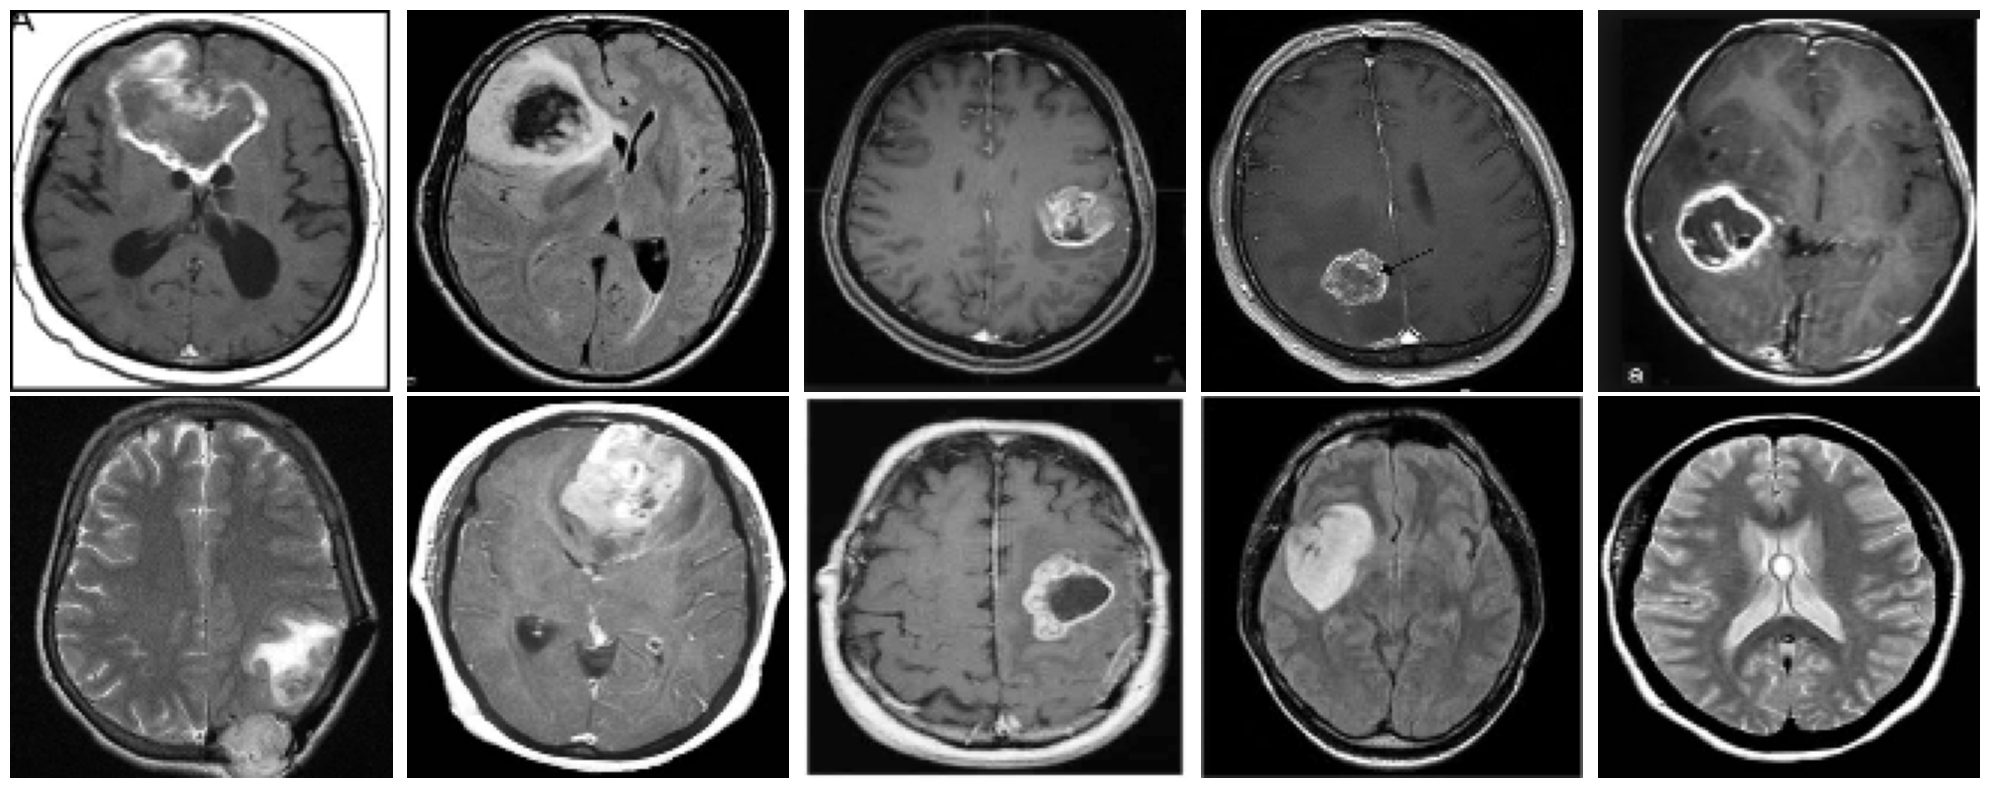

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [ ]:
def build_generator():
    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ],
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer="Adam")

    return model

In [ ]:
def build_discriminator():
    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",optimizer="Adam")

    return model

In [ ]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer="Adam")

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)   

In [ ]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)

    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')

        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
np.random.seed(SEED)
for epoch in range(1):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

  0%|          | 0/3750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 205ms/step


  0%|          | 1/3750 [00:01<1:57:23,  1.88s/it]

1/1 [==============================] - 0s 201ms/step


  0%|          | 2/3750 [00:03<1:56:04,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


  0%|          | 3/3750 [00:05<1:54:24,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


  0%|          | 4/3750 [00:07<1:53:12,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


  0%|          | 5/3750 [00:09<1:53:12,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


  0%|          | 6/3750 [00:11<1:54:33,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


  0%|          | 7/3750 [00:12<1:54:27,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


  0%|          | 8/3750 [00:14<1:55:13,  1.85s/it]

1/1 [==============================] - 0s 203ms/step


  0%|          | 9/3750 [00:16<1:56:02,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


  0%|          | 10/3750 [00:18<1:55:36,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


  0%|          | 11/3750 [00:20<1:55:23,  1.85s/it]

1/1 [==============================] - 0s 194ms/step


  0%|          | 12/3750 [00:22<1:54:44,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


  0%|          | 13/3750 [00:23<1:54:42,  1.84s/it]

1/1 [==============================] - 0s 180ms/step


  0%|          | 14/3750 [00:25<1:53:54,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


  0%|          | 15/3750 [00:27<1:53:05,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  0%|          | 16/3750 [00:29<1:52:42,  1.81s/it]

1/1 [==============================] - 0s 206ms/step


  0%|          | 17/3750 [00:31<1:57:14,  1.88s/it]

1/1 [==============================] - 0s 245ms/step


  0%|          | 18/3750 [00:33<1:59:24,  1.92s/it]

1/1 [==============================] - 0s 190ms/step


  1%|          | 19/3750 [00:35<1:56:47,  1.88s/it]

1/1 [==============================] - 0s 196ms/step


  1%|          | 20/3750 [00:36<1:54:18,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


  1%|          | 21/3750 [00:38<1:53:30,  1.83s/it]

1/1 [==============================] - 0s 214ms/step


  1%|          | 22/3750 [00:40<1:54:20,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


  1%|          | 23/3750 [00:42<1:53:12,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  1%|          | 24/3750 [00:44<1:52:38,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


  1%|          | 25/3750 [00:45<1:52:50,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


  1%|          | 26/3750 [00:47<1:51:46,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


  1%|          | 27/3750 [00:49<1:51:54,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


  1%|          | 28/3750 [00:51<1:53:12,  1.82s/it]

1/1 [==============================] - 0s 217ms/step


  1%|          | 29/3750 [00:53<1:53:12,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


  1%|          | 30/3750 [00:55<1:52:55,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


  1%|          | 31/3750 [00:56<1:51:52,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


  1%|          | 32/3750 [00:58<1:52:07,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


  1%|          | 33/3750 [01:00<1:52:39,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


  1%|          | 34/3750 [01:02<1:51:32,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


  1%|          | 35/3750 [01:04<1:57:02,  1.89s/it]

1/1 [==============================] - 0s 219ms/step


  1%|          | 36/3750 [01:06<1:55:52,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


  1%|          | 37/3750 [01:07<1:54:38,  1.85s/it]

1/1 [==============================] - 0s 200ms/step


  1%|          | 38/3750 [01:09<1:54:27,  1.85s/it]

1/1 [==============================] - 0s 248ms/step


  1%|          | 39/3750 [01:11<1:55:09,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


  1%|          | 40/3750 [01:13<1:54:04,  1.84s/it]

1/1 [==============================] - 0s 219ms/step


  1%|          | 41/3750 [01:15<1:54:17,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


  1%|          | 42/3750 [01:17<1:53:48,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


  1%|          | 43/3750 [01:19<1:53:03,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


  1%|          | 44/3750 [01:20<1:53:23,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


  1%|          | 45/3750 [01:22<1:53:33,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


  1%|          | 46/3750 [01:24<1:53:47,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▏         | 47/3750 [01:26<1:54:01,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▏         | 48/3750 [01:28<1:53:54,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▏         | 49/3750 [01:30<1:54:42,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▏         | 50/3750 [01:31<1:53:46,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


  1%|▏         | 51/3750 [01:33<1:52:10,  1.82s/it]

1/1 [==============================] - 0s 185ms/step


  1%|▏         | 52/3750 [01:35<1:55:54,  1.88s/it]

1/1 [==============================] - 0s 244ms/step


  1%|▏         | 53/3750 [01:37<1:58:20,  1.92s/it]

1/1 [==============================] - 0s 195ms/step


  1%|▏         | 54/3750 [01:39<1:56:19,  1.89s/it]

1/1 [==============================] - 0s 205ms/step


  1%|▏         | 55/3750 [01:41<1:55:48,  1.88s/it]

1/1 [==============================] - 0s 200ms/step


  1%|▏         | 56/3750 [01:43<1:55:05,  1.87s/it]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 57/3750 [01:45<1:55:23,  1.87s/it]

1/1 [==============================] - 0s 217ms/step


  2%|▏         | 58/3750 [01:47<1:55:13,  1.87s/it]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 59/3750 [01:48<1:53:27,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


  2%|▏         | 60/3750 [01:50<1:54:21,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 61/3750 [01:52<1:53:45,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 62/3750 [01:54<1:51:56,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 63/3750 [01:56<1:52:19,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 64/3750 [01:57<1:51:31,  1.82s/it]

1/1 [==============================] - 0s 177ms/step


  2%|▏         | 65/3750 [01:59<1:50:45,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


  2%|▏         | 66/3750 [02:01<1:51:31,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 67/3750 [02:03<1:51:02,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 68/3750 [02:05<1:50:08,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 69/3750 [02:06<1:49:39,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 70/3750 [02:09<1:56:10,  1.89s/it]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 71/3750 [02:10<1:54:41,  1.87s/it]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 72/3750 [02:12<1:52:14,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 73/3750 [02:14<1:52:20,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 74/3750 [02:16<1:51:39,  1.82s/it]

1/1 [==============================] - 0s 219ms/step


  2%|▏         | 75/3750 [02:18<1:51:44,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 76/3750 [02:19<1:50:24,  1.80s/it]

1/1 [==============================] - 0s 223ms/step


  2%|▏         | 77/3750 [02:21<1:50:55,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 78/3750 [02:23<1:50:14,  1.80s/it]

1/1 [==============================] - 0s 182ms/step


  2%|▏         | 79/3750 [02:25<1:49:30,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 80/3750 [02:26<1:49:05,  1.78s/it]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 81/3750 [02:28<1:49:14,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 82/3750 [02:30<1:49:39,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 83/3750 [02:32<1:49:07,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 84/3750 [02:34<1:48:58,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 85/3750 [02:35<1:48:46,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 86/3750 [02:37<1:48:39,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 87/3750 [02:39<1:49:18,  1.79s/it]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 88/3750 [02:41<1:56:59,  1.92s/it]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 89/3750 [02:43<1:54:50,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 90/3750 [02:45<1:54:05,  1.87s/it]

1/1 [==============================] - 0s 215ms/step


  2%|▏         | 91/3750 [02:47<1:53:31,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 92/3750 [02:48<1:52:59,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 93/3750 [02:50<1:52:50,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 94/3750 [02:52<1:51:40,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 95/3750 [02:54<1:51:05,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 96/3750 [02:56<1:51:38,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 97/3750 [02:58<1:51:14,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 98/3750 [02:59<1:51:01,  1.82s/it]

1/1 [==============================] - 0s 244ms/step


  3%|▎         | 99/3750 [03:01<1:51:34,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


  3%|▎         | 100/3750 [03:03<1:50:29,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 101/3750 [03:05<1:49:59,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


  3%|▎         | 102/3750 [03:07<1:49:45,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 103/3750 [03:08<1:50:21,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 104/3750 [03:10<1:50:19,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 105/3750 [03:12<1:54:18,  1.88s/it]

1/1 [==============================] - 0s 228ms/step


  3%|▎         | 106/3750 [03:14<1:55:25,  1.90s/it]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 107/3750 [03:16<1:53:57,  1.88s/it]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 108/3750 [03:18<1:53:00,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 109/3750 [03:20<1:52:48,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 110/3750 [03:22<1:51:51,  1.84s/it]

1/1 [==============================] - 0s 212ms/step


  3%|▎         | 111/3750 [03:23<1:51:22,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


  3%|▎         | 112/3750 [03:25<1:51:24,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


  3%|▎         | 113/3750 [03:27<1:50:19,  1.82s/it]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 114/3750 [03:29<1:49:20,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 115/3750 [03:31<1:50:14,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 116/3750 [03:32<1:50:11,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


  3%|▎         | 117/3750 [03:34<1:49:59,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 118/3750 [03:36<1:50:00,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 119/3750 [03:38<1:49:47,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 120/3750 [03:40<1:49:58,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 121/3750 [03:42<1:50:01,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 122/3750 [03:43<1:49:08,  1.81s/it]

1/1 [==============================] - 0s 233ms/step


  3%|▎         | 123/3750 [03:46<1:56:49,  1.93s/it]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 124/3750 [03:47<1:54:44,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 125/3750 [03:49<1:53:18,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


  3%|▎         | 126/3750 [03:51<1:52:49,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 127/3750 [03:53<1:51:14,  1.84s/it]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 128/3750 [03:55<1:49:46,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 129/3750 [03:56<1:49:42,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 130/3750 [03:58<1:49:23,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 131/3750 [04:00<1:50:28,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 132/3750 [04:02<1:49:44,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 133/3750 [04:04<1:48:35,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


  4%|▎         | 134/3750 [04:05<1:48:37,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


  4%|▎         | 135/3750 [04:07<1:48:02,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


  4%|▎         | 136/3750 [04:09<1:47:22,  1.78s/it]

1/1 [==============================] - 0s 206ms/step


  4%|▎         | 137/3750 [04:11<1:48:31,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


  4%|▎         | 138/3750 [04:13<1:47:44,  1.79s/it]

1/1 [==============================] - 0s 182ms/step


  4%|▎         | 139/3750 [04:14<1:46:52,  1.78s/it]

1/1 [==============================] - 0s 213ms/step


  4%|▎         | 140/3750 [04:16<1:49:14,  1.82s/it]

1/1 [==============================] - 0s 251ms/step


  4%|▍         | 141/3750 [04:18<1:52:57,  1.88s/it]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 142/3750 [04:20<1:52:08,  1.86s/it]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 143/3750 [04:22<1:50:07,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 144/3750 [04:24<1:49:39,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 145/3750 [04:25<1:50:04,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 146/3750 [04:27<1:50:03,  1.83s/it]

1/1 [==============================] - 0s 185ms/step


  4%|▍         | 147/3750 [04:29<1:49:25,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 148/3750 [04:31<1:49:56,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


  4%|▍         | 149/3750 [04:33<1:50:12,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 150/3750 [04:35<1:50:01,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 151/3750 [04:36<1:49:18,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 152/3750 [04:38<1:48:43,  1.81s/it]

1/1 [==============================] - 0s 224ms/step


  4%|▍         | 153/3750 [04:40<1:50:29,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 154/3750 [04:42<1:49:32,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 155/3750 [04:44<1:48:58,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 156/3750 [04:46<1:48:56,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 157/3750 [04:47<1:49:11,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


  4%|▍         | 158/3750 [04:50<1:54:44,  1.92s/it]

1/1 [==============================] - 0s 244ms/step


  4%|▍         | 159/3750 [04:51<1:53:58,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 160/3750 [04:53<1:52:43,  1.88s/it]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 161/3750 [04:55<1:51:12,  1.86s/it]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 162/3750 [04:57<1:51:26,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 163/3750 [04:59<1:50:42,  1.85s/it]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 164/3750 [05:01<1:50:59,  1.86s/it]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 165/3750 [05:02<1:50:16,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 166/3750 [05:04<1:50:02,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 167/3750 [05:06<1:49:24,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 168/3750 [05:08<1:49:11,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 169/3750 [05:10<1:49:24,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 170/3750 [05:12<1:48:35,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 171/3750 [05:13<1:47:49,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


  5%|▍         | 172/3750 [05:15<1:48:11,  1.81s/it]

1/1 [==============================] - 0s 184ms/step


  5%|▍         | 173/3750 [05:17<1:47:10,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 174/3750 [05:19<1:46:35,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 175/3750 [05:21<1:48:22,  1.82s/it]

1/1 [==============================] - 0s 249ms/step


  5%|▍         | 176/3750 [05:23<1:52:25,  1.89s/it]

1/1 [==============================] - 0s 196ms/step


  5%|▍         | 177/3750 [05:24<1:50:55,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 178/3750 [05:26<1:49:28,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 179/3750 [05:28<1:48:54,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 180/3750 [05:30<1:49:32,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 181/3750 [05:32<1:48:54,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


  5%|▍         | 182/3750 [05:33<1:48:10,  1.82s/it]

1/1 [==============================] - 0s 181ms/step


  5%|▍         | 183/3750 [05:35<1:46:56,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 184/3750 [05:37<1:46:16,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


  5%|▍         | 185/3750 [05:39<1:46:21,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 186/3750 [05:41<1:47:02,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 187/3750 [05:42<1:46:57,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 188/3750 [05:44<1:47:05,  1.80s/it]

1/1 [==============================] - 0s 180ms/step


  5%|▌         | 189/3750 [05:46<1:46:43,  1.80s/it]

1/1 [==============================] - 0s 183ms/step


  5%|▌         | 190/3750 [05:48<1:47:04,  1.80s/it]

1/1 [==============================] - 0s 183ms/step


  5%|▌         | 191/3750 [05:50<1:46:30,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 192/3750 [05:51<1:47:21,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 193/3750 [05:53<1:50:21,  1.86s/it]

1/1 [==============================] - 0s 222ms/step


  5%|▌         | 194/3750 [05:55<1:51:38,  1.88s/it]

1/1 [==============================] - 0s 205ms/step


  5%|▌         | 195/3750 [05:57<1:50:09,  1.86s/it]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 196/3750 [05:59<1:49:14,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 197/3750 [06:01<1:49:30,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


  5%|▌         | 198/3750 [06:03<1:48:53,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


  5%|▌         | 199/3750 [06:04<1:48:28,  1.83s/it]

1/1 [==============================] - 0s 180ms/step


  5%|▌         | 200/3750 [06:06<1:48:00,  1.83s/it]

1/1 [==============================] - 0s 207ms/step


  5%|▌         | 201/3750 [06:08<1:48:06,  1.83s/it]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 202/3750 [06:10<1:48:29,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


  5%|▌         | 203/3750 [06:12<1:48:46,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 204/3750 [06:14<1:49:34,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


  5%|▌         | 205/3750 [06:15<1:48:58,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 206/3750 [06:17<1:48:32,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 207/3750 [06:19<1:48:29,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


  6%|▌         | 208/3750 [06:21<1:50:19,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 209/3750 [06:23<1:49:44,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


  6%|▌         | 210/3750 [06:25<1:49:57,  1.86s/it]

1/1 [==============================] - 0s 270ms/step


  6%|▌         | 211/3750 [06:27<1:55:15,  1.95s/it]

1/1 [==============================] - 0s 212ms/step


  6%|▌         | 212/3750 [06:29<1:53:47,  1.93s/it]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 213/3750 [06:31<1:52:30,  1.91s/it]

1/1 [==============================] - 0s 202ms/step


  6%|▌         | 214/3750 [06:33<1:51:01,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 215/3750 [06:34<1:50:17,  1.87s/it]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 216/3750 [06:36<1:49:24,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 217/3750 [06:38<1:49:06,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 218/3750 [06:40<1:49:40,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 219/3750 [06:42<1:49:30,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 220/3750 [06:44<1:48:15,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


  6%|▌         | 221/3750 [06:45<1:48:29,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 222/3750 [06:47<1:47:48,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


  6%|▌         | 223/3750 [06:49<1:48:09,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 224/3750 [06:51<1:48:45,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


  6%|▌         | 225/3750 [06:53<1:48:17,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 226/3750 [06:55<1:47:51,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 227/3750 [06:56<1:47:28,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 228/3750 [06:59<1:53:27,  1.93s/it]

1/1 [==============================] - 0s 226ms/step


  6%|▌         | 229/3750 [07:00<1:51:40,  1.90s/it]

1/1 [==============================] - 0s 181ms/step


  6%|▌         | 230/3750 [07:02<1:49:47,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 231/3750 [07:04<1:48:31,  1.85s/it]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 232/3750 [07:06<1:47:46,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 233/3750 [07:08<1:46:49,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 234/3750 [07:09<1:46:44,  1.82s/it]

1/1 [==============================] - 0s 227ms/step


  6%|▋         | 235/3750 [07:11<1:46:46,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


  6%|▋         | 236/3750 [07:13<1:45:40,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


  6%|▋         | 237/3750 [07:15<1:46:02,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


  6%|▋         | 238/3750 [07:17<1:45:13,  1.80s/it]

1/1 [==============================] - 0s 181ms/step


  6%|▋         | 239/3750 [07:18<1:44:36,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


  6%|▋         | 240/3750 [07:20<1:45:37,  1.81s/it]

1/1 [==============================] - 0s 181ms/step


  6%|▋         | 241/3750 [07:22<1:45:29,  1.80s/it]

1/1 [==============================] - 0s 183ms/step


  6%|▋         | 242/3750 [07:24<1:45:35,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


  6%|▋         | 243/3750 [07:26<1:45:40,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 244/3750 [07:27<1:45:27,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 245/3750 [07:29<1:46:04,  1.82s/it]

1/1 [==============================] - 0s 301ms/step


  7%|▋         | 246/3750 [07:31<1:52:20,  1.92s/it]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 247/3750 [07:33<1:49:31,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 248/3750 [07:35<1:48:45,  1.86s/it]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 249/3750 [07:37<1:47:33,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 250/3750 [07:39<1:46:57,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 251/3750 [07:40<1:45:57,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 252/3750 [07:42<1:45:22,  1.81s/it]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 253/3750 [07:44<1:45:30,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 254/3750 [07:46<1:45:59,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


  7%|▋         | 255/3750 [07:48<1:45:35,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 256/3750 [07:50<1:46:00,  1.82s/it]

1/1 [==============================] - 0s 184ms/step


  7%|▋         | 257/3750 [07:51<1:45:26,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 258/3750 [07:53<1:45:36,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 259/3750 [07:55<1:44:34,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 260/3750 [07:57<1:44:18,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 261/3750 [07:58<1:44:14,  1.79s/it]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 262/3750 [08:00<1:45:38,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 263/3750 [08:02<1:49:09,  1.88s/it]

1/1 [==============================] - 0s 250ms/step


  7%|▋         | 264/3750 [08:04<1:50:19,  1.90s/it]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 265/3750 [08:06<1:48:37,  1.87s/it]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 266/3750 [08:08<1:47:35,  1.85s/it]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 267/3750 [08:10<1:47:30,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 268/3750 [08:12<1:46:45,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 269/3750 [08:13<1:45:55,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 270/3750 [08:15<1:45:54,  1.83s/it]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 271/3750 [08:17<1:45:25,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 272/3750 [08:19<1:45:07,  1.81s/it]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 273/3750 [08:21<1:46:33,  1.84s/it]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 274/3750 [08:23<1:45:56,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 275/3750 [08:24<1:46:05,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 276/3750 [08:26<1:46:00,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 277/3750 [08:28<1:45:09,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 278/3750 [08:30<1:45:44,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 279/3750 [08:32<1:45:18,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 280/3750 [08:33<1:45:07,  1.82s/it]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 281/3750 [08:36<1:51:36,  1.93s/it]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 282/3750 [08:37<1:48:59,  1.89s/it]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 283/3750 [08:39<1:47:33,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 284/3750 [08:41<1:47:44,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 285/3750 [08:43<1:46:00,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 286/3750 [08:45<1:45:31,  1.83s/it]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 287/3750 [08:47<1:45:34,  1.83s/it]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 288/3750 [08:48<1:45:01,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 289/3750 [08:50<1:45:30,  1.83s/it]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 290/3750 [08:52<1:45:19,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


  8%|▊         | 291/3750 [08:54<1:45:35,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 292/3750 [08:56<1:45:44,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 293/3750 [08:58<1:45:47,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 294/3750 [08:59<1:44:59,  1.82s/it]

1/1 [==============================] - 0s 227ms/step


  8%|▊         | 295/3750 [09:01<1:45:39,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 296/3750 [09:03<1:44:15,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 297/3750 [09:05<1:43:49,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 298/3750 [09:07<1:47:47,  1.87s/it]

1/1 [==============================] - 0s 266ms/step


  8%|▊         | 299/3750 [09:09<1:49:32,  1.90s/it]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 300/3750 [09:11<1:48:05,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 301/3750 [09:12<1:47:11,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 302/3750 [09:14<1:45:31,  1.84s/it]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 303/3750 [09:16<1:44:46,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 304/3750 [09:18<1:44:13,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 305/3750 [09:20<1:44:25,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 306/3750 [09:21<1:44:00,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


  8%|▊         | 307/3750 [09:23<1:44:09,  1.82s/it]

1/1 [==============================] - 0s 184ms/step


  8%|▊         | 308/3750 [09:25<1:43:54,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 309/3750 [09:27<1:44:02,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 310/3750 [09:29<1:45:38,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 311/3750 [09:31<1:47:02,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


  8%|▊         | 312/3750 [09:33<1:47:07,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


  8%|▊         | 313/3750 [09:34<1:46:20,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 314/3750 [09:36<1:46:00,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 315/3750 [09:38<1:45:53,  1.85s/it]

1/1 [==============================] - 0s 268ms/step


  8%|▊         | 316/3750 [09:40<1:52:56,  1.97s/it]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 317/3750 [09:42<1:50:25,  1.93s/it]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 318/3750 [09:44<1:47:45,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


  9%|▊         | 319/3750 [09:46<1:47:11,  1.87s/it]

1/1 [==============================] - 0s 205ms/step


  9%|▊         | 320/3750 [09:48<1:46:37,  1.87s/it]

1/1 [==============================] - 0s 217ms/step


  9%|▊         | 321/3750 [09:49<1:46:41,  1.87s/it]

1/1 [==============================] - 0s 241ms/step


  9%|▊         | 322/3750 [09:51<1:46:59,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


  9%|▊         | 323/3750 [09:53<1:46:59,  1.87s/it]

1/1 [==============================] - 0s 210ms/step


  9%|▊         | 324/3750 [09:55<1:46:54,  1.87s/it]

1/1 [==============================] - 0s 206ms/step


  9%|▊         | 325/3750 [09:57<1:46:21,  1.86s/it]

1/1 [==============================] - 0s 202ms/step


  9%|▊         | 326/3750 [09:59<1:46:30,  1.87s/it]

1/1 [==============================] - 0s 208ms/step


  9%|▊         | 327/3750 [10:01<1:45:58,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


  9%|▊         | 328/3750 [10:02<1:44:56,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 329/3750 [10:04<1:43:59,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


  9%|▉         | 330/3750 [10:06<1:44:03,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 331/3750 [10:08<1:43:41,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


  9%|▉         | 332/3750 [10:10<1:44:59,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


  9%|▉         | 333/3750 [10:12<1:51:33,  1.96s/it]

1/1 [==============================] - 0s 217ms/step


  9%|▉         | 334/3750 [10:14<1:49:48,  1.93s/it]

1/1 [==============================] - 0s 195ms/step


  9%|▉         | 335/3750 [10:16<1:48:20,  1.90s/it]

1/1 [==============================] - 0s 195ms/step


  9%|▉         | 336/3750 [10:18<1:47:03,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 337/3750 [10:19<1:46:20,  1.87s/it]

1/1 [==============================] - 0s 245ms/step


  9%|▉         | 338/3750 [10:21<1:46:08,  1.87s/it]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 339/3750 [10:23<1:46:00,  1.86s/it]

1/1 [==============================] - 0s 185ms/step


  9%|▉         | 340/3750 [10:25<1:44:56,  1.85s/it]

1/1 [==============================] - 0s 184ms/step


  9%|▉         | 341/3750 [10:27<1:44:12,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


  9%|▉         | 342/3750 [10:29<1:44:02,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


  9%|▉         | 343/3750 [10:30<1:44:32,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


  9%|▉         | 344/3750 [10:32<1:44:41,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


  9%|▉         | 345/3750 [10:34<1:44:42,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


  9%|▉         | 346/3750 [10:36<1:44:38,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


  9%|▉         | 347/3750 [10:38<1:44:45,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 348/3750 [10:40<1:46:08,  1.87s/it]

1/1 [==============================] - 0s 199ms/step


  9%|▉         | 349/3750 [10:42<1:46:03,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


  9%|▉         | 350/3750 [10:44<1:48:50,  1.92s/it]

1/1 [==============================] - 0s 250ms/step


  9%|▉         | 351/3750 [10:46<1:50:04,  1.94s/it]

1/1 [==============================] - 0s 193ms/step


  9%|▉         | 352/3750 [10:47<1:47:58,  1.91s/it]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 353/3750 [10:49<1:46:17,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 354/3750 [10:51<1:46:27,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


  9%|▉         | 355/3750 [10:53<1:45:17,  1.86s/it]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 356/3750 [10:55<1:44:09,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 10%|▉         | 357/3750 [10:57<1:43:30,  1.83s/it]

1/1 [==============================] - 0s 215ms/step


 10%|▉         | 358/3750 [10:58<1:43:47,  1.84s/it]

1/1 [==============================] - 0s 200ms/step


 10%|▉         | 359/3750 [11:00<1:43:47,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 10%|▉         | 360/3750 [11:02<1:43:04,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 10%|▉         | 361/3750 [11:04<1:42:27,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 10%|▉         | 362/3750 [11:06<1:42:01,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 363/3750 [11:07<1:41:37,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 10%|▉         | 364/3750 [11:09<1:41:51,  1.81s/it]

1/1 [==============================] - 0s 213ms/step


 10%|▉         | 365/3750 [11:11<1:42:56,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


 10%|▉         | 366/3750 [11:13<1:42:42,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 367/3750 [11:15<1:43:23,  1.83s/it]

1/1 [==============================] - 0s 257ms/step


 10%|▉         | 368/3750 [11:17<1:49:24,  1.94s/it]

1/1 [==============================] - 0s 195ms/step


 10%|▉         | 369/3750 [11:19<1:47:44,  1.91s/it]

1/1 [==============================] - 0s 210ms/step


 10%|▉         | 370/3750 [11:21<1:47:15,  1.90s/it]

1/1 [==============================] - 0s 195ms/step


 10%|▉         | 371/3750 [11:22<1:45:28,  1.87s/it]

1/1 [==============================] - 0s 192ms/step


 10%|▉         | 372/3750 [11:24<1:43:42,  1.84s/it]

1/1 [==============================] - 0s 181ms/step


 10%|▉         | 373/3750 [11:26<1:42:58,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 374/3750 [11:28<1:42:21,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 375/3750 [11:30<1:42:26,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 10%|█         | 376/3750 [11:31<1:41:46,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 10%|█         | 377/3750 [11:33<1:41:42,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 378/3750 [11:35<1:41:45,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 10%|█         | 379/3750 [11:37<1:40:40,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 10%|█         | 380/3750 [11:39<1:40:47,  1.79s/it]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 381/3750 [11:40<1:41:15,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 10%|█         | 382/3750 [11:42<1:41:02,  1.80s/it]

1/1 [==============================] - 0s 182ms/step


 10%|█         | 383/3750 [11:44<1:40:36,  1.79s/it]

1/1 [==============================] - 0s 198ms/step


 10%|█         | 384/3750 [11:46<1:40:46,  1.80s/it]

1/1 [==============================] - 0s 210ms/step


 10%|█         | 385/3750 [11:48<1:43:58,  1.85s/it]

1/1 [==============================] - 0s 250ms/step


 10%|█         | 386/3750 [11:50<1:47:30,  1.92s/it]

1/1 [==============================] - 0s 208ms/step


 10%|█         | 387/3750 [11:52<1:45:44,  1.89s/it]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 388/3750 [11:53<1:44:07,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 389/3750 [11:55<1:42:49,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 390/3750 [11:57<1:42:22,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 10%|█         | 391/3750 [11:59<1:41:51,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 10%|█         | 392/3750 [12:01<1:42:34,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 10%|█         | 393/3750 [12:03<1:41:45,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 11%|█         | 394/3750 [12:04<1:41:18,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 11%|█         | 395/3750 [12:06<1:41:08,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 396/3750 [12:08<1:40:41,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 11%|█         | 397/3750 [12:10<1:41:34,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 398/3750 [12:12<1:41:00,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 399/3750 [12:13<1:41:10,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 400/3750 [12:15<1:40:38,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 401/3750 [12:17<1:40:10,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 402/3750 [12:19<1:40:31,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 403/3750 [12:21<1:45:17,  1.89s/it]

1/1 [==============================] - 0s 253ms/step


 11%|█         | 404/3750 [12:23<1:44:53,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 405/3750 [12:24<1:43:26,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 406/3750 [12:26<1:42:21,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 407/3750 [12:28<1:40:49,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 408/3750 [12:30<1:41:01,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 409/3750 [12:32<1:40:22,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 11%|█         | 410/3750 [12:34<1:46:48,  1.92s/it]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 411/3750 [12:36<1:44:08,  1.87s/it]

1/1 [==============================] - 0s 208ms/step


 11%|█         | 412/3750 [12:37<1:42:44,  1.85s/it]

1/1 [==============================] - 0s 213ms/step


 11%|█         | 413/3750 [12:39<1:42:20,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 11%|█         | 414/3750 [12:41<1:42:27,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 11%|█         | 415/3750 [12:43<1:41:50,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 416/3750 [12:45<1:41:04,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 417/3750 [12:46<1:40:52,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 418/3750 [12:48<1:40:58,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 419/3750 [12:50<1:41:13,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 420/3750 [12:52<1:41:29,  1.83s/it]

1/1 [==============================] - 0s 273ms/step


 11%|█         | 421/3750 [12:54<1:45:32,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


 11%|█▏        | 422/3750 [12:56<1:44:02,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


 11%|█▏        | 423/3750 [12:58<1:42:43,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 11%|█▏        | 424/3750 [12:59<1:41:08,  1.82s/it]

1/1 [==============================] - 0s 233ms/step


 11%|█▏        | 425/3750 [13:01<1:40:37,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 11%|█▏        | 426/3750 [13:03<1:40:28,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 11%|█▏        | 427/3750 [13:05<1:39:42,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 428/3750 [13:07<1:39:04,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 11%|█▏        | 429/3750 [13:08<1:38:37,  1.78s/it]

1/1 [==============================] - 0s 205ms/step


 11%|█▏        | 430/3750 [13:10<1:39:31,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 11%|█▏        | 431/3750 [13:12<1:38:45,  1.79s/it]

1/1 [==============================] - 0s 215ms/step


 12%|█▏        | 432/3750 [13:14<1:38:51,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 433/3750 [13:15<1:38:09,  1.78s/it]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 434/3750 [13:17<1:38:34,  1.78s/it]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 435/3750 [13:19<1:39:00,  1.79s/it]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 436/3750 [13:21<1:39:18,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 437/3750 [13:23<1:38:47,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 12%|█▏        | 438/3750 [13:25<1:42:00,  1.85s/it]

1/1 [==============================] - 0s 235ms/step


 12%|█▏        | 439/3750 [13:27<1:44:32,  1.89s/it]

1/1 [==============================] - 0s 213ms/step


 12%|█▏        | 440/3750 [13:28<1:43:30,  1.88s/it]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 441/3750 [13:30<1:42:36,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 442/3750 [13:32<1:41:29,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 443/3750 [13:34<1:40:31,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 444/3750 [13:36<1:40:20,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 445/3750 [13:37<1:39:51,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 446/3750 [13:39<1:39:27,  1.81s/it]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 447/3750 [13:41<1:39:47,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 448/3750 [13:43<1:39:14,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 449/3750 [13:45<1:39:15,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 450/3750 [13:46<1:38:22,  1.79s/it]

1/1 [==============================] - 0s 209ms/step


 12%|█▏        | 451/3750 [13:48<1:37:48,  1.78s/it]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 452/3750 [13:50<1:38:25,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 453/3750 [13:52<1:38:20,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 454/3750 [13:54<1:38:05,  1.79s/it]

1/1 [==============================] - 0s 210ms/step


 12%|█▏        | 455/3750 [13:55<1:38:46,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 456/3750 [13:57<1:42:44,  1.87s/it]

1/1 [==============================] - 0s 238ms/step


 12%|█▏        | 457/3750 [13:59<1:42:29,  1.87s/it]

1/1 [==============================] - 0s 208ms/step


 12%|█▏        | 458/3750 [14:01<1:41:52,  1.86s/it]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 459/3750 [14:03<1:40:47,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


 12%|█▏        | 460/3750 [14:05<1:39:17,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 461/3750 [14:06<1:38:45,  1.80s/it]

1/1 [==============================] - 0s 208ms/step


 12%|█▏        | 462/3750 [14:08<1:38:19,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 12%|█▏        | 463/3750 [14:10<1:39:09,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 12%|█▏        | 464/3750 [14:12<1:38:37,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 465/3750 [14:14<1:38:10,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 466/3750 [14:15<1:38:45,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 467/3750 [14:17<1:38:53,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 468/3750 [14:19<1:37:39,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 469/3750 [14:21<1:38:39,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 470/3750 [14:23<1:37:46,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 471/3750 [14:24<1:38:10,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 472/3750 [14:26<1:38:09,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 473/3750 [14:28<1:38:19,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 474/3750 [14:30<1:45:34,  1.93s/it]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 475/3750 [14:32<1:42:40,  1.88s/it]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 476/3750 [14:34<1:41:34,  1.86s/it]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 477/3750 [14:36<1:40:26,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 478/3750 [14:37<1:39:25,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 479/3750 [14:39<1:38:51,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 480/3750 [14:41<1:39:18,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 481/3750 [14:43<1:39:12,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 482/3750 [14:45<1:38:06,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 13%|█▎        | 483/3750 [14:46<1:37:57,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 484/3750 [14:48<1:37:21,  1.79s/it]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 485/3750 [14:50<1:38:13,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 486/3750 [14:52<1:38:18,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 487/3750 [14:54<1:37:31,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 488/3750 [14:55<1:37:53,  1.80s/it]

1/1 [==============================] - 0s 208ms/step


 13%|█▎        | 489/3750 [14:57<1:37:31,  1.79s/it]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 490/3750 [14:59<1:37:58,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 491/3750 [15:01<1:39:42,  1.84s/it]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 492/3750 [15:03<1:42:48,  1.89s/it]

1/1 [==============================] - 0s 215ms/step


 13%|█▎        | 493/3750 [15:05<1:41:43,  1.87s/it]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 494/3750 [15:07<1:40:15,  1.85s/it]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 495/3750 [15:08<1:39:01,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 13%|█▎        | 496/3750 [15:10<1:39:19,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 497/3750 [15:12<1:37:55,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 498/3750 [15:14<1:37:07,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 499/3750 [15:15<1:37:07,  1.79s/it]

1/1 [==============================] - 0s 183ms/step


 13%|█▎        | 500/3750 [15:17<1:37:13,  1.79s/it]

1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 501/3750 [15:19<1:37:12,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 502/3750 [15:21<1:37:55,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 503/3750 [15:23<1:37:35,  1.80s/it]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 504/3750 [15:24<1:37:21,  1.80s/it]

1/1 [==============================] - 0s 180ms/step


 13%|█▎        | 505/3750 [15:26<1:36:28,  1.78s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 506/3750 [15:28<1:36:17,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


 14%|█▎        | 507/3750 [15:30<1:36:42,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 14%|█▎        | 508/3750 [15:32<1:36:55,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 14%|█▎        | 509/3750 [15:34<1:39:39,  1.84s/it]

1/1 [==============================] - 0s 234ms/step


 14%|█▎        | 510/3750 [15:36<1:41:58,  1.89s/it]

1/1 [==============================] - 0s 190ms/step


 14%|█▎        | 511/3750 [15:37<1:40:13,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 14%|█▎        | 512/3750 [15:39<1:39:33,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 14%|█▎        | 513/3750 [15:41<1:39:28,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 14%|█▎        | 514/3750 [15:43<1:38:59,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 14%|█▎        | 515/3750 [15:45<1:38:31,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 516/3750 [15:46<1:37:43,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 517/3750 [15:48<1:37:35,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 518/3750 [15:50<1:38:04,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 14%|█▍        | 519/3750 [15:52<1:37:40,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 14%|█▍        | 520/3750 [15:54<1:37:19,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 521/3750 [15:55<1:36:55,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 14%|█▍        | 522/3750 [15:57<1:37:23,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 523/3750 [15:59<1:37:09,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 14%|█▍        | 524/3750 [16:01<1:37:48,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 525/3750 [16:03<1:37:00,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 526/3750 [16:05<1:36:59,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 14%|█▍        | 527/3750 [16:07<1:41:08,  1.88s/it]

1/1 [==============================] - 0s 237ms/step


 14%|█▍        | 528/3750 [16:08<1:40:53,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 529/3750 [16:10<1:39:45,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 530/3750 [16:12<1:38:22,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 14%|█▍        | 531/3750 [16:14<1:38:03,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 532/3750 [16:16<1:38:02,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 533/3750 [16:17<1:37:14,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 14%|█▍        | 534/3750 [16:19<1:36:56,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 535/3750 [16:21<1:37:06,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 536/3750 [16:23<1:37:05,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 537/3750 [16:25<1:36:00,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 538/3750 [16:26<1:37:14,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 539/3750 [16:28<1:37:00,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 540/3750 [16:30<1:37:35,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 541/3750 [16:32<1:37:12,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 542/3750 [16:34<1:36:45,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 14%|█▍        | 543/3750 [16:36<1:36:49,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 15%|█▍        | 544/3750 [16:37<1:36:08,  1.80s/it]

1/1 [==============================] - 0s 249ms/step


 15%|█▍        | 545/3750 [16:39<1:42:01,  1.91s/it]

1/1 [==============================] - 0s 204ms/step


 15%|█▍        | 546/3750 [16:41<1:41:25,  1.90s/it]

1/1 [==============================] - 0s 193ms/step


 15%|█▍        | 547/3750 [16:43<1:39:25,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 15%|█▍        | 548/3750 [16:45<1:38:25,  1.84s/it]

1/1 [==============================] - 0s 188ms/step


 15%|█▍        | 549/3750 [16:47<1:37:31,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 550/3750 [16:49<1:36:50,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 15%|█▍        | 551/3750 [16:50<1:36:33,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 552/3750 [16:52<1:36:51,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 15%|█▍        | 553/3750 [16:54<1:36:36,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 15%|█▍        | 554/3750 [16:56<1:36:39,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 15%|█▍        | 555/3750 [16:58<1:36:27,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 15%|█▍        | 556/3750 [16:59<1:36:28,  1.81s/it]

1/1 [==============================] - 0s 223ms/step


 15%|█▍        | 557/3750 [17:01<1:35:49,  1.80s/it]

1/1 [==============================] - 0s 215ms/step


 15%|█▍        | 558/3750 [17:03<1:35:41,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 15%|█▍        | 559/3750 [17:05<1:35:46,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 15%|█▍        | 560/3750 [17:07<1:36:22,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 15%|█▍        | 561/3750 [17:08<1:36:13,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 15%|█▍        | 562/3750 [17:10<1:40:08,  1.88s/it]

1/1 [==============================] - 0s 235ms/step


 15%|█▌        | 563/3750 [17:12<1:41:49,  1.92s/it]

1/1 [==============================] - 0s 194ms/step


 15%|█▌        | 564/3750 [17:14<1:39:44,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 15%|█▌        | 565/3750 [17:16<1:38:20,  1.85s/it]

1/1 [==============================] - 0s 187ms/step


 15%|█▌        | 566/3750 [17:18<1:37:07,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 15%|█▌        | 567/3750 [17:20<1:37:03,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 15%|█▌        | 568/3750 [17:21<1:36:08,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 15%|█▌        | 569/3750 [17:23<1:35:45,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 15%|█▌        | 570/3750 [17:25<1:35:40,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 15%|█▌        | 571/3750 [17:27<1:35:02,  1.79s/it]

1/1 [==============================] - 0s 204ms/step


 15%|█▌        | 572/3750 [17:29<1:35:13,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 15%|█▌        | 573/3750 [17:30<1:34:31,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 15%|█▌        | 574/3750 [17:32<1:34:40,  1.79s/it]

1/1 [==============================] - 0s 207ms/step


 15%|█▌        | 575/3750 [17:34<1:34:59,  1.80s/it]

1/1 [==============================] - 0s 183ms/step


 15%|█▌        | 576/3750 [17:36<1:34:20,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 15%|█▌        | 577/3750 [17:37<1:34:17,  1.78s/it]

1/1 [==============================] - 0s 204ms/step


 15%|█▌        | 578/3750 [17:39<1:34:53,  1.79s/it]

1/1 [==============================] - 0s 233ms/step


 15%|█▌        | 579/3750 [17:41<1:35:30,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 15%|█▌        | 580/3750 [17:43<1:40:04,  1.89s/it]

1/1 [==============================] - 0s 239ms/step


 15%|█▌        | 581/3750 [17:45<1:39:23,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 16%|█▌        | 582/3750 [17:47<1:38:21,  1.86s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 583/3750 [17:49<1:36:53,  1.84s/it]

1/1 [==============================] - 0s 189ms/step


 16%|█▌        | 584/3750 [17:51<1:37:02,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 16%|█▌        | 585/3750 [17:52<1:36:02,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 16%|█▌        | 586/3750 [17:54<1:35:29,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 16%|█▌        | 587/3750 [17:56<1:34:49,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 16%|█▌        | 588/3750 [17:58<1:34:38,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 16%|█▌        | 589/3750 [17:59<1:34:45,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 16%|█▌        | 590/3750 [18:01<1:34:51,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 16%|█▌        | 591/3750 [18:03<1:34:32,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 592/3750 [18:05<1:34:09,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 16%|█▌        | 593/3750 [18:07<1:34:23,  1.79s/it]

1/1 [==============================] - 0s 207ms/step


 16%|█▌        | 594/3750 [18:08<1:34:32,  1.80s/it]

1/1 [==============================] - 0s 186ms/step


 16%|█▌        | 595/3750 [18:10<1:34:56,  1.81s/it]

1/1 [==============================] - 0s 180ms/step


 16%|█▌        | 596/3750 [18:12<1:34:03,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 16%|█▌        | 597/3750 [18:14<1:34:22,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 16%|█▌        | 598/3750 [18:16<1:40:59,  1.92s/it]

1/1 [==============================] - 0s 194ms/step


 16%|█▌        | 599/3750 [18:18<1:38:49,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


 16%|█▌        | 600/3750 [18:20<1:38:00,  1.87s/it]

1/1 [==============================] - 0s 219ms/step


 16%|█▌        | 601/3750 [18:21<1:37:00,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 16%|█▌        | 602/3750 [18:23<1:35:54,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 603/3750 [18:25<1:35:26,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 16%|█▌        | 604/3750 [18:27<1:35:37,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 16%|█▌        | 605/3750 [18:29<1:34:59,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 16%|█▌        | 606/3750 [18:31<1:35:27,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 16%|█▌        | 607/3750 [18:32<1:34:59,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▌        | 608/3750 [18:34<1:34:22,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 16%|█▌        | 609/3750 [18:36<1:34:06,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▋        | 610/3750 [18:38<1:33:44,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 16%|█▋        | 611/3750 [18:39<1:33:53,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 16%|█▋        | 612/3750 [18:41<1:34:11,  1.80s/it]

1/1 [==============================] - 0s 212ms/step


 16%|█▋        | 613/3750 [18:43<1:35:10,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 16%|█▋        | 614/3750 [18:45<1:34:52,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 16%|█▋        | 615/3750 [18:47<1:35:52,  1.84s/it]

1/1 [==============================] - 0s 241ms/step


 16%|█▋        | 616/3750 [18:49<1:39:09,  1.90s/it]

1/1 [==============================] - 0s 196ms/step


 16%|█▋        | 617/3750 [18:51<1:38:30,  1.89s/it]

1/1 [==============================] - 0s 196ms/step


 16%|█▋        | 618/3750 [18:53<1:37:18,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


 17%|█▋        | 619/3750 [18:54<1:36:19,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 17%|█▋        | 620/3750 [18:56<1:35:38,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█▋        | 621/3750 [18:58<1:35:18,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 17%|█▋        | 622/3750 [19:00<1:35:53,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█▋        | 623/3750 [19:02<1:35:23,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 624/3750 [19:03<1:34:55,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 625/3750 [19:05<1:34:28,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 17%|█▋        | 626/3750 [19:07<1:34:30,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 17%|█▋        | 627/3750 [19:09<1:34:14,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 17%|█▋        | 628/3750 [19:11<1:34:35,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 629/3750 [19:12<1:34:23,  1.81s/it]

1/1 [==============================] - 0s 184ms/step


 17%|█▋        | 630/3750 [19:14<1:33:41,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 17%|█▋        | 631/3750 [19:16<1:33:38,  1.80s/it]

1/1 [==============================] - 0s 182ms/step


 17%|█▋        | 632/3750 [19:18<1:33:35,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 17%|█▋        | 633/3750 [19:20<1:38:46,  1.90s/it]

1/1 [==============================] - 0s 238ms/step


 17%|█▋        | 634/3750 [19:22<1:38:13,  1.89s/it]

1/1 [==============================] - 0s 195ms/step


 17%|█▋        | 635/3750 [19:24<1:37:10,  1.87s/it]

1/1 [==============================] - 0s 186ms/step


 17%|█▋        | 636/3750 [19:25<1:35:39,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 17%|█▋        | 637/3750 [19:27<1:34:23,  1.82s/it]

1/1 [==============================] - 0s 181ms/step


 17%|█▋        | 638/3750 [19:29<1:33:26,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 17%|█▋        | 639/3750 [19:31<1:33:31,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 17%|█▋        | 640/3750 [19:33<1:33:20,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 17%|█▋        | 641/3750 [19:34<1:33:28,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 642/3750 [19:36<1:34:06,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 17%|█▋        | 643/3750 [19:38<1:33:46,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 17%|█▋        | 644/3750 [19:40<1:34:11,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 17%|█▋        | 645/3750 [19:42<1:34:15,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 17%|█▋        | 646/3750 [19:44<1:34:03,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 17%|█▋        | 647/3750 [19:45<1:33:49,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 17%|█▋        | 648/3750 [19:47<1:33:59,  1.82s/it]

1/1 [==============================] - 0s 185ms/step


 17%|█▋        | 649/3750 [19:49<1:33:12,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 17%|█▋        | 650/3750 [19:51<1:39:55,  1.93s/it]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 651/3750 [19:53<1:42:18,  1.98s/it]

1/1 [==============================] - 0s 205ms/step


 17%|█▋        | 652/3750 [19:55<1:39:36,  1.93s/it]

1/1 [==============================] - 0s 184ms/step


 17%|█▋        | 653/3750 [19:57<1:37:14,  1.88s/it]

1/1 [==============================] - 0s 214ms/step


 17%|█▋        | 654/3750 [19:59<1:36:16,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


 17%|█▋        | 655/3750 [20:00<1:35:33,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 17%|█▋        | 656/3750 [20:02<1:35:13,  1.85s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 657/3750 [20:04<1:34:42,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 18%|█▊        | 658/3750 [20:06<1:34:48,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 18%|█▊        | 659/3750 [20:08<1:34:16,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 660/3750 [20:10<1:34:38,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 661/3750 [20:11<1:33:49,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 18%|█▊        | 662/3750 [20:13<1:33:12,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 18%|█▊        | 663/3750 [20:15<1:33:22,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 18%|█▊        | 664/3750 [20:17<1:33:22,  1.82s/it]

1/1 [==============================] - 0s 184ms/step


 18%|█▊        | 665/3750 [20:19<1:32:36,  1.80s/it]

1/1 [==============================] - 0s 212ms/step


 18%|█▊        | 666/3750 [20:20<1:33:11,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 667/3750 [20:22<1:32:37,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 18%|█▊        | 668/3750 [20:24<1:36:16,  1.87s/it]

1/1 [==============================] - 0s 240ms/step


 18%|█▊        | 669/3750 [20:26<1:37:01,  1.89s/it]

1/1 [==============================] - 0s 196ms/step


 18%|█▊        | 670/3750 [20:28<1:35:54,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 18%|█▊        | 671/3750 [20:30<1:36:04,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 672/3750 [20:32<1:35:14,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 673/3750 [20:34<1:34:36,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 18%|█▊        | 674/3750 [20:35<1:34:06,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 18%|█▊        | 675/3750 [20:37<1:33:43,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 676/3750 [20:39<1:33:12,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 18%|█▊        | 677/3750 [20:41<1:34:08,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 18%|█▊        | 678/3750 [20:43<1:34:13,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 18%|█▊        | 679/3750 [20:45<1:33:45,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 18%|█▊        | 680/3750 [20:46<1:33:47,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 18%|█▊        | 681/3750 [20:48<1:33:19,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 18%|█▊        | 682/3750 [20:50<1:34:06,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


 18%|█▊        | 683/3750 [20:52<1:33:52,  1.84s/it]

1/1 [==============================] - 0s 190ms/step


 18%|█▊        | 684/3750 [20:54<1:33:22,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 18%|█▊        | 685/3750 [20:56<1:33:49,  1.84s/it]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 686/3750 [20:58<1:38:20,  1.93s/it]

1/1 [==============================] - 0s 186ms/step


 18%|█▊        | 687/3750 [20:59<1:35:48,  1.88s/it]

1/1 [==============================] - 0s 220ms/step


 18%|█▊        | 688/3750 [21:01<1:34:28,  1.85s/it]

1/1 [==============================] - 0s 193ms/step


 18%|█▊        | 689/3750 [21:03<1:33:07,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 18%|█▊        | 690/3750 [21:05<1:32:33,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 18%|█▊        | 691/3750 [21:07<1:31:55,  1.80s/it]

1/1 [==============================] - 0s 179ms/step


 18%|█▊        | 692/3750 [21:08<1:31:37,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 18%|█▊        | 693/3750 [21:10<1:32:27,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 19%|█▊        | 694/3750 [21:12<1:32:06,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 19%|█▊        | 695/3750 [21:14<1:31:34,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 19%|█▊        | 696/3750 [21:16<1:30:50,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 19%|█▊        | 697/3750 [21:17<1:31:04,  1.79s/it]

1/1 [==============================] - 0s 203ms/step


 19%|█▊        | 698/3750 [21:19<1:31:44,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 19%|█▊        | 699/3750 [21:21<1:32:24,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 19%|█▊        | 700/3750 [21:23<1:32:01,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 19%|█▊        | 701/3750 [21:25<1:31:29,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 19%|█▊        | 702/3750 [21:26<1:31:19,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 19%|█▊        | 703/3750 [21:28<1:34:14,  1.86s/it]

1/1 [==============================] - 0s 238ms/step


 19%|█▉        | 704/3750 [21:30<1:36:52,  1.91s/it]

1/1 [==============================] - 0s 197ms/step


 19%|█▉        | 705/3750 [21:32<1:35:13,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 19%|█▉        | 706/3750 [21:34<1:34:13,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


 19%|█▉        | 707/3750 [21:36<1:33:55,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


 19%|█▉        | 708/3750 [21:38<1:33:27,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█▉        | 709/3750 [21:40<1:33:33,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 19%|█▉        | 710/3750 [21:41<1:33:30,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


 19%|█▉        | 711/3750 [21:43<1:32:51,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 19%|█▉        | 712/3750 [21:45<1:32:13,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


 19%|█▉        | 713/3750 [21:47<1:32:07,  1.82s/it]

1/1 [==============================] - 0s 213ms/step


 19%|█▉        | 714/3750 [21:49<1:32:20,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 19%|█▉        | 715/3750 [21:50<1:32:32,  1.83s/it]

1/1 [==============================] - 0s 183ms/step


 19%|█▉        | 716/3750 [21:52<1:31:59,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 19%|█▉        | 717/3750 [21:54<1:31:33,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 19%|█▉        | 718/3750 [21:56<1:31:23,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 19%|█▉        | 719/3750 [21:58<1:31:28,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 19%|█▉        | 720/3750 [21:59<1:31:32,  1.81s/it]

1/1 [==============================] - 0s 218ms/step


 19%|█▉        | 721/3750 [22:02<1:37:05,  1.92s/it]

1/1 [==============================] - 0s 191ms/step


 19%|█▉        | 722/3750 [22:03<1:35:23,  1.89s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█▉        | 723/3750 [22:05<1:34:25,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


 19%|█▉        | 724/3750 [22:07<1:33:16,  1.85s/it]

1/1 [==============================] - 0s 194ms/step


 19%|█▉        | 725/3750 [22:09<1:32:36,  1.84s/it]

1/1 [==============================] - 0s 220ms/step


 19%|█▉        | 726/3750 [22:11<1:32:47,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 19%|█▉        | 727/3750 [22:13<1:32:25,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 19%|█▉        | 728/3750 [22:14<1:31:34,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 19%|█▉        | 729/3750 [22:16<1:30:52,  1.80s/it]

1/1 [==============================] - 0s 184ms/step


 19%|█▉        | 730/3750 [22:18<1:30:17,  1.79s/it]

1/1 [==============================] - 0s 198ms/step


 19%|█▉        | 731/3750 [22:20<1:31:02,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 20%|█▉        | 732/3750 [22:22<1:30:56,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 20%|█▉        | 733/3750 [22:23<1:31:16,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 20%|█▉        | 734/3750 [22:25<1:30:54,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 20%|█▉        | 735/3750 [22:27<1:30:23,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 20%|█▉        | 736/3750 [22:29<1:30:59,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 20%|█▉        | 737/3750 [22:31<1:31:20,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 20%|█▉        | 738/3750 [22:33<1:32:53,  1.85s/it]

1/1 [==============================] - 0s 242ms/step


 20%|█▉        | 739/3750 [22:35<1:36:08,  1.92s/it]

1/1 [==============================] - 0s 205ms/step


 20%|█▉        | 740/3750 [22:36<1:34:54,  1.89s/it]

1/1 [==============================] - 0s 215ms/step


 20%|█▉        | 741/3750 [22:38<1:34:06,  1.88s/it]

1/1 [==============================] - 0s 192ms/step


 20%|█▉        | 742/3750 [22:40<1:33:40,  1.87s/it]

1/1 [==============================] - 0s 201ms/step


 20%|█▉        | 743/3750 [22:42<1:32:30,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 20%|█▉        | 744/3750 [22:44<1:32:05,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 20%|█▉        | 745/3750 [22:46<1:31:34,  1.83s/it]

1/1 [==============================] - 0s 207ms/step


 20%|█▉        | 746/3750 [22:47<1:31:18,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 20%|█▉        | 747/3750 [22:49<1:30:41,  1.81s/it]

1/1 [==============================] - 0s 181ms/step


 20%|█▉        | 748/3750 [22:51<1:30:34,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 20%|█▉        | 749/3750 [22:53<1:30:11,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 20%|██        | 750/3750 [22:55<1:30:29,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 20%|██        | 751/3750 [22:56<1:30:15,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 20%|██        | 752/3750 [22:58<1:30:37,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 20%|██        | 753/3750 [23:00<1:31:15,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 20%|██        | 754/3750 [23:02<1:30:53,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 20%|██        | 755/3750 [23:04<1:29:50,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 20%|██        | 756/3750 [23:06<1:33:27,  1.87s/it]

1/1 [==============================] - 0s 236ms/step


 20%|██        | 757/3750 [23:07<1:32:49,  1.86s/it]

1/1 [==============================] - 0s 183ms/step


 20%|██        | 758/3750 [23:09<1:32:00,  1.84s/it]

1/1 [==============================] - 0s 228ms/step


 20%|██        | 759/3750 [23:11<1:31:23,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 20%|██        | 760/3750 [23:13<1:30:18,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 20%|██        | 761/3750 [23:15<1:29:55,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 20%|██        | 762/3750 [23:16<1:29:23,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 20%|██        | 763/3750 [23:18<1:29:37,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 20%|██        | 764/3750 [23:20<1:29:55,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 20%|██        | 765/3750 [23:22<1:29:51,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 20%|██        | 766/3750 [23:24<1:30:17,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 20%|██        | 767/3750 [23:25<1:29:54,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 20%|██        | 768/3750 [23:27<1:29:45,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 21%|██        | 769/3750 [23:29<1:29:06,  1.79s/it]

1/1 [==============================] - 0s 206ms/step


 21%|██        | 770/3750 [23:31<1:30:11,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 21%|██        | 771/3750 [23:33<1:29:49,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 21%|██        | 772/3750 [23:34<1:29:18,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 21%|██        | 773/3750 [23:36<1:28:52,  1.79s/it]

1/1 [==============================] - 0s 229ms/step


 21%|██        | 774/3750 [23:38<1:34:47,  1.91s/it]

1/1 [==============================] - 0s 204ms/step


 21%|██        | 775/3750 [23:40<1:33:32,  1.89s/it]

1/1 [==============================] - 0s 190ms/step


 21%|██        | 776/3750 [23:42<1:32:11,  1.86s/it]

1/1 [==============================] - 0s 187ms/step


 21%|██        | 777/3750 [23:44<1:31:13,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 21%|██        | 778/3750 [23:46<1:30:40,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 21%|██        | 779/3750 [23:48<1:30:23,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 21%|██        | 780/3750 [23:49<1:29:59,  1.82s/it]

1/1 [==============================] - 0s 220ms/step


 21%|██        | 781/3750 [23:51<1:30:06,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 21%|██        | 782/3750 [23:53<1:29:48,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 21%|██        | 783/3750 [23:55<1:30:01,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 21%|██        | 784/3750 [23:57<1:29:33,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 21%|██        | 785/3750 [23:58<1:29:11,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 21%|██        | 786/3750 [24:00<1:29:41,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 21%|██        | 787/3750 [24:02<1:29:12,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


 21%|██        | 788/3750 [24:04<1:28:52,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 21%|██        | 789/3750 [24:06<1:28:52,  1.80s/it]

1/1 [==============================] - 0s 213ms/step


 21%|██        | 790/3750 [24:07<1:29:28,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 21%|██        | 791/3750 [24:09<1:30:36,  1.84s/it]

1/1 [==============================] - 0s 298ms/step


 21%|██        | 792/3750 [24:11<1:34:25,  1.92s/it]

1/1 [==============================] - 0s 202ms/step


 21%|██        | 793/3750 [24:13<1:32:48,  1.88s/it]

1/1 [==============================] - 0s 192ms/step


 21%|██        | 794/3750 [24:15<1:31:51,  1.86s/it]

1/1 [==============================] - 0s 214ms/step


 21%|██        | 795/3750 [24:17<1:30:49,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 21%|██        | 796/3750 [24:19<1:30:04,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 21%|██▏       | 797/3750 [24:20<1:29:32,  1.82s/it]

1/1 [==============================] - 0s 209ms/step


 21%|██▏       | 798/3750 [24:22<1:29:07,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 21%|██▏       | 799/3750 [24:24<1:28:57,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 21%|██▏       | 800/3750 [24:26<1:28:33,  1.80s/it]

1/1 [==============================] - 0s 208ms/step


 21%|██▏       | 801/3750 [24:28<1:28:44,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 21%|██▏       | 802/3750 [24:29<1:28:34,  1.80s/it]

1/1 [==============================] - 0s 239ms/step


 21%|██▏       | 803/3750 [24:31<1:29:07,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 21%|██▏       | 804/3750 [24:33<1:29:12,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 21%|██▏       | 805/3750 [24:35<1:28:25,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 21%|██▏       | 806/3750 [24:37<1:28:10,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 22%|██▏       | 807/3750 [24:38<1:28:13,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 22%|██▏       | 808/3750 [24:40<1:28:53,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 22%|██▏       | 809/3750 [24:42<1:32:45,  1.89s/it]

1/1 [==============================] - 0s 240ms/step


 22%|██▏       | 810/3750 [24:44<1:32:47,  1.89s/it]

1/1 [==============================] - 0s 193ms/step


 22%|██▏       | 811/3750 [24:46<1:31:30,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 22%|██▏       | 812/3750 [24:48<1:30:46,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 22%|██▏       | 813/3750 [24:50<1:30:48,  1.85s/it]

1/1 [==============================] - 0s 193ms/step


 22%|██▏       | 814/3750 [24:51<1:29:25,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 22%|██▏       | 815/3750 [24:53<1:29:12,  1.82s/it]

1/1 [==============================] - 0s 209ms/step


 22%|██▏       | 816/3750 [24:55<1:28:31,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 22%|██▏       | 817/3750 [24:57<1:27:40,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 818/3750 [24:59<1:27:58,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 22%|██▏       | 819/3750 [25:01<1:28:37,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 22%|██▏       | 820/3750 [25:02<1:28:17,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 22%|██▏       | 821/3750 [25:04<1:28:04,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 22%|██▏       | 822/3750 [25:06<1:28:04,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 22%|██▏       | 823/3750 [25:08<1:28:11,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 22%|██▏       | 824/3750 [25:10<1:28:46,  1.82s/it]

1/1 [==============================] - 0s 212ms/step


 22%|██▏       | 825/3750 [25:11<1:29:20,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 22%|██▏       | 826/3750 [25:13<1:29:34,  1.84s/it]

1/1 [==============================] - 0s 246ms/step


 22%|██▏       | 827/3750 [25:15<1:33:45,  1.92s/it]

1/1 [==============================] - 0s 202ms/step


 22%|██▏       | 828/3750 [25:17<1:31:32,  1.88s/it]

1/1 [==============================] - 0s 205ms/step


 22%|██▏       | 829/3750 [25:19<1:30:16,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 22%|██▏       | 830/3750 [25:21<1:30:13,  1.85s/it]

1/1 [==============================] - 0s 191ms/step


 22%|██▏       | 831/3750 [25:23<1:29:06,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 832/3750 [25:24<1:28:22,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 22%|██▏       | 833/3750 [25:26<1:28:16,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 22%|██▏       | 834/3750 [25:28<1:28:29,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 22%|██▏       | 835/3750 [25:30<1:28:46,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 22%|██▏       | 836/3750 [25:32<1:28:51,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 837/3750 [25:33<1:28:07,  1.82s/it]

1/1 [==============================] - 0s 214ms/step


 22%|██▏       | 838/3750 [25:35<1:28:21,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 839/3750 [25:37<1:27:49,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 22%|██▏       | 840/3750 [25:39<1:27:40,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 22%|██▏       | 841/3750 [25:41<1:28:17,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 22%|██▏       | 842/3750 [25:43<1:27:49,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 22%|██▏       | 843/3750 [25:44<1:27:35,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 23%|██▎       | 844/3750 [25:46<1:31:06,  1.88s/it]

1/1 [==============================] - 0s 236ms/step


 23%|██▎       | 845/3750 [25:48<1:32:14,  1.91s/it]

1/1 [==============================] - 0s 201ms/step


 23%|██▎       | 846/3750 [25:50<1:31:13,  1.88s/it]

1/1 [==============================] - 0s 196ms/step


 23%|██▎       | 847/3750 [25:52<1:30:06,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 23%|██▎       | 848/3750 [25:54<1:29:07,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 23%|██▎       | 849/3750 [25:56<1:28:54,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 23%|██▎       | 850/3750 [25:57<1:28:50,  1.84s/it]

1/1 [==============================] - 0s 184ms/step


 23%|██▎       | 851/3750 [25:59<1:27:52,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 23%|██▎       | 852/3750 [26:01<1:27:56,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 23%|██▎       | 853/3750 [26:03<1:27:21,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 23%|██▎       | 854/3750 [26:05<1:26:37,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 23%|██▎       | 855/3750 [26:06<1:26:10,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 23%|██▎       | 856/3750 [26:08<1:25:31,  1.77s/it]

1/1 [==============================] - 0s 203ms/step


 23%|██▎       | 857/3750 [26:10<1:26:46,  1.80s/it]

1/1 [==============================] - 0s 179ms/step


 23%|██▎       | 858/3750 [26:12<1:25:51,  1.78s/it]

1/1 [==============================] - 0s 209ms/step


 23%|██▎       | 859/3750 [26:14<1:26:19,  1.79s/it]

1/1 [==============================] - 0s 180ms/step


 23%|██▎       | 860/3750 [26:15<1:26:03,  1.79s/it]

1/1 [==============================] - 0s 177ms/step


 23%|██▎       | 861/3750 [26:17<1:25:28,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


 23%|██▎       | 862/3750 [26:19<1:29:40,  1.86s/it]

1/1 [==============================] - 0s 241ms/step


 23%|██▎       | 863/3750 [26:21<1:29:31,  1.86s/it]

1/1 [==============================] - 0s 180ms/step


 23%|██▎       | 864/3750 [26:23<1:27:53,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 23%|██▎       | 865/3750 [26:24<1:26:42,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 23%|██▎       | 866/3750 [26:26<1:26:42,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 23%|██▎       | 867/3750 [26:28<1:26:31,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 23%|██▎       | 868/3750 [26:30<1:27:39,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 23%|██▎       | 869/3750 [26:32<1:26:46,  1.81s/it]

1/1 [==============================] - 0s 207ms/step


 23%|██▎       | 870/3750 [26:34<1:26:51,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 23%|██▎       | 871/3750 [26:35<1:26:45,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 23%|██▎       | 872/3750 [26:37<1:25:52,  1.79s/it]

1/1 [==============================] - 0s 204ms/step


 23%|██▎       | 873/3750 [26:39<1:26:07,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 23%|██▎       | 874/3750 [26:41<1:27:28,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 23%|██▎       | 875/3750 [26:43<1:26:42,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 23%|██▎       | 876/3750 [26:44<1:26:14,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 23%|██▎       | 877/3750 [26:46<1:26:45,  1.81s/it]

1/1 [==============================] - 0s 207ms/step


 23%|██▎       | 878/3750 [26:48<1:26:57,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 23%|██▎       | 879/3750 [26:50<1:27:11,  1.82s/it]

1/1 [==============================] - 0s 231ms/step


 23%|██▎       | 880/3750 [26:52<1:31:44,  1.92s/it]

1/1 [==============================] - 0s 204ms/step


 23%|██▎       | 881/3750 [26:54<1:30:17,  1.89s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██▎       | 882/3750 [26:56<1:29:24,  1.87s/it]

1/1 [==============================] - 0s 192ms/step


 24%|██▎       | 883/3750 [26:57<1:27:38,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


 24%|██▎       | 884/3750 [26:59<1:26:57,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 24%|██▎       | 885/3750 [27:01<1:27:03,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 24%|██▎       | 886/3750 [27:03<1:26:26,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 24%|██▎       | 887/3750 [27:05<1:25:50,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 24%|██▎       | 888/3750 [27:06<1:25:19,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 24%|██▎       | 889/3750 [27:08<1:25:19,  1.79s/it]

1/1 [==============================] - 0s 203ms/step


 24%|██▎       | 890/3750 [27:10<1:26:04,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 891/3750 [27:12<1:25:37,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 24%|██▍       | 892/3750 [27:14<1:25:15,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 24%|██▍       | 893/3750 [27:15<1:25:08,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 24%|██▍       | 894/3750 [27:17<1:25:23,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 24%|██▍       | 895/3750 [27:19<1:24:43,  1.78s/it]

1/1 [==============================] - 0s 212ms/step


 24%|██▍       | 896/3750 [27:21<1:25:47,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██▍       | 897/3750 [27:23<1:27:52,  1.85s/it]

1/1 [==============================] - 0s 248ms/step


 24%|██▍       | 898/3750 [27:25<1:30:21,  1.90s/it]

1/1 [==============================] - 0s 202ms/step


 24%|██▍       | 899/3750 [27:26<1:28:30,  1.86s/it]

1/1 [==============================] - 0s 189ms/step


 24%|██▍       | 900/3750 [27:28<1:26:31,  1.82s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██▍       | 901/3750 [27:30<1:26:48,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 24%|██▍       | 902/3750 [27:32<1:26:23,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 24%|██▍       | 903/3750 [27:34<1:25:59,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 24%|██▍       | 904/3750 [27:35<1:26:11,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 24%|██▍       | 905/3750 [27:37<1:26:19,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 24%|██▍       | 906/3750 [27:39<1:26:46,  1.83s/it]

1/1 [==============================] - 0s 212ms/step


 24%|██▍       | 907/3750 [27:41<1:27:09,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 24%|██▍       | 908/3750 [27:43<1:27:23,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 24%|██▍       | 909/3750 [27:45<1:27:07,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██▍       | 910/3750 [27:47<1:26:59,  1.84s/it]

1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 911/3750 [27:48<1:26:39,  1.83s/it]

1/1 [==============================] - 0s 187ms/step


 24%|██▍       | 912/3750 [27:50<1:27:33,  1.85s/it]

1/1 [==============================] - 0s 183ms/step


 24%|██▍       | 913/3750 [27:52<1:26:35,  1.83s/it]

1/1 [==============================] - 0s 184ms/step


 24%|██▍       | 914/3750 [27:54<1:25:46,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 915/3750 [27:56<1:30:12,  1.91s/it]

1/1 [==============================] - 0s 207ms/step


 24%|██▍       | 916/3750 [27:58<1:28:57,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 24%|██▍       | 917/3750 [28:00<1:27:46,  1.86s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██▍       | 918/3750 [28:01<1:27:25,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 25%|██▍       | 919/3750 [28:03<1:26:04,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 25%|██▍       | 920/3750 [28:05<1:24:58,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 25%|██▍       | 921/3750 [28:07<1:24:43,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 25%|██▍       | 922/3750 [28:08<1:24:03,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 25%|██▍       | 923/3750 [28:10<1:24:28,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 25%|██▍       | 924/3750 [28:12<1:24:30,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 25%|██▍       | 925/3750 [28:14<1:23:58,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 25%|██▍       | 926/3750 [28:16<1:23:22,  1.77s/it]

1/1 [==============================] - 0s 195ms/step


 25%|██▍       | 927/3750 [28:17<1:23:43,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 25%|██▍       | 928/3750 [28:19<1:23:31,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 25%|██▍       | 929/3750 [28:21<1:23:42,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 25%|██▍       | 930/3750 [28:23<1:23:43,  1.78s/it]

1/1 [==============================] - 0s 193ms/step


 25%|██▍       | 931/3750 [28:24<1:23:05,  1.77s/it]

1/1 [==============================] - 0s 182ms/step


 25%|██▍       | 932/3750 [28:26<1:22:49,  1.76s/it]

1/1 [==============================] - 0s 193ms/step


 25%|██▍       | 933/3750 [28:28<1:27:51,  1.87s/it]

1/1 [==============================] - 0s 200ms/step


 25%|██▍       | 934/3750 [28:30<1:27:20,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 25%|██▍       | 935/3750 [28:32<1:26:13,  1.84s/it]

1/1 [==============================] - 0s 179ms/step


 25%|██▍       | 936/3750 [28:34<1:25:12,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 25%|██▍       | 937/3750 [28:35<1:24:53,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 25%|██▌       | 938/3750 [28:37<1:24:33,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 25%|██▌       | 939/3750 [28:39<1:24:10,  1.80s/it]

1/1 [==============================] - 0s 177ms/step


 25%|██▌       | 940/3750 [28:41<1:25:06,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 25%|██▌       | 941/3750 [28:43<1:24:23,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 25%|██▌       | 942/3750 [28:44<1:23:45,  1.79s/it]

1/1 [==============================] - 0s 181ms/step


 25%|██▌       | 943/3750 [28:46<1:23:31,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 25%|██▌       | 944/3750 [28:48<1:23:26,  1.78s/it]

1/1 [==============================] - 0s 212ms/step


 25%|██▌       | 945/3750 [28:50<1:24:29,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 25%|██▌       | 946/3750 [28:52<1:24:24,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 25%|██▌       | 947/3750 [28:53<1:24:20,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 25%|██▌       | 948/3750 [28:55<1:24:20,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 25%|██▌       | 949/3750 [28:57<1:23:53,  1.80s/it]

1/1 [==============================] - 0s 211ms/step


 25%|██▌       | 950/3750 [28:59<1:24:46,  1.82s/it]

1/1 [==============================] - 0s 244ms/step


 25%|██▌       | 951/3750 [29:01<1:31:36,  1.96s/it]

1/1 [==============================] - 0s 190ms/step


 25%|██▌       | 952/3750 [29:03<1:29:37,  1.92s/it]

1/1 [==============================] - 0s 202ms/step


 25%|██▌       | 953/3750 [29:05<1:27:55,  1.89s/it]

1/1 [==============================] - 0s 199ms/step


 25%|██▌       | 954/3750 [29:07<1:27:37,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


 25%|██▌       | 955/3750 [29:09<1:26:52,  1.86s/it]

1/1 [==============================] - 0s 201ms/step


 25%|██▌       | 956/3750 [29:10<1:26:37,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 26%|██▌       | 957/3750 [29:12<1:25:25,  1.84s/it]

1/1 [==============================] - 0s 210ms/step


 26%|██▌       | 958/3750 [29:14<1:25:20,  1.83s/it]

1/1 [==============================] - 0s 214ms/step


 26%|██▌       | 959/3750 [29:16<1:24:30,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 26%|██▌       | 960/3750 [29:18<1:23:58,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 26%|██▌       | 961/3750 [29:19<1:23:46,  1.80s/it]

1/1 [==============================] - 0s 228ms/step


 26%|██▌       | 962/3750 [29:21<1:24:15,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 26%|██▌       | 963/3750 [29:23<1:24:10,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 26%|██▌       | 964/3750 [29:25<1:23:29,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 26%|██▌       | 965/3750 [29:27<1:23:46,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 26%|██▌       | 966/3750 [29:28<1:23:31,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 26%|██▌       | 967/3750 [29:30<1:23:43,  1.81s/it]

1/1 [==============================] - 0s 183ms/step


 26%|██▌       | 968/3750 [29:32<1:27:52,  1.90s/it]

1/1 [==============================] - 0s 235ms/step


 26%|██▌       | 969/3750 [29:34<1:27:07,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 26%|██▌       | 970/3750 [29:36<1:25:41,  1.85s/it]

1/1 [==============================] - 0s 188ms/step


 26%|██▌       | 971/3750 [29:38<1:24:40,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 26%|██▌       | 972/3750 [29:40<1:24:30,  1.83s/it]

1/1 [==============================] - 0s 212ms/step


 26%|██▌       | 973/3750 [29:41<1:24:37,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 26%|██▌       | 974/3750 [29:43<1:23:52,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 26%|██▌       | 975/3750 [29:45<1:23:53,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 26%|██▌       | 976/3750 [29:47<1:23:26,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 26%|██▌       | 977/3750 [29:49<1:23:42,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 26%|██▌       | 978/3750 [29:50<1:24:09,  1.82s/it]

1/1 [==============================] - 0s 210ms/step


 26%|██▌       | 979/3750 [29:52<1:24:41,  1.83s/it]

1/1 [==============================] - 0s 179ms/step


 26%|██▌       | 980/3750 [29:54<1:24:22,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 26%|██▌       | 981/3750 [29:56<1:24:12,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 26%|██▌       | 982/3750 [29:58<1:23:36,  1.81s/it]

1/1 [==============================] - 0s 215ms/step


 26%|██▌       | 983/3750 [30:00<1:24:20,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 26%|██▌       | 984/3750 [30:01<1:24:06,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 26%|██▋       | 985/3750 [30:03<1:24:42,  1.84s/it]

1/1 [==============================] - 0s 240ms/step


 26%|██▋       | 986/3750 [30:05<1:27:50,  1.91s/it]

1/1 [==============================] - 0s 194ms/step


 26%|██▋       | 987/3750 [30:07<1:26:20,  1.87s/it]

1/1 [==============================] - 0s 211ms/step


 26%|██▋       | 988/3750 [30:09<1:25:27,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 26%|██▋       | 989/3750 [30:11<1:25:37,  1.86s/it]

1/1 [==============================] - 0s 192ms/step


 26%|██▋       | 990/3750 [30:13<1:25:04,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 26%|██▋       | 991/3750 [30:14<1:25:13,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 26%|██▋       | 992/3750 [30:16<1:24:38,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 26%|██▋       | 993/3750 [30:18<1:24:32,  1.84s/it]

1/1 [==============================] - 0s 213ms/step


 27%|██▋       | 994/3750 [30:20<1:24:51,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 27%|██▋       | 995/3750 [30:22<1:24:50,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 27%|██▋       | 996/3750 [30:24<1:24:33,  1.84s/it]

1/1 [==============================] - 0s 184ms/step


 27%|██▋       | 997/3750 [30:25<1:23:47,  1.83s/it]

1/1 [==============================] - 0s 185ms/step


 27%|██▋       | 998/3750 [30:27<1:23:02,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 27%|██▋       | 999/3750 [30:29<1:22:28,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 27%|██▋       | 1000/3750 [30:31<1:22:54,  1.81s/it]

1/1 [==============================] - 0s 184ms/step


 27%|██▋       | 1001/3750 [30:33<1:22:42,  1.81s/it]

1/1 [==============================] - 0s 183ms/step


 27%|██▋       | 1002/3750 [30:34<1:22:04,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 27%|██▋       | 1003/3750 [30:36<1:24:27,  1.84s/it]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 1004/3750 [30:38<1:25:20,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1005/3750 [30:40<1:24:31,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1006/3750 [30:42<1:23:53,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 27%|██▋       | 1007/3750 [30:44<1:23:12,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 27%|██▋       | 1008/3750 [30:45<1:22:44,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 27%|██▋       | 1009/3750 [30:47<1:22:30,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 27%|██▋       | 1010/3750 [30:49<1:22:57,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 27%|██▋       | 1011/3750 [30:51<1:22:54,  1.82s/it]

1/1 [==============================] - 0s 188ms/step


 27%|██▋       | 1012/3750 [30:53<1:22:22,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1013/3750 [30:54<1:21:28,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 27%|██▋       | 1014/3750 [30:56<1:21:21,  1.78s/it]

1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1015/3750 [30:58<1:21:14,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 27%|██▋       | 1016/3750 [31:00<1:21:27,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 27%|██▋       | 1017/3750 [31:02<1:21:43,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 27%|██▋       | 1018/3750 [31:03<1:21:24,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 27%|██▋       | 1019/3750 [31:05<1:21:29,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 27%|██▋       | 1020/3750 [31:07<1:21:31,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 27%|██▋       | 1021/3750 [31:09<1:25:10,  1.87s/it]

1/1 [==============================] - 0s 231ms/step


 27%|██▋       | 1022/3750 [31:11<1:24:47,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 27%|██▋       | 1023/3750 [31:13<1:23:10,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 27%|██▋       | 1024/3750 [31:14<1:22:32,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 27%|██▋       | 1025/3750 [31:16<1:21:40,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 27%|██▋       | 1026/3750 [31:18<1:21:25,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 27%|██▋       | 1027/3750 [31:20<1:21:25,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 27%|██▋       | 1028/3750 [31:22<1:21:04,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1029/3750 [31:23<1:21:18,  1.79s/it]

1/1 [==============================] - 0s 177ms/step


 27%|██▋       | 1030/3750 [31:25<1:20:59,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 27%|██▋       | 1031/3750 [31:27<1:20:45,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 1032/3750 [31:29<1:20:22,  1.77s/it]

1/1 [==============================] - 0s 188ms/step


 28%|██▊       | 1033/3750 [31:30<1:20:40,  1.78s/it]

1/1 [==============================] - 0s 180ms/step


 28%|██▊       | 1034/3750 [31:32<1:20:15,  1.77s/it]

1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 1035/3750 [31:34<1:20:16,  1.77s/it]

1/1 [==============================] - 0s 199ms/step


 28%|██▊       | 1036/3750 [31:36<1:20:24,  1.78s/it]

1/1 [==============================] - 0s 201ms/step


 28%|██▊       | 1037/3750 [31:38<1:20:23,  1.78s/it]

1/1 [==============================] - 0s 179ms/step


 28%|██▊       | 1038/3750 [31:39<1:20:11,  1.77s/it]

1/1 [==============================] - 0s 212ms/step


 28%|██▊       | 1039/3750 [31:41<1:25:21,  1.89s/it]

1/1 [==============================] - 0s 187ms/step


 28%|██▊       | 1040/3750 [31:43<1:23:40,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 28%|██▊       | 1041/3750 [31:45<1:23:03,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 28%|██▊       | 1042/3750 [31:47<1:22:25,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 1043/3750 [31:49<1:21:55,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 28%|██▊       | 1044/3750 [31:50<1:21:58,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 28%|██▊       | 1045/3750 [31:52<1:21:41,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 28%|██▊       | 1046/3750 [31:54<1:21:34,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 28%|██▊       | 1047/3750 [31:56<1:20:35,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 28%|██▊       | 1048/3750 [31:58<1:20:40,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 28%|██▊       | 1049/3750 [31:59<1:20:38,  1.79s/it]

1/1 [==============================] - 0s 226ms/step


 28%|██▊       | 1050/3750 [32:01<1:21:22,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 28%|██▊       | 1051/3750 [32:03<1:21:07,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 28%|██▊       | 1052/3750 [32:05<1:20:42,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 28%|██▊       | 1053/3750 [32:07<1:20:32,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 28%|██▊       | 1054/3750 [32:08<1:20:11,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


 28%|██▊       | 1055/3750 [32:10<1:20:56,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 28%|██▊       | 1056/3750 [32:12<1:21:05,  1.81s/it]

1/1 [==============================] - 0s 244ms/step


 28%|██▊       | 1057/3750 [32:14<1:25:18,  1.90s/it]

1/1 [==============================] - 0s 202ms/step


 28%|██▊       | 1058/3750 [32:16<1:24:02,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 1059/3750 [32:18<1:22:06,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 28%|██▊       | 1060/3750 [32:19<1:20:54,  1.80s/it]

1/1 [==============================] - 0s 226ms/step


 28%|██▊       | 1061/3750 [32:21<1:20:51,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 28%|██▊       | 1062/3750 [32:23<1:20:13,  1.79s/it]

1/1 [==============================] - 0s 204ms/step


 28%|██▊       | 1063/3750 [32:25<1:19:47,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 28%|██▊       | 1064/3750 [32:26<1:19:14,  1.77s/it]

1/1 [==============================] - 0s 200ms/step


 28%|██▊       | 1065/3750 [32:28<1:19:09,  1.77s/it]

1/1 [==============================] - 0s 202ms/step


 28%|██▊       | 1066/3750 [32:30<1:20:03,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 28%|██▊       | 1067/3750 [32:32<1:20:21,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 28%|██▊       | 1068/3750 [32:34<1:19:53,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 29%|██▊       | 1069/3750 [32:35<1:19:39,  1.78s/it]

1/1 [==============================] - 0s 201ms/step


 29%|██▊       | 1070/3750 [32:37<1:19:57,  1.79s/it]

1/1 [==============================] - 0s 183ms/step


 29%|██▊       | 1071/3750 [32:39<1:19:38,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 29%|██▊       | 1072/3750 [32:41<1:19:58,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 29%|██▊       | 1073/3750 [32:43<1:19:35,  1.78s/it]

1/1 [==============================] - 0s 181ms/step


 29%|██▊       | 1074/3750 [32:44<1:20:58,  1.82s/it]

1/1 [==============================] - 0s 245ms/step


 29%|██▊       | 1075/3750 [32:46<1:23:47,  1.88s/it]

1/1 [==============================] - 0s 182ms/step


 29%|██▊       | 1076/3750 [32:48<1:22:43,  1.86s/it]

1/1 [==============================] - 0s 187ms/step


 29%|██▊       | 1077/3750 [32:50<1:22:31,  1.85s/it]

1/1 [==============================] - 0s 194ms/step


 29%|██▊       | 1078/3750 [32:52<1:21:34,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 29%|██▉       | 1079/3750 [32:54<1:20:59,  1.82s/it]

1/1 [==============================] - 0s 188ms/step


 29%|██▉       | 1080/3750 [32:55<1:20:28,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 29%|██▉       | 1081/3750 [32:57<1:19:38,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 29%|██▉       | 1082/3750 [32:59<1:20:02,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 29%|██▉       | 1083/3750 [33:01<1:20:16,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 29%|██▉       | 1084/3750 [33:03<1:19:59,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 29%|██▉       | 1085/3750 [33:04<1:19:21,  1.79s/it]

1/1 [==============================] - 0s 186ms/step


 29%|██▉       | 1086/3750 [33:06<1:18:53,  1.78s/it]

1/1 [==============================] - 0s 202ms/step


 29%|██▉       | 1087/3750 [33:08<1:19:06,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


 29%|██▉       | 1088/3750 [33:10<1:19:41,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 29%|██▉       | 1089/3750 [33:12<1:19:37,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 29%|██▉       | 1090/3750 [33:13<1:19:33,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 29%|██▉       | 1091/3750 [33:15<1:19:28,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 29%|██▉       | 1092/3750 [33:17<1:21:22,  1.84s/it]

1/1 [==============================] - 0s 234ms/step


 29%|██▉       | 1093/3750 [33:19<1:23:23,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


 29%|██▉       | 1094/3750 [33:21<1:22:21,  1.86s/it]

1/1 [==============================] - 0s 190ms/step


 29%|██▉       | 1095/3750 [33:23<1:21:00,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 29%|██▉       | 1096/3750 [33:24<1:20:41,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 29%|██▉       | 1097/3750 [33:26<1:19:54,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 29%|██▉       | 1098/3750 [33:28<1:19:30,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 29%|██▉       | 1099/3750 [33:30<1:20:07,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 29%|██▉       | 1100/3750 [33:32<1:19:25,  1.80s/it]

1/1 [==============================] - 0s 182ms/step


 29%|██▉       | 1101/3750 [33:33<1:19:13,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 29%|██▉       | 1102/3750 [33:35<1:18:35,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 29%|██▉       | 1103/3750 [33:37<1:19:04,  1.79s/it]

1/1 [==============================] - 0s 217ms/step


 29%|██▉       | 1104/3750 [33:39<1:19:01,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 29%|██▉       | 1105/3750 [33:41<1:19:15,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 29%|██▉       | 1106/3750 [33:42<1:19:18,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██▉       | 1107/3750 [33:44<1:20:04,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 30%|██▉       | 1108/3750 [33:46<1:19:51,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 30%|██▉       | 1109/3750 [33:48<1:19:31,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 30%|██▉       | 1110/3750 [33:50<1:22:49,  1.88s/it]

1/1 [==============================] - 0s 240ms/step


 30%|██▉       | 1111/3750 [33:52<1:22:19,  1.87s/it]

1/1 [==============================] - 0s 192ms/step


 30%|██▉       | 1112/3750 [33:54<1:21:16,  1.85s/it]

1/1 [==============================] - 0s 193ms/step


 30%|██▉       | 1113/3750 [33:55<1:20:24,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 30%|██▉       | 1114/3750 [33:57<1:19:57,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 30%|██▉       | 1115/3750 [33:59<1:19:30,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██▉       | 1116/3750 [34:01<1:19:49,  1.82s/it]

1/1 [==============================] - 0s 179ms/step


 30%|██▉       | 1117/3750 [34:02<1:18:58,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 30%|██▉       | 1118/3750 [34:04<1:18:16,  1.78s/it]

1/1 [==============================] - 0s 211ms/step


 30%|██▉       | 1119/3750 [34:06<1:18:33,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 30%|██▉       | 1120/3750 [34:08<1:18:46,  1.80s/it]

1/1 [==============================] - 0s 181ms/step


 30%|██▉       | 1121/3750 [34:10<1:18:42,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 30%|██▉       | 1122/3750 [34:11<1:18:49,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 30%|██▉       | 1123/3750 [34:13<1:18:32,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 30%|██▉       | 1124/3750 [34:15<1:18:32,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 30%|███       | 1125/3750 [34:17<1:18:10,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 30%|███       | 1126/3750 [34:19<1:18:04,  1.79s/it]

1/1 [==============================] - 0s 178ms/step


 30%|███       | 1127/3750 [34:20<1:17:47,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 30%|███       | 1128/3750 [34:22<1:22:19,  1.88s/it]

1/1 [==============================] - 0s 214ms/step


 30%|███       | 1129/3750 [34:24<1:21:13,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 30%|███       | 1130/3750 [34:26<1:20:23,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 30%|███       | 1131/3750 [34:28<1:19:55,  1.83s/it]

1/1 [==============================] - 0s 187ms/step


 30%|███       | 1132/3750 [34:30<1:19:57,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 30%|███       | 1133/3750 [34:31<1:18:51,  1.81s/it]

1/1 [==============================] - 0s 186ms/step


 30%|███       | 1134/3750 [34:33<1:18:32,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 30%|███       | 1135/3750 [34:35<1:18:37,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 30%|███       | 1136/3750 [34:37<1:18:44,  1.81s/it]

1/1 [==============================] - 0s 184ms/step


 30%|███       | 1137/3750 [34:39<1:18:37,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 30%|███       | 1138/3750 [34:41<1:19:14,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 30%|███       | 1139/3750 [34:42<1:19:06,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 30%|███       | 1140/3750 [34:44<1:18:27,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 30%|███       | 1141/3750 [34:46<1:18:27,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 30%|███       | 1142/3750 [34:48<1:18:52,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 30%|███       | 1143/3750 [34:50<1:19:09,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 31%|███       | 1144/3750 [34:51<1:18:26,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 31%|███       | 1145/3750 [34:53<1:18:55,  1.82s/it]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 1146/3750 [34:55<1:23:28,  1.92s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 1147/3750 [34:57<1:21:45,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


 31%|███       | 1148/3750 [34:59<1:20:52,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 1149/3750 [35:01<1:20:44,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


 31%|███       | 1150/3750 [35:03<1:19:30,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 31%|███       | 1151/3750 [35:04<1:19:11,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 31%|███       | 1152/3750 [35:06<1:18:49,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 31%|███       | 1153/3750 [35:08<1:18:54,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 1154/3750 [35:10<1:19:57,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 31%|███       | 1155/3750 [35:12<1:19:35,  1.84s/it]

1/1 [==============================] - 0s 189ms/step


 31%|███       | 1156/3750 [35:14<1:18:28,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 31%|███       | 1157/3750 [35:15<1:18:08,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 31%|███       | 1158/3750 [35:17<1:18:08,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 1159/3750 [35:19<1:17:58,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 31%|███       | 1160/3750 [35:21<1:18:17,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 31%|███       | 1161/3750 [35:23<1:17:47,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 31%|███       | 1162/3750 [35:24<1:18:09,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 31%|███       | 1163/3750 [35:26<1:21:21,  1.89s/it]

1/1 [==============================] - 0s 223ms/step


 31%|███       | 1164/3750 [35:28<1:22:07,  1.91s/it]

1/1 [==============================] - 0s 208ms/step


 31%|███       | 1165/3750 [35:30<1:21:25,  1.89s/it]

1/1 [==============================] - 0s 206ms/step


 31%|███       | 1166/3750 [35:32<1:20:08,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


 31%|███       | 1167/3750 [35:34<1:23:36,  1.94s/it]

1/1 [==============================] - 0s 209ms/step


 31%|███       | 1168/3750 [35:36<1:21:46,  1.90s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███       | 1169/3750 [35:38<1:20:48,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


 31%|███       | 1170/3750 [35:40<1:20:41,  1.88s/it]

1/1 [==============================] - 0s 199ms/step


 31%|███       | 1171/3750 [35:42<1:20:07,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 31%|███▏      | 1172/3750 [35:43<1:18:58,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 31%|███▏      | 1173/3750 [35:45<1:17:57,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 31%|███▏      | 1174/3750 [35:47<1:18:17,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 31%|███▏      | 1175/3750 [35:49<1:18:04,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 31%|███▏      | 1176/3750 [35:51<1:18:08,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 31%|███▏      | 1177/3750 [35:52<1:17:34,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 31%|███▏      | 1178/3750 [35:54<1:17:08,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 31%|███▏      | 1179/3750 [35:56<1:17:20,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 31%|███▏      | 1180/3750 [35:58<1:18:20,  1.83s/it]

1/1 [==============================] - 0s 245ms/step


 31%|███▏      | 1181/3750 [36:00<1:22:44,  1.93s/it]

1/1 [==============================] - 0s 204ms/step


 32%|███▏      | 1182/3750 [36:02<1:21:28,  1.90s/it]

1/1 [==============================] - 0s 195ms/step


 32%|███▏      | 1183/3750 [36:04<1:19:51,  1.87s/it]

1/1 [==============================] - 0s 203ms/step


 32%|███▏      | 1184/3750 [36:05<1:18:50,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 32%|███▏      | 1185/3750 [36:07<1:18:23,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 32%|███▏      | 1186/3750 [36:09<1:18:18,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 32%|███▏      | 1187/3750 [36:11<1:18:15,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 32%|███▏      | 1188/3750 [36:13<1:17:42,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 32%|███▏      | 1189/3750 [36:14<1:16:27,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 1190/3750 [36:16<1:16:19,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 1191/3750 [36:18<1:16:41,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 1192/3750 [36:20<1:16:55,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 32%|███▏      | 1193/3750 [36:22<1:16:46,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 32%|███▏      | 1194/3750 [36:23<1:16:44,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 32%|███▏      | 1195/3750 [36:25<1:16:18,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 32%|███▏      | 1196/3750 [36:27<1:16:07,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 1197/3750 [36:29<1:16:00,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 32%|███▏      | 1198/3750 [36:31<1:18:30,  1.85s/it]

1/1 [==============================] - 0s 239ms/step


 32%|███▏      | 1199/3750 [36:33<1:19:59,  1.88s/it]

1/1 [==============================] - 0s 199ms/step


 32%|███▏      | 1200/3750 [36:34<1:18:35,  1.85s/it]

1/1 [==============================] - 0s 188ms/step


 32%|███▏      | 1201/3750 [36:36<1:17:32,  1.83s/it]

1/1 [==============================] - 0s 181ms/step


 32%|███▏      | 1202/3750 [36:38<1:16:35,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 32%|███▏      | 1203/3750 [36:40<1:16:54,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 1204/3750 [36:42<1:17:04,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 1205/3750 [36:43<1:15:54,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 1206/3750 [36:45<1:15:25,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 1207/3750 [36:47<1:15:01,  1.77s/it]

1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 1208/3750 [36:49<1:15:24,  1.78s/it]

1/1 [==============================] - 0s 180ms/step


 32%|███▏      | 1209/3750 [36:50<1:15:44,  1.79s/it]

1/1 [==============================] - 0s 203ms/step


 32%|███▏      | 1210/3750 [36:52<1:15:52,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 32%|███▏      | 1211/3750 [36:54<1:15:58,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 32%|███▏      | 1212/3750 [36:56<1:16:30,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 1213/3750 [36:58<1:15:54,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 32%|███▏      | 1214/3750 [36:59<1:15:25,  1.78s/it]

1/1 [==============================] - 0s 223ms/step


 32%|███▏      | 1215/3750 [37:01<1:15:47,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 32%|███▏      | 1216/3750 [37:03<1:18:18,  1.85s/it]

1/1 [==============================] - 0s 221ms/step


 32%|███▏      | 1217/3750 [37:05<1:19:04,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 32%|███▏      | 1218/3750 [37:07<1:18:05,  1.85s/it]

1/1 [==============================] - 0s 190ms/step


 33%|███▎      | 1219/3750 [37:09<1:17:24,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 33%|███▎      | 1220/3750 [37:11<1:17:37,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 1221/3750 [37:12<1:17:32,  1.84s/it]

1/1 [==============================] - 0s 186ms/step


 33%|███▎      | 1222/3750 [37:14<1:16:44,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 33%|███▎      | 1223/3750 [37:16<1:16:32,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 33%|███▎      | 1224/3750 [37:18<1:15:58,  1.80s/it]

1/1 [==============================] - 0s 187ms/step


 33%|███▎      | 1225/3750 [37:20<1:16:02,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 33%|███▎      | 1226/3750 [37:21<1:15:58,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 33%|███▎      | 1227/3750 [37:23<1:15:42,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 33%|███▎      | 1228/3750 [37:25<1:14:53,  1.78s/it]

1/1 [==============================] - 0s 209ms/step


 33%|███▎      | 1229/3750 [37:27<1:15:21,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 33%|███▎      | 1230/3750 [37:29<1:15:03,  1.79s/it]

1/1 [==============================] - 0s 178ms/step


 33%|███▎      | 1231/3750 [37:30<1:15:06,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 1232/3750 [37:32<1:14:40,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 33%|███▎      | 1233/3750 [37:34<1:14:42,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 33%|███▎      | 1234/3750 [37:36<1:18:22,  1.87s/it]

1/1 [==============================] - 0s 218ms/step


 33%|███▎      | 1235/3750 [37:38<1:17:37,  1.85s/it]

1/1 [==============================] - 0s 190ms/step


 33%|███▎      | 1236/3750 [37:40<1:16:58,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 33%|███▎      | 1237/3750 [37:41<1:16:36,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 33%|███▎      | 1238/3750 [37:43<1:16:16,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 33%|███▎      | 1239/3750 [37:45<1:15:49,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 33%|███▎      | 1240/3750 [37:47<1:15:55,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 33%|███▎      | 1241/3750 [37:49<1:15:30,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 33%|███▎      | 1242/3750 [37:50<1:15:56,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 33%|███▎      | 1243/3750 [37:52<1:15:01,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 33%|███▎      | 1244/3750 [37:54<1:14:47,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 33%|███▎      | 1245/3750 [37:56<1:14:49,  1.79s/it]

1/1 [==============================] - 0s 185ms/step


 33%|███▎      | 1246/3750 [37:58<1:14:12,  1.78s/it]

1/1 [==============================] - 0s 194ms/step


 33%|███▎      | 1247/3750 [37:59<1:14:12,  1.78s/it]

1/1 [==============================] - 0s 213ms/step


 33%|███▎      | 1248/3750 [38:01<1:14:36,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 33%|███▎      | 1249/3750 [38:03<1:14:22,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 33%|███▎      | 1250/3750 [38:05<1:14:03,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 33%|███▎      | 1251/3750 [38:06<1:13:52,  1.77s/it]

1/1 [==============================] - 0s 234ms/step


 33%|███▎      | 1252/3750 [38:09<1:18:32,  1.89s/it]

1/1 [==============================] - 0s 191ms/step


 33%|███▎      | 1253/3750 [38:10<1:17:13,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 33%|███▎      | 1254/3750 [38:12<1:16:32,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 33%|███▎      | 1255/3750 [38:14<1:15:36,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 33%|███▎      | 1256/3750 [38:16<1:14:37,  1.80s/it]

1/1 [==============================] - 0s 188ms/step


 34%|███▎      | 1257/3750 [38:17<1:14:35,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 34%|███▎      | 1258/3750 [38:19<1:14:29,  1.79s/it]

1/1 [==============================] - 0s 205ms/step


 34%|███▎      | 1259/3750 [38:21<1:14:46,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 34%|███▎      | 1260/3750 [38:23<1:14:31,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 34%|███▎      | 1261/3750 [38:25<1:14:21,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 34%|███▎      | 1262/3750 [38:26<1:13:39,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███▎      | 1263/3750 [38:28<1:13:34,  1.77s/it]

1/1 [==============================] - 0s 199ms/step


 34%|███▎      | 1264/3750 [38:30<1:14:11,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 34%|███▎      | 1265/3750 [38:32<1:14:05,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███▍      | 1266/3750 [38:33<1:13:41,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


 34%|███▍      | 1267/3750 [38:35<1:13:14,  1.77s/it]

1/1 [==============================] - 0s 195ms/step


 34%|███▍      | 1268/3750 [38:37<1:12:50,  1.76s/it]

1/1 [==============================] - 0s 204ms/step


 34%|███▍      | 1269/3750 [38:39<1:12:39,  1.76s/it]

1/1 [==============================] - 0s 239ms/step


 34%|███▍      | 1270/3750 [38:41<1:17:58,  1.89s/it]

1/1 [==============================] - 0s 193ms/step


 34%|███▍      | 1271/3750 [38:43<1:17:02,  1.86s/it]

1/1 [==============================] - 0s 202ms/step


 34%|███▍      | 1272/3750 [38:44<1:15:31,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 34%|███▍      | 1273/3750 [38:46<1:14:45,  1.81s/it]

1/1 [==============================] - 0s 188ms/step


 34%|███▍      | 1274/3750 [38:48<1:14:37,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███▍      | 1275/3750 [38:50<1:14:26,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 34%|███▍      | 1276/3750 [38:52<1:13:19,  1.78s/it]

1/1 [==============================] - 0s 201ms/step


 34%|███▍      | 1277/3750 [38:53<1:13:13,  1.78s/it]

1/1 [==============================] - 0s 178ms/step


 34%|███▍      | 1278/3750 [38:55<1:12:48,  1.77s/it]

1/1 [==============================] - 0s 198ms/step


 34%|███▍      | 1279/3750 [38:57<1:13:08,  1.78s/it]

1/1 [==============================] - 0s 206ms/step


 34%|███▍      | 1280/3750 [38:59<1:13:22,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 34%|███▍      | 1281/3750 [39:00<1:13:26,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 34%|███▍      | 1282/3750 [39:02<1:13:38,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███▍      | 1283/3750 [39:04<1:12:56,  1.77s/it]

1/1 [==============================] - 0s 188ms/step


 34%|███▍      | 1284/3750 [39:06<1:12:58,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


 34%|███▍      | 1285/3750 [39:08<1:12:43,  1.77s/it]

1/1 [==============================] - 0s 187ms/step


 34%|███▍      | 1286/3750 [39:09<1:12:40,  1.77s/it]

1/1 [==============================] - 0s 220ms/step


 34%|███▍      | 1287/3750 [39:11<1:13:05,  1.78s/it]

1/1 [==============================] - 0s 247ms/step


 34%|███▍      | 1288/3750 [39:13<1:16:32,  1.87s/it]

1/1 [==============================] - 0s 190ms/step


 34%|███▍      | 1289/3750 [39:15<1:15:10,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


 34%|███▍      | 1290/3750 [39:17<1:14:51,  1.83s/it]

1/1 [==============================] - 0s 182ms/step


 34%|███▍      | 1291/3750 [39:19<1:14:09,  1.81s/it]

1/1 [==============================] - 0s 177ms/step


 34%|███▍      | 1292/3750 [39:20<1:13:48,  1.80s/it]

1/1 [==============================] - 0s 203ms/step


 34%|███▍      | 1293/3750 [39:22<1:13:36,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 35%|███▍      | 1294/3750 [39:24<1:13:24,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▍      | 1295/3750 [39:26<1:13:37,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 35%|███▍      | 1296/3750 [39:27<1:13:18,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▍      | 1297/3750 [39:29<1:13:06,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 35%|███▍      | 1298/3750 [39:31<1:13:32,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 35%|███▍      | 1299/3750 [39:33<1:13:30,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 35%|███▍      | 1300/3750 [39:35<1:13:01,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▍      | 1301/3750 [39:36<1:12:08,  1.77s/it]

1/1 [==============================] - 0s 189ms/step


 35%|███▍      | 1302/3750 [39:38<1:11:59,  1.76s/it]

1/1 [==============================] - 0s 189ms/step


 35%|███▍      | 1303/3750 [39:40<1:12:51,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 35%|███▍      | 1304/3750 [39:42<1:12:24,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


 35%|███▍      | 1305/3750 [39:44<1:13:31,  1.80s/it]

1/1 [==============================] - 0s 250ms/step


 35%|███▍      | 1306/3750 [39:46<1:16:18,  1.87s/it]

1/1 [==============================] - 0s 187ms/step


 35%|███▍      | 1307/3750 [39:47<1:15:15,  1.85s/it]

1/1 [==============================] - 0s 202ms/step


 35%|███▍      | 1308/3750 [39:49<1:14:42,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 35%|███▍      | 1309/3750 [39:51<1:14:34,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


 35%|███▍      | 1310/3750 [39:53<1:13:33,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


 35%|███▍      | 1311/3750 [39:55<1:13:03,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 35%|███▍      | 1312/3750 [39:56<1:12:30,  1.78s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▌      | 1313/3750 [39:58<1:12:23,  1.78s/it]

1/1 [==============================] - 0s 185ms/step


 35%|███▌      | 1314/3750 [40:00<1:12:22,  1.78s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▌      | 1315/3750 [40:02<1:12:47,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 35%|███▌      | 1316/3750 [40:03<1:12:16,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


 35%|███▌      | 1317/3750 [40:05<1:12:13,  1.78s/it]

1/1 [==============================] - 0s 204ms/step


 35%|███▌      | 1318/3750 [40:07<1:12:20,  1.78s/it]

1/1 [==============================] - 0s 179ms/step


 35%|███▌      | 1319/3750 [40:09<1:11:42,  1.77s/it]

1/1 [==============================] - 0s 197ms/step


 35%|███▌      | 1320/3750 [40:11<1:12:10,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 35%|███▌      | 1321/3750 [40:12<1:11:47,  1.77s/it]

1/1 [==============================] - 0s 205ms/step


 35%|███▌      | 1322/3750 [40:14<1:11:46,  1.77s/it]

1/1 [==============================] - 0s 188ms/step


 35%|███▌      | 1323/3750 [40:16<1:13:40,  1.82s/it]

1/1 [==============================] - 0s 235ms/step


 35%|███▌      | 1324/3750 [40:18<1:15:59,  1.88s/it]

1/1 [==============================] - 0s 200ms/step


 35%|███▌      | 1325/3750 [40:20<1:15:02,  1.86s/it]

1/1 [==============================] - 0s 189ms/step


 35%|███▌      | 1326/3750 [40:22<1:14:01,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 35%|███▌      | 1327/3750 [40:23<1:13:16,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▌      | 1328/3750 [40:25<1:13:10,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 35%|███▌      | 1329/3750 [40:27<1:12:27,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 35%|███▌      | 1330/3750 [40:29<1:12:23,  1.79s/it]

1/1 [==============================] - 0s 180ms/step


 35%|███▌      | 1331/3750 [40:31<1:12:32,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 36%|███▌      | 1332/3750 [40:32<1:12:22,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 36%|███▌      | 1333/3750 [40:34<1:12:19,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 36%|███▌      | 1334/3750 [40:36<1:12:06,  1.79s/it]

1/1 [==============================] - 0s 186ms/step


 36%|███▌      | 1335/3750 [40:38<1:11:54,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 36%|███▌      | 1336/3750 [40:40<1:12:20,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 36%|███▌      | 1337/3750 [40:41<1:12:00,  1.79s/it]

1/1 [==============================] - 0s 214ms/step


 36%|███▌      | 1338/3750 [40:43<1:11:54,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 36%|███▌      | 1339/3750 [40:45<1:12:00,  1.79s/it]

1/1 [==============================] - 0s 211ms/step


 36%|███▌      | 1340/3750 [40:47<1:12:12,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 36%|███▌      | 1341/3750 [40:49<1:14:38,  1.86s/it]

1/1 [==============================] - 0s 229ms/step


 36%|███▌      | 1342/3750 [40:51<1:15:44,  1.89s/it]

1/1 [==============================] - 0s 194ms/step


 36%|███▌      | 1343/3750 [40:52<1:14:53,  1.87s/it]

1/1 [==============================] - 0s 205ms/step


 36%|███▌      | 1344/3750 [40:54<1:13:37,  1.84s/it]

1/1 [==============================] - 0s 192ms/step


 36%|███▌      | 1345/3750 [40:56<1:13:10,  1.83s/it]

1/1 [==============================] - 0s 189ms/step


 36%|███▌      | 1346/3750 [40:58<1:12:38,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 36%|███▌      | 1347/3750 [41:00<1:12:21,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 36%|███▌      | 1348/3750 [41:01<1:12:14,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 36%|███▌      | 1349/3750 [41:03<1:11:41,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 36%|███▌      | 1350/3750 [41:05<1:11:33,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 36%|███▌      | 1351/3750 [41:07<1:11:38,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 36%|███▌      | 1352/3750 [41:09<1:11:53,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 36%|███▌      | 1353/3750 [41:10<1:12:08,  1.81s/it]

1/1 [==============================] - 0s 206ms/step


 36%|███▌      | 1354/3750 [41:12<1:12:14,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 36%|███▌      | 1355/3750 [41:14<1:11:48,  1.80s/it]

1/1 [==============================] - 0s 208ms/step


 36%|███▌      | 1356/3750 [41:16<1:11:20,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 36%|███▌      | 1357/3750 [41:18<1:11:34,  1.79s/it]

1/1 [==============================] - 0s 196ms/step


 36%|███▌      | 1358/3750 [41:19<1:11:44,  1.80s/it]

1/1 [==============================] - 0s 219ms/step


 36%|███▌      | 1359/3750 [41:21<1:15:24,  1.89s/it]

1/1 [==============================] - 0s 218ms/step


 36%|███▋      | 1360/3750 [41:23<1:14:18,  1.87s/it]

1/1 [==============================] - 0s 188ms/step


 36%|███▋      | 1361/3750 [41:25<1:13:18,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 36%|███▋      | 1362/3750 [41:27<1:13:00,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 36%|███▋      | 1363/3750 [41:29<1:12:11,  1.81s/it]

1/1 [==============================] - 0s 185ms/step


 36%|███▋      | 1364/3750 [41:30<1:12:05,  1.81s/it]

1/1 [==============================] - 0s 179ms/step


 36%|███▋      | 1365/3750 [41:32<1:11:46,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


 36%|███▋      | 1366/3750 [41:34<1:11:11,  1.79s/it]

1/1 [==============================] - 0s 203ms/step


 36%|███▋      | 1367/3750 [41:36<1:11:03,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 36%|███▋      | 1368/3750 [41:38<1:11:28,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 37%|███▋      | 1369/3750 [41:39<1:11:30,  1.80s/it]

1/1 [==============================] - 0s 222ms/step


 37%|███▋      | 1370/3750 [41:41<1:11:51,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 37%|███▋      | 1371/3750 [41:43<1:11:17,  1.80s/it]

1/1 [==============================] - 0s 211ms/step


 37%|███▋      | 1372/3750 [41:45<1:11:46,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 37%|███▋      | 1373/3750 [41:47<1:11:33,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 37%|███▋      | 1374/3750 [41:48<1:11:16,  1.80s/it]

1/1 [==============================] - 0s 212ms/step


 37%|███▋      | 1375/3750 [41:50<1:12:07,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 37%|███▋      | 1376/3750 [41:52<1:11:40,  1.81s/it]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 1377/3750 [41:54<1:15:38,  1.91s/it]

1/1 [==============================] - 0s 205ms/step


 37%|███▋      | 1378/3750 [41:56<1:14:01,  1.87s/it]

1/1 [==============================] - 0s 199ms/step


 37%|███▋      | 1379/3750 [41:58<1:13:07,  1.85s/it]

1/1 [==============================] - 0s 180ms/step


 37%|███▋      | 1380/3750 [42:00<1:12:35,  1.84s/it]

1/1 [==============================] - 0s 179ms/step


 37%|███▋      | 1381/3750 [42:01<1:11:33,  1.81s/it]

1/1 [==============================] - 0s 206ms/step


 37%|███▋      | 1382/3750 [42:03<1:11:20,  1.81s/it]

1/1 [==============================] - 0s 186ms/step


 37%|███▋      | 1383/3750 [42:05<1:10:36,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 37%|███▋      | 1384/3750 [42:07<1:10:13,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 37%|███▋      | 1385/3750 [42:08<1:10:02,  1.78s/it]

1/1 [==============================] - 0s 194ms/step


 37%|███▋      | 1386/3750 [42:10<1:10:07,  1.78s/it]

1/1 [==============================] - 0s 184ms/step


 37%|███▋      | 1387/3750 [42:12<1:09:55,  1.78s/it]

1/1 [==============================] - 0s 196ms/step


 37%|███▋      | 1388/3750 [42:14<1:10:01,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


 37%|███▋      | 1389/3750 [42:16<1:10:04,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 37%|███▋      | 1390/3750 [42:17<1:10:02,  1.78s/it]

1/1 [==============================] - 0s 201ms/step


 37%|███▋      | 1391/3750 [42:19<1:10:10,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 37%|███▋      | 1392/3750 [42:21<1:11:06,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 37%|███▋      | 1393/3750 [42:23<1:11:07,  1.81s/it]

1/1 [==============================] - 0s 188ms/step


 37%|███▋      | 1394/3750 [42:25<1:11:34,  1.82s/it]

1/1 [==============================] - 0s 271ms/step


 37%|███▋      | 1395/3750 [42:27<1:14:29,  1.90s/it]

1/1 [==============================] - 0s 188ms/step


 37%|███▋      | 1396/3750 [42:29<1:12:48,  1.86s/it]

1/1 [==============================] - 0s 184ms/step


 37%|███▋      | 1397/3750 [42:30<1:12:10,  1.84s/it]

1/1 [==============================] - 0s 200ms/step


 37%|███▋      | 1398/3750 [42:32<1:11:39,  1.83s/it]

1/1 [==============================] - 0s 179ms/step


 37%|███▋      | 1399/3750 [42:34<1:10:29,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 37%|███▋      | 1400/3750 [42:36<1:10:38,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 37%|███▋      | 1401/3750 [42:37<1:10:33,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 37%|███▋      | 1402/3750 [42:39<1:10:38,  1.81s/it]

1/1 [==============================] - 0s 225ms/step


 37%|███▋      | 1403/3750 [42:41<1:11:08,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 37%|███▋      | 1404/3750 [42:43<1:10:57,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 37%|███▋      | 1405/3750 [42:45<1:09:52,  1.79s/it]

1/1 [==============================] - 0s 205ms/step


 37%|███▋      | 1406/3750 [42:46<1:09:43,  1.78s/it]

1/1 [==============================] - 0s 193ms/step


 38%|███▊      | 1407/3750 [42:48<1:09:30,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 38%|███▊      | 1408/3750 [42:50<1:10:04,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 38%|███▊      | 1409/3750 [42:52<1:10:18,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 38%|███▊      | 1410/3750 [42:54<1:09:51,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 38%|███▊      | 1411/3750 [42:55<1:09:32,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


 38%|███▊      | 1412/3750 [42:57<1:11:12,  1.83s/it]

1/1 [==============================] - 0s 229ms/step


 38%|███▊      | 1413/3750 [42:59<1:13:13,  1.88s/it]

1/1 [==============================] - 0s 200ms/step


 38%|███▊      | 1414/3750 [43:01<1:12:32,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 38%|███▊      | 1415/3750 [43:03<1:11:30,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 38%|███▊      | 1416/3750 [43:05<1:10:48,  1.82s/it]

1/1 [==============================] - 0s 188ms/step


 38%|███▊      | 1417/3750 [43:06<1:10:15,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 38%|███▊      | 1418/3750 [43:08<1:10:12,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 38%|███▊      | 1419/3750 [43:10<1:10:32,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 38%|███▊      | 1420/3750 [43:12<1:09:46,  1.80s/it]

1/1 [==============================] - 0s 210ms/step


 38%|███▊      | 1421/3750 [43:14<1:09:28,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 38%|███▊      | 1422/3750 [43:15<1:09:15,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 38%|███▊      | 1423/3750 [43:17<1:09:07,  1.78s/it]

1/1 [==============================] - 0s 193ms/step


 38%|███▊      | 1424/3750 [43:19<1:08:28,  1.77s/it]

1/1 [==============================] - 0s 185ms/step


 38%|███▊      | 1425/3750 [43:21<1:08:48,  1.78s/it]

1/1 [==============================] - 0s 205ms/step


 38%|███▊      | 1426/3750 [43:23<1:09:21,  1.79s/it]

1/1 [==============================] - 0s 181ms/step


 38%|███▊      | 1427/3750 [43:24<1:09:02,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 38%|███▊      | 1428/3750 [43:26<1:09:06,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 38%|███▊      | 1429/3750 [43:28<1:08:24,  1.77s/it]

1/1 [==============================] - 0s 188ms/step


 38%|███▊      | 1430/3750 [43:30<1:11:10,  1.84s/it]

1/1 [==============================] - 0s 229ms/step


 38%|███▊      | 1431/3750 [43:32<1:12:07,  1.87s/it]

1/1 [==============================] - 0s 187ms/step


 38%|███▊      | 1432/3750 [43:34<1:10:54,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 38%|███▊      | 1433/3750 [43:35<1:10:11,  1.82s/it]

1/1 [==============================] - 0s 204ms/step


 38%|███▊      | 1434/3750 [43:37<1:10:06,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 38%|███▊      | 1435/3750 [43:39<1:09:36,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 1436/3750 [43:41<1:08:54,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 1437/3750 [43:42<1:08:43,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 1438/3750 [43:44<1:08:30,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 38%|███▊      | 1439/3750 [43:46<1:08:26,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 38%|███▊      | 1440/3750 [43:48<1:08:05,  1.77s/it]

1/1 [==============================] - 0s 183ms/step


 38%|███▊      | 1441/3750 [43:49<1:07:48,  1.76s/it]

1/1 [==============================] - 0s 224ms/step


 38%|███▊      | 1442/3750 [43:51<1:08:20,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


 38%|███▊      | 1443/3750 [43:53<1:08:24,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


 39%|███▊      | 1444/3750 [43:55<1:08:12,  1.77s/it]

1/1 [==============================] - 0s 185ms/step


 39%|███▊      | 1445/3750 [43:57<1:07:35,  1.76s/it]

1/1 [==============================] - 0s 190ms/step


 39%|███▊      | 1446/3750 [43:58<1:07:52,  1.77s/it]

1/1 [==============================] - 0s 199ms/step


 39%|███▊      | 1447/3750 [44:00<1:08:25,  1.78s/it]

1/1 [==============================] - 0s 175ms/step


 39%|███▊      | 1448/3750 [44:02<1:09:27,  1.81s/it]

1/1 [==============================] - 0s 246ms/step


 39%|███▊      | 1449/3750 [44:04<1:11:05,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


 39%|███▊      | 1450/3750 [44:06<1:10:24,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 39%|███▊      | 1451/3750 [44:08<1:09:34,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 39%|███▊      | 1452/3750 [44:09<1:09:01,  1.80s/it]

1/1 [==============================] - 0s 218ms/step


 39%|███▊      | 1453/3750 [44:11<1:09:11,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


 39%|███▉      | 1454/3750 [44:13<1:08:36,  1.79s/it]

1/1 [==============================] - 0s 195ms/step


 39%|███▉      | 1455/3750 [44:15<1:08:20,  1.79s/it]

1/1 [==============================] - 0s 186ms/step


 39%|███▉      | 1456/3750 [44:16<1:08:09,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


 39%|███▉      | 1457/3750 [44:18<1:07:38,  1.77s/it]

1/1 [==============================] - 0s 198ms/step


 39%|███▉      | 1458/3750 [44:20<1:08:20,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 39%|███▉      | 1459/3750 [44:22<1:07:57,  1.78s/it]

1/1 [==============================] - 0s 194ms/step


 39%|███▉      | 1460/3750 [44:24<1:07:53,  1.78s/it]

1/1 [==============================] - 0s 200ms/step


 39%|███▉      | 1461/3750 [44:25<1:07:41,  1.77s/it]

1/1 [==============================] - 0s 192ms/step


 39%|███▉      | 1462/3750 [44:27<1:07:28,  1.77s/it]

1/1 [==============================] - 0s 197ms/step


 39%|███▉      | 1463/3750 [44:29<1:07:12,  1.76s/it]

1/1 [==============================] - 0s 201ms/step


 39%|███▉      | 1464/3750 [44:31<1:07:33,  1.77s/it]

1/1 [==============================] - 0s 186ms/step


 39%|███▉      | 1465/3750 [44:32<1:07:41,  1.78s/it]

1/1 [==============================] - 0s 196ms/step


 39%|███▉      | 1466/3750 [44:34<1:10:00,  1.84s/it]

1/1 [==============================] - 0s 235ms/step


 39%|███▉      | 1467/3750 [44:36<1:11:02,  1.87s/it]

1/1 [==============================] - 0s 185ms/step


 39%|███▉      | 1468/3750 [44:38<1:09:34,  1.83s/it]

1/1 [==============================] - 0s 178ms/step


 39%|███▉      | 1469/3750 [44:40<1:09:16,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


 39%|███▉      | 1470/3750 [44:42<1:08:24,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 39%|███▉      | 1471/3750 [44:43<1:08:04,  1.79s/it]

1/1 [==============================] - 0s 185ms/step


 39%|███▉      | 1472/3750 [44:45<1:07:28,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


 39%|███▉      | 1473/3750 [44:47<1:07:22,  1.78s/it]

1/1 [==============================] - 0s 183ms/step


 39%|███▉      | 1474/3750 [44:49<1:07:07,  1.77s/it]

1/1 [==============================] - 0s 196ms/step


 39%|███▉      | 1475/3750 [44:50<1:07:25,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 39%|███▉      | 1476/3750 [44:52<1:06:48,  1.76s/it]

1/1 [==============================] - 0s 188ms/step


 39%|███▉      | 1477/3750 [44:54<1:06:45,  1.76s/it]

1/1 [==============================] - 0s 185ms/step


 39%|███▉      | 1478/3750 [44:56<1:06:26,  1.75s/it]

1/1 [==============================] - 0s 197ms/step


 39%|███▉      | 1479/3750 [44:57<1:06:13,  1.75s/it]

1/1 [==============================] - 0s 197ms/step


 39%|███▉      | 1480/3750 [44:59<1:06:23,  1.75s/it]

1/1 [==============================] - 0s 190ms/step


 39%|███▉      | 1481/3750 [45:01<1:06:39,  1.76s/it]

1/1 [==============================] - 0s 185ms/step


 40%|███▉      | 1482/3750 [45:03<1:06:36,  1.76s/it]

1/1 [==============================] - 0s 188ms/step


 40%|███▉      | 1483/3750 [45:04<1:06:34,  1.76s/it]

1/1 [==============================] - 0s 179ms/step


 40%|███▉      | 1484/3750 [45:06<1:08:06,  1.80s/it]

1/1 [==============================] - 0s 246ms/step


 40%|███▉      | 1485/3750 [45:08<1:10:02,  1.86s/it]

1/1 [==============================] - 0s 191ms/step


 40%|███▉      | 1486/3750 [45:10<1:09:34,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 40%|███▉      | 1487/3750 [45:12<1:08:50,  1.83s/it]

1/1 [==============================] - 0s 187ms/step


 40%|███▉      | 1488/3750 [45:14<1:07:58,  1.80s/it]

1/1 [==============================] - 0s 186ms/step


 40%|███▉      | 1489/3750 [45:15<1:07:43,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 40%|███▉      | 1490/3750 [45:17<1:07:46,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 40%|███▉      | 1491/3750 [45:19<1:07:11,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


 40%|███▉      | 1492/3750 [45:21<1:07:10,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 40%|███▉      | 1493/3750 [45:23<1:06:37,  1.77s/it]

1/1 [==============================] - 0s 187ms/step


 40%|███▉      | 1494/3750 [45:24<1:06:32,  1.77s/it]

1/1 [==============================] - 0s 190ms/step


 40%|███▉      | 1495/3750 [45:26<1:06:15,  1.76s/it]

1/1 [==============================] - 0s 183ms/step


 40%|███▉      | 1496/3750 [45:28<1:05:50,  1.75s/it]

1/1 [==============================] - 0s 187ms/step


 40%|███▉      | 1497/3750 [45:30<1:06:33,  1.77s/it]

1/1 [==============================] - 0s 186ms/step


 40%|███▉      | 1498/3750 [45:31<1:06:22,  1.77s/it]

1/1 [==============================] - 0s 190ms/step


 40%|███▉      | 1499/3750 [45:33<1:06:36,  1.78s/it]

1/1 [==============================] - 0s 185ms/step


 40%|████      | 1500/3750 [45:35<1:06:28,  1.77s/it]

1/1 [==============================] - 0s 205ms/step


 40%|████      | 1501/3750 [45:37<1:06:38,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 40%|████      | 1502/3750 [45:39<1:07:27,  1.80s/it]

1/1 [==============================] - 0s 254ms/step


 40%|████      | 1503/3750 [45:41<1:09:48,  1.86s/it]

1/1 [==============================] - 0s 187ms/step


 40%|████      | 1504/3750 [45:42<1:08:13,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 40%|████      | 1505/3750 [45:44<1:07:49,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 40%|████      | 1506/3750 [45:46<1:07:15,  1.80s/it]

1/1 [==============================] - 0s 179ms/step


 40%|████      | 1507/3750 [45:48<1:06:41,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 40%|████      | 1508/3750 [45:49<1:06:08,  1.77s/it]

1/1 [==============================] - 0s 217ms/step


 40%|████      | 1509/3750 [45:51<1:06:28,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


 40%|████      | 1510/3750 [45:53<1:06:26,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 40%|████      | 1511/3750 [45:55<1:06:04,  1.77s/it]

1/1 [==============================] - 0s 199ms/step


 40%|████      | 1512/3750 [45:56<1:06:05,  1.77s/it]

1/1 [==============================] - 0s 200ms/step


 40%|████      | 1513/3750 [45:58<1:05:51,  1.77s/it]

1/1 [==============================] - 0s 202ms/step


 40%|████      | 1514/3750 [46:00<1:06:33,  1.79s/it]

1/1 [==============================] - 0s 186ms/step


 40%|████      | 1515/3750 [46:02<1:06:26,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


 40%|████      | 1516/3750 [46:04<1:05:43,  1.77s/it]

1/1 [==============================] - 0s 187ms/step


 40%|████      | 1517/3750 [46:05<1:05:03,  1.75s/it]

1/1 [==============================] - 0s 198ms/step


 40%|████      | 1518/3750 [46:07<1:05:23,  1.76s/it]

1/1 [==============================] - 0s 194ms/step


 41%|████      | 1519/3750 [46:09<1:05:14,  1.75s/it]

1/1 [==============================] - 0s 185ms/step


 41%|████      | 1520/3750 [46:11<1:06:07,  1.78s/it]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 1521/3750 [46:13<1:08:59,  1.86s/it]

1/1 [==============================] - 0s 187ms/step


 41%|████      | 1522/3750 [46:14<1:07:52,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████      | 1523/3750 [46:16<1:06:52,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████      | 1524/3750 [46:18<1:06:33,  1.79s/it]

1/1 [==============================] - 0s 198ms/step


 41%|████      | 1525/3750 [46:20<1:06:33,  1.79s/it]

1/1 [==============================] - 0s 186ms/step


 41%|████      | 1526/3750 [46:21<1:05:57,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 41%|████      | 1527/3750 [46:23<1:05:26,  1.77s/it]

1/1 [==============================] - 0s 207ms/step


 41%|████      | 1528/3750 [46:25<1:05:19,  1.76s/it]

1/1 [==============================] - 0s 192ms/step


 41%|████      | 1529/3750 [46:27<1:04:37,  1.75s/it]

1/1 [==============================] - 0s 189ms/step


 41%|████      | 1530/3750 [46:28<1:04:29,  1.74s/it]

1/1 [==============================] - 0s 189ms/step


 41%|████      | 1531/3750 [46:30<1:05:10,  1.76s/it]

1/1 [==============================] - 0s 178ms/step


 41%|████      | 1532/3750 [46:32<1:05:08,  1.76s/it]

1/1 [==============================] - 0s 200ms/step


 41%|████      | 1533/3750 [46:34<1:05:12,  1.76s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████      | 1534/3750 [46:36<1:05:12,  1.77s/it]

1/1 [==============================] - 0s 198ms/step


 41%|████      | 1535/3750 [46:37<1:05:31,  1.77s/it]

1/1 [==============================] - 0s 209ms/step


 41%|████      | 1536/3750 [46:39<1:05:26,  1.77s/it]

1/1 [==============================] - 0s 208ms/step


 41%|████      | 1537/3750 [46:41<1:06:09,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 41%|████      | 1538/3750 [46:43<1:07:20,  1.83s/it]

1/1 [==============================] - 0s 234ms/step


 41%|████      | 1539/3750 [46:45<1:09:49,  1.89s/it]

1/1 [==============================] - 0s 190ms/step


 41%|████      | 1540/3750 [46:47<1:07:51,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████      | 1541/3750 [46:48<1:07:09,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████      | 1542/3750 [46:50<1:07:11,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 41%|████      | 1543/3750 [46:52<1:07:10,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 41%|████      | 1544/3750 [46:54<1:06:31,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 41%|████      | 1545/3750 [46:56<1:06:19,  1.80s/it]

1/1 [==============================] - 0s 179ms/step


 41%|████      | 1546/3750 [46:57<1:05:57,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████▏     | 1547/3750 [46:59<1:05:23,  1.78s/it]

1/1 [==============================] - 0s 185ms/step


 41%|████▏     | 1548/3750 [47:01<1:05:44,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 41%|████▏     | 1549/3750 [47:03<1:05:21,  1.78s/it]

1/1 [==============================] - 0s 184ms/step


 41%|████▏     | 1550/3750 [47:04<1:04:36,  1.76s/it]

1/1 [==============================] - 0s 200ms/step


 41%|████▏     | 1551/3750 [47:06<1:04:35,  1.76s/it]

1/1 [==============================] - 0s 185ms/step


 41%|████▏     | 1552/3750 [47:08<1:04:16,  1.75s/it]

1/1 [==============================] - 0s 181ms/step


 41%|████▏     | 1553/3750 [47:10<1:04:47,  1.77s/it]

1/1 [==============================] - 0s 185ms/step


 41%|████▏     | 1554/3750 [47:11<1:04:37,  1.77s/it]

1/1 [==============================] - 0s 196ms/step


 41%|████▏     | 1555/3750 [47:13<1:04:31,  1.76s/it]

1/1 [==============================] - 0s 195ms/step


 41%|████▏     | 1556/3750 [47:15<1:05:29,  1.79s/it]

1/1 [==============================] - 0s 239ms/step


 42%|████▏     | 1557/3750 [47:17<1:07:31,  1.85s/it]

1/1 [==============================] - 0s 190ms/step


 42%|████▏     | 1558/3750 [47:19<1:06:48,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 42%|████▏     | 1559/3750 [47:21<1:06:50,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 42%|████▏     | 1560/3750 [47:22<1:06:24,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 42%|████▏     | 1561/3750 [47:24<1:06:05,  1.81s/it]

1/1 [==============================] - 0s 184ms/step


 42%|████▏     | 1562/3750 [47:26<1:05:08,  1.79s/it]

1/1 [==============================] - 0s 182ms/step


 42%|████▏     | 1563/3750 [47:28<1:05:06,  1.79s/it]

1/1 [==============================] - 0s 186ms/step


 42%|████▏     | 1564/3750 [47:30<1:05:30,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 42%|████▏     | 1565/3750 [47:31<1:05:29,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 42%|████▏     | 1566/3750 [47:33<1:05:14,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 42%|████▏     | 1567/3750 [47:35<1:04:47,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 42%|████▏     | 1568/3750 [47:37<1:04:52,  1.78s/it]

1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 1569/3750 [47:39<1:05:02,  1.79s/it]

1/1 [==============================] - 0s 204ms/step


 42%|████▏     | 1570/3750 [47:40<1:05:17,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 42%|████▏     | 1571/3750 [47:42<1:05:15,  1.80s/it]

1/1 [==============================] - 0s 182ms/step


 42%|████▏     | 1572/3750 [47:44<1:04:43,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 42%|████▏     | 1573/3750 [47:46<1:04:51,  1.79s/it]

1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 1574/3750 [47:48<1:06:47,  1.84s/it]

1/1 [==============================] - 0s 235ms/step


 42%|████▏     | 1575/3750 [47:50<1:08:43,  1.90s/it]

1/1 [==============================] - 0s 205ms/step


 42%|████▏     | 1576/3750 [47:51<1:07:16,  1.86s/it]

1/1 [==============================] - 0s 192ms/step


 42%|████▏     | 1577/3750 [47:53<1:06:25,  1.83s/it]

1/1 [==============================] - 0s 187ms/step


 42%|████▏     | 1578/3750 [47:55<1:06:09,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 42%|████▏     | 1579/3750 [47:57<1:05:33,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 42%|████▏     | 1580/3750 [47:59<1:05:01,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 42%|████▏     | 1581/3750 [48:00<1:04:54,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 42%|████▏     | 1582/3750 [48:02<1:04:41,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 42%|████▏     | 1583/3750 [48:04<1:04:17,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 42%|████▏     | 1584/3750 [48:06<1:04:35,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 42%|████▏     | 1585/3750 [48:07<1:04:13,  1.78s/it]

1/1 [==============================] - 0s 199ms/step


 42%|████▏     | 1586/3750 [48:09<1:04:14,  1.78s/it]

1/1 [==============================] - 0s 208ms/step


 42%|████▏     | 1587/3750 [48:11<1:04:39,  1.79s/it]

1/1 [==============================] - 0s 178ms/step


 42%|████▏     | 1588/3750 [48:13<1:04:22,  1.79s/it]

1/1 [==============================] - 0s 178ms/step


 42%|████▏     | 1589/3750 [48:15<1:04:00,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 42%|████▏     | 1590/3750 [48:16<1:03:42,  1.77s/it]

1/1 [==============================] - 0s 193ms/step


 42%|████▏     | 1591/3750 [48:18<1:03:47,  1.77s/it]

1/1 [==============================] - 0s 189ms/step


 42%|████▏     | 1592/3750 [48:20<1:06:22,  1.85s/it]

1/1 [==============================] - 0s 247ms/step


 42%|████▏     | 1593/3750 [48:22<1:07:27,  1.88s/it]

1/1 [==============================] - 0s 192ms/step


 43%|████▎     | 1594/3750 [48:24<1:06:09,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 43%|████▎     | 1595/3750 [48:26<1:05:40,  1.83s/it]

1/1 [==============================] - 0s 189ms/step


 43%|████▎     | 1596/3750 [48:27<1:05:12,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 43%|████▎     | 1597/3750 [48:29<1:04:26,  1.80s/it]

1/1 [==============================] - 0s 216ms/step


 43%|████▎     | 1598/3750 [48:31<1:04:42,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 43%|████▎     | 1599/3750 [48:33<1:04:26,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 1600/3750 [48:35<1:03:58,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 43%|████▎     | 1601/3750 [48:36<1:03:48,  1.78s/it]

1/1 [==============================] - 0s 204ms/step


 43%|████▎     | 1602/3750 [48:38<1:03:50,  1.78s/it]

1/1 [==============================] - 0s 200ms/step


 43%|████▎     | 1603/3750 [48:40<1:04:07,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 43%|████▎     | 1604/3750 [48:42<1:03:50,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 43%|████▎     | 1605/3750 [48:43<1:03:51,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 43%|████▎     | 1606/3750 [48:45<1:03:40,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 43%|████▎     | 1607/3750 [48:47<1:03:54,  1.79s/it]

1/1 [==============================] - 0s 183ms/step


 43%|████▎     | 1608/3750 [48:49<1:04:02,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 43%|████▎     | 1609/3750 [48:51<1:04:30,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 43%|████▎     | 1610/3750 [48:53<1:07:31,  1.89s/it]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 1611/3750 [48:55<1:07:23,  1.89s/it]

1/1 [==============================] - 0s 199ms/step


 43%|████▎     | 1612/3750 [48:57<1:06:30,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 43%|████▎     | 1613/3750 [48:58<1:05:50,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 43%|████▎     | 1614/3750 [49:00<1:06:06,  1.86s/it]

1/1 [==============================] - 0s 191ms/step


 43%|████▎     | 1615/3750 [49:02<1:05:09,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 43%|████▎     | 1616/3750 [49:04<1:04:41,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 43%|████▎     | 1617/3750 [49:06<1:03:59,  1.80s/it]

1/1 [==============================] - 0s 212ms/step


 43%|████▎     | 1618/3750 [49:07<1:04:01,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 43%|████▎     | 1619/3750 [49:09<1:04:12,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 43%|████▎     | 1620/3750 [49:11<1:04:45,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 43%|████▎     | 1621/3750 [49:13<1:04:46,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 43%|████▎     | 1622/3750 [49:15<1:03:59,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 43%|████▎     | 1623/3750 [49:16<1:03:56,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 43%|████▎     | 1624/3750 [49:18<1:03:49,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 43%|████▎     | 1625/3750 [49:20<1:04:08,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 43%|████▎     | 1626/3750 [49:22<1:03:59,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


 43%|████▎     | 1627/3750 [49:24<1:03:48,  1.80s/it]

1/1 [==============================] - 0s 220ms/step


 43%|████▎     | 1628/3750 [49:26<1:07:13,  1.90s/it]

1/1 [==============================] - 0s 200ms/step


 43%|████▎     | 1629/3750 [49:28<1:06:02,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 43%|████▎     | 1630/3750 [49:29<1:05:24,  1.85s/it]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 1631/3750 [49:31<1:04:53,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


 44%|████▎     | 1632/3750 [49:33<1:04:09,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 44%|████▎     | 1633/3750 [49:35<1:03:50,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 44%|████▎     | 1634/3750 [49:36<1:03:35,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 44%|████▎     | 1635/3750 [49:38<1:03:27,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 44%|████▎     | 1636/3750 [49:40<1:03:39,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 44%|████▎     | 1637/3750 [49:42<1:03:26,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 44%|████▎     | 1638/3750 [49:44<1:03:01,  1.79s/it]

1/1 [==============================] - 0s 199ms/step


 44%|████▎     | 1639/3750 [49:45<1:03:06,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 44%|████▎     | 1640/3750 [49:47<1:03:12,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 44%|████▍     | 1641/3750 [49:49<1:03:12,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 44%|████▍     | 1642/3750 [49:51<1:03:22,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 44%|████▍     | 1643/3750 [49:53<1:03:05,  1.80s/it]

1/1 [==============================] - 0s 186ms/step


 44%|████▍     | 1644/3750 [49:54<1:02:57,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 44%|████▍     | 1645/3750 [49:56<1:03:49,  1.82s/it]

1/1 [==============================] - 0s 228ms/step


 44%|████▍     | 1646/3750 [49:58<1:05:57,  1.88s/it]

1/1 [==============================] - 0s 201ms/step


 44%|████▍     | 1647/3750 [50:00<1:05:29,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


 44%|████▍     | 1648/3750 [50:02<1:04:42,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 44%|████▍     | 1649/3750 [50:04<1:03:47,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 44%|████▍     | 1650/3750 [50:06<1:03:16,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 44%|████▍     | 1651/3750 [50:07<1:02:55,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 44%|████▍     | 1652/3750 [50:09<1:02:26,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 44%|████▍     | 1653/3750 [50:11<1:03:04,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 44%|████▍     | 1654/3750 [50:13<1:02:42,  1.80s/it]

1/1 [==============================] - 0s 180ms/step


 44%|████▍     | 1655/3750 [50:14<1:02:16,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 44%|████▍     | 1656/3750 [50:16<1:02:09,  1.78s/it]

1/1 [==============================] - 0s 190ms/step


 44%|████▍     | 1657/3750 [50:18<1:02:06,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 44%|████▍     | 1658/3750 [50:20<1:02:32,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 44%|████▍     | 1659/3750 [50:22<1:02:02,  1.78s/it]

1/1 [==============================] - 0s 204ms/step


 44%|████▍     | 1660/3750 [50:23<1:02:03,  1.78s/it]

1/1 [==============================] - 0s 202ms/step


 44%|████▍     | 1661/3750 [50:25<1:01:43,  1.77s/it]

1/1 [==============================] - 0s 208ms/step


 44%|████▍     | 1662/3750 [50:27<1:01:43,  1.77s/it]

1/1 [==============================] - 0s 193ms/step


 44%|████▍     | 1663/3750 [50:29<1:03:30,  1.83s/it]

1/1 [==============================] - 0s 236ms/step


 44%|████▍     | 1664/3750 [50:31<1:05:47,  1.89s/it]

1/1 [==============================] - 0s 203ms/step


 44%|████▍     | 1665/3750 [50:33<1:04:35,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 44%|████▍     | 1666/3750 [50:34<1:04:13,  1.85s/it]

1/1 [==============================] - 0s 189ms/step


 44%|████▍     | 1667/3750 [50:36<1:03:21,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 44%|████▍     | 1668/3750 [50:38<1:02:50,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 45%|████▍     | 1669/3750 [50:40<1:03:24,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


 45%|████▍     | 1670/3750 [50:42<1:02:40,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 45%|████▍     | 1671/3750 [50:43<1:02:36,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 45%|████▍     | 1672/3750 [50:45<1:02:28,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 45%|████▍     | 1673/3750 [50:47<1:02:22,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 45%|████▍     | 1674/3750 [50:49<1:02:09,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 45%|████▍     | 1675/3750 [50:51<1:02:35,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 45%|████▍     | 1676/3750 [50:52<1:02:09,  1.80s/it]

1/1 [==============================] - 0s 208ms/step


 45%|████▍     | 1677/3750 [50:54<1:01:58,  1.79s/it]

1/1 [==============================] - 0s 206ms/step


 45%|████▍     | 1678/3750 [50:56<1:02:13,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 45%|████▍     | 1679/3750 [50:58<1:01:58,  1.80s/it]

1/1 [==============================] - 0s 185ms/step


 45%|████▍     | 1680/3750 [51:00<1:02:19,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 45%|████▍     | 1681/3750 [51:02<1:04:40,  1.88s/it]

1/1 [==============================] - 0s 234ms/step


 45%|████▍     | 1682/3750 [51:04<1:04:47,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


 45%|████▍     | 1683/3750 [51:05<1:04:10,  1.86s/it]

1/1 [==============================] - 0s 184ms/step


 45%|████▍     | 1684/3750 [51:07<1:03:24,  1.84s/it]

1/1 [==============================] - 0s 189ms/step


 45%|████▍     | 1685/3750 [51:09<1:02:33,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 45%|████▍     | 1686/3750 [51:11<1:02:40,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 45%|████▍     | 1687/3750 [51:13<1:02:14,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 45%|████▌     | 1688/3750 [51:14<1:01:34,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 45%|████▌     | 1689/3750 [51:16<1:01:26,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 45%|████▌     | 1690/3750 [51:18<1:01:29,  1.79s/it]

1/1 [==============================] - 0s 196ms/step


 45%|████▌     | 1691/3750 [51:20<1:01:31,  1.79s/it]

1/1 [==============================] - 0s 178ms/step


 45%|████▌     | 1692/3750 [51:21<1:01:01,  1.78s/it]

1/1 [==============================] - 0s 200ms/step


 45%|████▌     | 1693/3750 [51:23<1:00:54,  1.78s/it]

1/1 [==============================] - 0s 210ms/step


 45%|████▌     | 1694/3750 [51:25<1:01:27,  1.79s/it]

1/1 [==============================] - 0s 196ms/step


 45%|████▌     | 1695/3750 [51:27<1:01:25,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 45%|████▌     | 1696/3750 [51:29<1:01:14,  1.79s/it]

1/1 [==============================] - 0s 184ms/step


 45%|████▌     | 1697/3750 [51:30<1:01:01,  1.78s/it]

1/1 [==============================] - 0s 204ms/step


 45%|████▌     | 1698/3750 [51:32<1:01:15,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 45%|████▌     | 1699/3750 [51:34<1:04:26,  1.89s/it]

1/1 [==============================] - 0s 199ms/step


 45%|████▌     | 1700/3750 [51:36<1:03:29,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 45%|████▌     | 1701/3750 [51:38<1:03:03,  1.85s/it]

1/1 [==============================] - 0s 212ms/step


 45%|████▌     | 1702/3750 [51:40<1:02:50,  1.84s/it]

1/1 [==============================] - 0s 179ms/step


 45%|████▌     | 1703/3750 [51:42<1:01:58,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 45%|████▌     | 1704/3750 [51:43<1:01:28,  1.80s/it]

1/1 [==============================] - 0s 185ms/step


 45%|████▌     | 1705/3750 [51:45<1:01:15,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 45%|████▌     | 1706/3750 [51:47<1:00:57,  1.79s/it]

1/1 [==============================] - 0s 209ms/step


 46%|████▌     | 1707/3750 [51:49<1:01:09,  1.80s/it]

1/1 [==============================] - 0s 214ms/step


 46%|████▌     | 1708/3750 [51:50<1:01:16,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 46%|████▌     | 1709/3750 [51:52<1:00:54,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 46%|████▌     | 1710/3750 [51:54<1:00:42,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 46%|████▌     | 1711/3750 [51:56<1:00:46,  1.79s/it]

1/1 [==============================] - 0s 198ms/step


 46%|████▌     | 1712/3750 [51:58<1:00:24,  1.78s/it]

1/1 [==============================] - 0s 191ms/step


 46%|████▌     | 1713/3750 [51:59<1:00:41,  1.79s/it]

1/1 [==============================] - 0s 235ms/step


 46%|████▌     | 1714/3750 [52:01<1:00:52,  1.79s/it]

1/1 [==============================] - 0s 206ms/step


 46%|████▌     | 1715/3750 [52:03<1:00:50,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 46%|████▌     | 1716/3750 [52:05<1:00:58,  1.80s/it]

1/1 [==============================] - 0s 259ms/step


 46%|████▌     | 1717/3750 [52:07<1:04:12,  1.89s/it]

1/1 [==============================] - 0s 207ms/step


 46%|████▌     | 1718/3750 [52:09<1:03:15,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


 46%|████▌     | 1719/3750 [52:11<1:03:05,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


 46%|████▌     | 1720/3750 [52:12<1:02:24,  1.84s/it]

1/1 [==============================] - 0s 202ms/step


 46%|████▌     | 1721/3750 [52:14<1:02:15,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 46%|████▌     | 1722/3750 [52:16<1:01:40,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 46%|████▌     | 1723/3750 [52:18<1:01:02,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 46%|████▌     | 1724/3750 [52:20<1:01:03,  1.81s/it]

1/1 [==============================] - 0s 176ms/step


 46%|████▌     | 1725/3750 [52:21<1:00:39,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 46%|████▌     | 1726/3750 [52:23<1:00:21,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 46%|████▌     | 1727/3750 [52:25<1:00:05,  1.78s/it]

1/1 [==============================] - 0s 189ms/step


 46%|████▌     | 1728/3750 [52:27<59:45,  1.77s/it]  

1/1 [==============================] - 0s 190ms/step


 46%|████▌     | 1729/3750 [52:28<59:37,  1.77s/it]

1/1 [==============================] - 0s 190ms/step


 46%|████▌     | 1730/3750 [52:30<1:00:04,  1.78s/it]

1/1 [==============================] - 0s 201ms/step


 46%|████▌     | 1731/3750 [52:33<1:06:00,  1.96s/it]

1/1 [==============================] - 0s 200ms/step


 46%|████▌     | 1732/3750 [52:34<1:04:09,  1.91s/it]

1/1 [==============================] - 0s 197ms/step


 46%|████▌     | 1733/3750 [52:36<1:02:50,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


 46%|████▌     | 1734/3750 [52:38<1:04:37,  1.92s/it]

1/1 [==============================] - 0s 252ms/step


 46%|████▋     | 1735/3750 [52:40<1:05:10,  1.94s/it]

1/1 [==============================] - 0s 202ms/step


 46%|████▋     | 1736/3750 [52:42<1:03:12,  1.88s/it]

1/1 [==============================] - 0s 218ms/step


 46%|████▋     | 1737/3750 [52:44<1:02:36,  1.87s/it]

1/1 [==============================] - 0s 201ms/step


 46%|████▋     | 1738/3750 [52:46<1:02:05,  1.85s/it]

1/1 [==============================] - 0s 200ms/step


 46%|████▋     | 1739/3750 [52:47<1:01:36,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 46%|████▋     | 1740/3750 [52:49<1:00:43,  1.81s/it]

1/1 [==============================] - 0s 207ms/step


 46%|████▋     | 1741/3750 [52:51<1:01:15,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 46%|████▋     | 1742/3750 [52:53<1:00:38,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 46%|████▋     | 1743/3750 [52:55<1:00:27,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 47%|████▋     | 1744/3750 [52:56<1:00:07,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 1745/3750 [52:58<1:00:13,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 47%|████▋     | 1746/3750 [53:00<1:00:44,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 47%|████▋     | 1747/3750 [53:02<59:59,  1.80s/it]  

1/1 [==============================] - 0s 206ms/step


 47%|████▋     | 1748/3750 [53:04<59:49,  1.79s/it]

1/1 [==============================] - 0s 205ms/step


 47%|████▋     | 1749/3750 [53:05<59:52,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 47%|████▋     | 1750/3750 [53:07<59:43,  1.79s/it]

1/1 [==============================] - 0s 212ms/step


 47%|████▋     | 1751/3750 [53:09<59:45,  1.79s/it]

1/1 [==============================] - 0s 212ms/step


 47%|████▋     | 1752/3750 [53:11<1:03:57,  1.92s/it]

1/1 [==============================] - 0s 194ms/step


 47%|████▋     | 1753/3750 [53:13<1:02:37,  1.88s/it]

1/1 [==============================] - 0s 206ms/step


 47%|████▋     | 1754/3750 [53:15<1:01:53,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 47%|████▋     | 1755/3750 [53:17<1:01:28,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 47%|████▋     | 1756/3750 [53:18<1:00:53,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 47%|████▋     | 1757/3750 [53:20<1:00:48,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 47%|████▋     | 1758/3750 [53:22<1:00:09,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 47%|████▋     | 1759/3750 [53:24<59:46,  1.80s/it]  

1/1 [==============================] - 0s 193ms/step


 47%|████▋     | 1760/3750 [53:26<59:39,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 47%|████▋     | 1761/3750 [53:27<59:41,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 47%|████▋     | 1762/3750 [53:29<59:35,  1.80s/it]

1/1 [==============================] - 0s 214ms/step


 47%|████▋     | 1763/3750 [53:31<59:59,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 47%|████▋     | 1764/3750 [53:33<59:48,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 47%|████▋     | 1765/3750 [53:35<59:47,  1.81s/it]

1/1 [==============================] - 0s 210ms/step


 47%|████▋     | 1766/3750 [53:36<59:35,  1.80s/it]

1/1 [==============================] - 0s 212ms/step


 47%|████▋     | 1767/3750 [53:38<59:19,  1.80s/it]

1/1 [==============================] - 0s 224ms/step


 47%|████▋     | 1768/3750 [53:40<1:00:01,  1.82s/it]

1/1 [==============================] - 0s 212ms/step


 47%|████▋     | 1769/3750 [53:42<1:01:34,  1.86s/it]

1/1 [==============================] - 0s 264ms/step


 47%|████▋     | 1770/3750 [53:44<1:03:38,  1.93s/it]

1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 1771/3750 [53:46<1:02:23,  1.89s/it]

1/1 [==============================] - 0s 198ms/step


 47%|████▋     | 1772/3750 [53:48<1:01:20,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 47%|████▋     | 1773/3750 [53:49<1:00:34,  1.84s/it]

1/1 [==============================] - 0s 230ms/step


 47%|████▋     | 1774/3750 [53:51<1:00:42,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 1775/3750 [53:53<1:00:00,  1.82s/it]

1/1 [==============================] - 0s 186ms/step


 47%|████▋     | 1776/3750 [53:55<59:12,  1.80s/it]  

1/1 [==============================] - 0s 193ms/step


 47%|████▋     | 1777/3750 [53:57<58:40,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 47%|████▋     | 1778/3750 [53:58<59:00,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 47%|████▋     | 1779/3750 [54:00<59:11,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 47%|████▋     | 1780/3750 [54:02<59:11,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 47%|████▋     | 1781/3750 [54:04<59:11,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 48%|████▊     | 1782/3750 [54:06<59:03,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 48%|████▊     | 1783/3750 [54:07<59:11,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 48%|████▊     | 1784/3750 [54:09<59:17,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 48%|████▊     | 1785/3750 [54:11<59:38,  1.82s/it]

1/1 [==============================] - 0s 213ms/step


 48%|████▊     | 1786/3750 [54:13<59:39,  1.82s/it]

1/1 [==============================] - 0s 210ms/step


 48%|████▊     | 1787/3750 [54:15<1:01:58,  1.89s/it]

1/1 [==============================] - 0s 243ms/step


 48%|████▊     | 1788/3750 [54:17<1:01:59,  1.90s/it]

1/1 [==============================] - 0s 213ms/step


 48%|████▊     | 1789/3750 [54:19<1:01:16,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


 48%|████▊     | 1790/3750 [54:21<1:00:47,  1.86s/it]

1/1 [==============================] - 0s 212ms/step


 48%|████▊     | 1791/3750 [54:22<1:00:00,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 48%|████▊     | 1792/3750 [54:24<59:43,  1.83s/it]  

1/1 [==============================] - 0s 215ms/step


 48%|████▊     | 1793/3750 [54:26<59:36,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 48%|████▊     | 1794/3750 [54:28<59:07,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 48%|████▊     | 1795/3750 [54:30<59:02,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 48%|████▊     | 1796/3750 [54:31<58:47,  1.81s/it]

1/1 [==============================] - 0s 216ms/step


 48%|████▊     | 1797/3750 [54:33<58:43,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 48%|████▊     | 1798/3750 [54:35<58:44,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 1799/3750 [54:37<58:34,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 48%|████▊     | 1800/3750 [54:38<58:10,  1.79s/it]

1/1 [==============================] - 0s 204ms/step


 48%|████▊     | 1801/3750 [54:40<58:30,  1.80s/it]

1/1 [==============================] - 0s 212ms/step


 48%|████▊     | 1802/3750 [54:42<58:26,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 48%|████▊     | 1803/3750 [54:44<58:51,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 48%|████▊     | 1804/3750 [54:46<58:37,  1.81s/it]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 1805/3750 [54:48<1:02:04,  1.91s/it]

1/1 [==============================] - 0s 215ms/step


 48%|████▊     | 1806/3750 [54:50<1:01:30,  1.90s/it]

1/1 [==============================] - 0s 190ms/step


 48%|████▊     | 1807/3750 [54:52<1:00:01,  1.85s/it]

1/1 [==============================] - 0s 181ms/step


 48%|████▊     | 1808/3750 [54:53<58:50,  1.82s/it]  

1/1 [==============================] - 0s 196ms/step


 48%|████▊     | 1809/3750 [54:55<58:53,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 48%|████▊     | 1810/3750 [54:57<58:41,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 1811/3750 [54:59<58:18,  1.80s/it]

1/1 [==============================] - 0s 185ms/step


 48%|████▊     | 1812/3750 [55:00<58:21,  1.81s/it]

1/1 [==============================] - 0s 207ms/step


 48%|████▊     | 1813/3750 [55:02<58:36,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 1814/3750 [55:04<58:37,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 48%|████▊     | 1815/3750 [55:06<58:20,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 48%|████▊     | 1816/3750 [55:08<57:47,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 48%|████▊     | 1817/3750 [55:09<57:46,  1.79s/it]

1/1 [==============================] - 0s 217ms/step


 48%|████▊     | 1818/3750 [55:11<58:12,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 49%|████▊     | 1819/3750 [55:13<58:13,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████▊     | 1820/3750 [55:15<58:07,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████▊     | 1821/3750 [55:17<57:57,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 49%|████▊     | 1822/3750 [55:19<58:56,  1.83s/it]

1/1 [==============================] - 0s 258ms/step


 49%|████▊     | 1823/3750 [55:21<1:01:46,  1.92s/it]

1/1 [==============================] - 0s 209ms/step


 49%|████▊     | 1824/3750 [55:23<1:00:30,  1.89s/it]

1/1 [==============================] - 0s 213ms/step


 49%|████▊     | 1825/3750 [55:24<59:52,  1.87s/it]  

1/1 [==============================] - 0s 198ms/step


 49%|████▊     | 1826/3750 [55:26<59:40,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 49%|████▊     | 1827/3750 [55:28<59:22,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 49%|████▊     | 1828/3750 [55:30<59:25,  1.85s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████▉     | 1829/3750 [55:32<58:56,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


 49%|████▉     | 1830/3750 [55:34<58:30,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 49%|████▉     | 1831/3750 [55:35<58:22,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 49%|████▉     | 1832/3750 [55:37<57:44,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 49%|████▉     | 1833/3750 [55:39<57:43,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 49%|████▉     | 1834/3750 [55:41<57:55,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 49%|████▉     | 1835/3750 [55:43<58:14,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 49%|████▉     | 1836/3750 [55:44<58:00,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 49%|████▉     | 1837/3750 [55:46<57:55,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 49%|████▉     | 1838/3750 [55:48<57:54,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 49%|████▉     | 1839/3750 [55:50<58:26,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████▉     | 1840/3750 [55:52<1:00:52,  1.91s/it]

1/1 [==============================] - 0s 211ms/step


 49%|████▉     | 1841/3750 [55:54<59:48,  1.88s/it]  

1/1 [==============================] - 0s 207ms/step


 49%|████▉     | 1842/3750 [55:56<59:15,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 49%|████▉     | 1843/3750 [55:57<58:30,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


 49%|████▉     | 1844/3750 [55:59<57:42,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 49%|████▉     | 1845/3750 [56:01<58:02,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 49%|████▉     | 1846/3750 [56:03<57:36,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 49%|████▉     | 1847/3750 [56:05<57:34,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 49%|████▉     | 1848/3750 [56:06<57:00,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 49%|████▉     | 1849/3750 [56:08<56:48,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 49%|████▉     | 1850/3750 [56:10<58:14,  1.84s/it]

1/1 [==============================] - 0s 188ms/step


 49%|████▉     | 1851/3750 [56:12<57:28,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 49%|████▉     | 1852/3750 [56:14<57:00,  1.80s/it]

1/1 [==============================] - 0s 206ms/step


 49%|████▉     | 1853/3750 [56:15<56:52,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 49%|████▉     | 1854/3750 [56:17<56:48,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 49%|████▉     | 1855/3750 [56:19<56:34,  1.79s/it]

1/1 [==============================] - 0s 218ms/step


 49%|████▉     | 1856/3750 [56:21<56:55,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 50%|████▉     | 1857/3750 [56:23<57:01,  1.81s/it]

1/1 [==============================] - 0s 241ms/step


 50%|████▉     | 1858/3750 [56:25<59:27,  1.89s/it]

1/1 [==============================] - 0s 208ms/step


 50%|████▉     | 1859/3750 [56:27<58:37,  1.86s/it]

1/1 [==============================] - 0s 189ms/step


 50%|████▉     | 1860/3750 [56:28<58:03,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


 50%|████▉     | 1861/3750 [56:30<57:45,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 50%|████▉     | 1862/3750 [56:32<57:05,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


 50%|████▉     | 1863/3750 [56:34<56:42,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 50%|████▉     | 1864/3750 [56:36<56:47,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 50%|████▉     | 1865/3750 [56:37<56:20,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 50%|████▉     | 1866/3750 [56:39<55:58,  1.78s/it]

1/1 [==============================] - 0s 199ms/step


 50%|████▉     | 1867/3750 [56:41<56:32,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 50%|████▉     | 1868/3750 [56:43<56:20,  1.80s/it]

1/1 [==============================] - 0s 184ms/step


 50%|████▉     | 1869/3750 [56:44<56:01,  1.79s/it]

1/1 [==============================] - 0s 202ms/step


 50%|████▉     | 1870/3750 [56:46<56:02,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 50%|████▉     | 1871/3750 [56:48<56:19,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 50%|████▉     | 1872/3750 [56:50<56:28,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 50%|████▉     | 1873/3750 [56:52<56:05,  1.79s/it]

1/1 [==============================] - 0s 206ms/step


 50%|████▉     | 1874/3750 [56:53<56:00,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 50%|█████     | 1875/3750 [56:55<57:07,  1.83s/it]

1/1 [==============================] - 0s 247ms/step


 50%|█████     | 1876/3750 [56:57<58:57,  1.89s/it]

1/1 [==============================] - 0s 189ms/step


 50%|█████     | 1877/3750 [56:59<57:53,  1.85s/it]

1/1 [==============================] - 0s 189ms/step


 50%|█████     | 1878/3750 [57:01<57:46,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 50%|█████     | 1879/3750 [57:03<57:11,  1.83s/it]

1/1 [==============================] - 0s 188ms/step


 50%|█████     | 1880/3750 [57:05<56:27,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 50%|█████     | 1881/3750 [57:06<56:08,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 50%|█████     | 1882/3750 [57:08<55:42,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 50%|█████     | 1883/3750 [57:10<56:08,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 50%|█████     | 1884/3750 [57:12<55:55,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 50%|█████     | 1885/3750 [57:13<55:50,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 50%|█████     | 1886/3750 [57:15<55:36,  1.79s/it]

1/1 [==============================] - 0s 189ms/step


 50%|█████     | 1887/3750 [57:17<55:35,  1.79s/it]

1/1 [==============================] - 0s 180ms/step


 50%|█████     | 1888/3750 [57:19<54:57,  1.77s/it]

1/1 [==============================] - 0s 193ms/step


 50%|█████     | 1889/3750 [57:21<55:11,  1.78s/it]

1/1 [==============================] - 0s 176ms/step


 50%|█████     | 1890/3750 [57:22<54:58,  1.77s/it]

1/1 [==============================] - 0s 191ms/step


 50%|█████     | 1891/3750 [57:24<54:57,  1.77s/it]

1/1 [==============================] - 0s 195ms/step


 50%|█████     | 1892/3750 [57:26<55:10,  1.78s/it]

1/1 [==============================] - 0s 198ms/step


 50%|█████     | 1893/3750 [57:28<57:12,  1.85s/it]

1/1 [==============================] - 0s 237ms/step


 51%|█████     | 1894/3750 [57:30<58:23,  1.89s/it]

1/1 [==============================] - 0s 188ms/step


 51%|█████     | 1895/3750 [57:32<57:15,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 51%|█████     | 1896/3750 [57:33<56:20,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 51%|█████     | 1897/3750 [57:35<56:00,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 51%|█████     | 1898/3750 [57:37<55:43,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 51%|█████     | 1899/3750 [57:39<55:33,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 51%|█████     | 1900/3750 [57:41<55:59,  1.82s/it]

1/1 [==============================] - 0s 189ms/step


 51%|█████     | 1901/3750 [57:42<55:39,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 51%|█████     | 1902/3750 [57:44<55:26,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 51%|█████     | 1903/3750 [57:46<58:47,  1.91s/it]

1/1 [==============================] - 0s 219ms/step


 51%|█████     | 1904/3750 [57:48<57:55,  1.88s/it]

1/1 [==============================] - 0s 193ms/step


 51%|█████     | 1905/3750 [57:50<57:27,  1.87s/it]

1/1 [==============================] - 0s 189ms/step


 51%|█████     | 1906/3750 [57:52<56:29,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 51%|█████     | 1907/3750 [57:54<56:08,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 51%|█████     | 1908/3750 [57:55<55:14,  1.80s/it]

1/1 [==============================] - 0s 186ms/step


 51%|█████     | 1909/3750 [57:57<54:41,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 51%|█████     | 1910/3750 [57:59<54:52,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 51%|█████     | 1911/3750 [58:01<58:12,  1.90s/it]

1/1 [==============================] - 0s 202ms/step


 51%|█████     | 1912/3750 [58:03<57:04,  1.86s/it]

1/1 [==============================] - 0s 190ms/step


 51%|█████     | 1913/3750 [58:05<55:47,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 51%|█████     | 1914/3750 [58:06<55:11,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 51%|█████     | 1915/3750 [58:08<55:04,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 51%|█████     | 1916/3750 [58:10<55:22,  1.81s/it]

1/1 [==============================] - 0s 186ms/step


 51%|█████     | 1917/3750 [58:12<55:16,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 51%|█████     | 1918/3750 [58:14<55:07,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 51%|█████     | 1919/3750 [58:15<55:06,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 51%|█████     | 1920/3750 [58:17<54:41,  1.79s/it]

1/1 [==============================] - 0s 197ms/step


 51%|█████     | 1921/3750 [58:19<54:01,  1.77s/it]

1/1 [==============================] - 0s 190ms/step


 51%|█████▏    | 1922/3750 [58:21<54:32,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 51%|█████▏    | 1923/3750 [58:22<54:44,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 51%|█████▏    | 1924/3750 [58:24<54:47,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 51%|█████▏    | 1925/3750 [58:26<54:42,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 51%|█████▏    | 1926/3750 [58:28<54:44,  1.80s/it]

1/1 [==============================] - 0s 188ms/step


 51%|█████▏    | 1927/3750 [58:30<54:52,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 51%|█████▏    | 1928/3750 [58:31<54:42,  1.80s/it]

1/1 [==============================] - 0s 241ms/step


 51%|█████▏    | 1929/3750 [58:34<57:25,  1.89s/it]

1/1 [==============================] - 0s 187ms/step


 51%|█████▏    | 1930/3750 [58:35<56:06,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 51%|█████▏    | 1931/3750 [58:37<55:21,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 52%|█████▏    | 1932/3750 [58:39<55:02,  1.82s/it]

1/1 [==============================] - 0s 212ms/step


 52%|█████▏    | 1933/3750 [58:41<55:23,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 1934/3750 [58:43<55:15,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 52%|█████▏    | 1935/3750 [58:44<55:01,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 52%|█████▏    | 1936/3750 [58:46<55:12,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 52%|█████▏    | 1937/3750 [58:48<54:42,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 1938/3750 [58:50<54:53,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 52%|█████▏    | 1939/3750 [58:52<54:33,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


 52%|█████▏    | 1940/3750 [58:53<54:00,  1.79s/it]

1/1 [==============================] - 0s 188ms/step


 52%|█████▏    | 1941/3750 [58:55<53:45,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 52%|█████▏    | 1942/3750 [58:57<53:48,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 52%|█████▏    | 1943/3750 [58:59<54:08,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 52%|█████▏    | 1944/3750 [59:01<54:07,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 52%|█████▏    | 1945/3750 [59:02<54:01,  1.80s/it]

1/1 [==============================] - 0s 202ms/step


 52%|█████▏    | 1946/3750 [59:04<55:08,  1.83s/it]

1/1 [==============================] - 0s 240ms/step


 52%|█████▏    | 1947/3750 [59:06<56:47,  1.89s/it]

1/1 [==============================] - 0s 203ms/step


 52%|█████▏    | 1948/3750 [59:08<56:02,  1.87s/it]

1/1 [==============================] - 0s 190ms/step


 52%|█████▏    | 1949/3750 [59:10<55:24,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


 52%|█████▏    | 1950/3750 [59:12<54:54,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


 52%|█████▏    | 1951/3750 [59:13<54:07,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 52%|█████▏    | 1952/3750 [59:15<54:17,  1.81s/it]

1/1 [==============================] - 0s 206ms/step


 52%|█████▏    | 1953/3750 [59:17<54:17,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 52%|█████▏    | 1954/3750 [59:19<54:03,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 1955/3750 [59:21<54:08,  1.81s/it]

1/1 [==============================] - 0s 212ms/step


 52%|█████▏    | 1956/3750 [59:22<53:37,  1.79s/it]

1/1 [==============================] - 0s 187ms/step


 52%|█████▏    | 1957/3750 [59:24<53:11,  1.78s/it]

1/1 [==============================] - 0s 188ms/step


 52%|█████▏    | 1958/3750 [59:26<52:55,  1.77s/it]

1/1 [==============================] - 0s 198ms/step


 52%|█████▏    | 1959/3750 [59:28<53:05,  1.78s/it]

1/1 [==============================] - 0s 195ms/step


 52%|█████▏    | 1960/3750 [59:30<53:35,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 52%|█████▏    | 1961/3750 [59:31<53:45,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 52%|█████▏    | 1962/3750 [59:33<53:34,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 1963/3750 [59:35<53:08,  1.78s/it]

1/1 [==============================] - 0s 200ms/step


 52%|█████▏    | 1964/3750 [59:37<54:45,  1.84s/it]

1/1 [==============================] - 0s 248ms/step


 52%|█████▏    | 1965/3750 [59:39<56:04,  1.88s/it]

1/1 [==============================] - 0s 191ms/step


 52%|█████▏    | 1966/3750 [59:41<55:10,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 52%|█████▏    | 1967/3750 [59:42<54:40,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


 52%|█████▏    | 1968/3750 [59:44<54:35,  1.84s/it]

1/1 [==============================] - 0s 192ms/step


 53%|█████▎    | 1969/3750 [59:46<53:46,  1.81s/it]

1/1 [==============================] - 0s 207ms/step


 53%|█████▎    | 1970/3750 [59:48<53:30,  1.80s/it]

1/1 [==============================] - 0s 210ms/step


 53%|█████▎    | 1971/3750 [59:50<54:12,  1.83s/it]

1/1 [==============================] - 0s 184ms/step


 53%|█████▎    | 1972/3750 [59:52<53:53,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 53%|█████▎    | 1973/3750 [59:53<53:33,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 53%|█████▎    | 1974/3750 [59:55<53:29,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 53%|█████▎    | 1975/3750 [59:57<53:12,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 53%|█████▎    | 1976/3750 [59:59<53:02,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 53%|█████▎    | 1977/3750 [1:00:01<53:38,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 53%|█████▎    | 1978/3750 [1:00:02<53:31,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 53%|█████▎    | 1979/3750 [1:00:04<53:30,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 53%|█████▎    | 1980/3750 [1:00:06<53:30,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 53%|█████▎    | 1981/3750 [1:00:08<53:02,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 53%|█████▎    | 1982/3750 [1:00:10<56:29,  1.92s/it]

1/1 [==============================] - 0s 211ms/step


 53%|█████▎    | 1983/3750 [1:00:12<55:31,  1.89s/it]

1/1 [==============================] - 0s 192ms/step


 53%|█████▎    | 1984/3750 [1:00:14<54:49,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 53%|█████▎    | 1985/3750 [1:00:15<54:26,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 53%|█████▎    | 1986/3750 [1:00:17<54:28,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 53%|█████▎    | 1987/3750 [1:00:19<54:21,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


 53%|█████▎    | 1988/3750 [1:00:21<54:42,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 53%|█████▎    | 1989/3750 [1:00:23<54:27,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 53%|█████▎    | 1990/3750 [1:00:25<54:06,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 53%|█████▎    | 1991/3750 [1:00:26<53:55,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 53%|█████▎    | 1992/3750 [1:00:28<53:54,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 53%|█████▎    | 1993/3750 [1:00:30<54:07,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 53%|█████▎    | 1994/3750 [1:00:32<53:53,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


 53%|█████▎    | 1995/3750 [1:00:34<53:41,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 53%|█████▎    | 1996/3750 [1:00:36<53:24,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 53%|█████▎    | 1997/3750 [1:00:37<52:53,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 53%|█████▎    | 1998/3750 [1:00:39<52:56,  1.81s/it]

1/1 [==============================] - 0s 223ms/step


 53%|█████▎    | 1999/3750 [1:00:41<54:43,  1.88s/it]

1/1 [==============================] - 0s 243ms/step


 53%|█████▎    | 2000/3750 [1:00:43<56:14,  1.93s/it]

1/1 [==============================] - 0s 204ms/step


 53%|█████▎    | 2001/3750 [1:00:45<55:09,  1.89s/it]

1/1 [==============================] - 0s 206ms/step


 53%|█████▎    | 2002/3750 [1:00:47<54:57,  1.89s/it]

1/1 [==============================] - 0s 212ms/step


 53%|█████▎    | 2003/3750 [1:00:49<54:29,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 53%|█████▎    | 2004/3750 [1:00:51<54:37,  1.88s/it]

1/1 [==============================] - 0s 206ms/step


 53%|█████▎    | 2005/3750 [1:00:53<54:11,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 53%|█████▎    | 2006/3750 [1:00:54<53:34,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 54%|█████▎    | 2007/3750 [1:00:56<52:58,  1.82s/it]

1/1 [==============================] - 0s 204ms/step


 54%|█████▎    | 2008/3750 [1:00:58<52:43,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 54%|█████▎    | 2009/3750 [1:01:00<53:01,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 54%|█████▎    | 2010/3750 [1:01:02<52:56,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 54%|█████▎    | 2011/3750 [1:01:03<52:52,  1.82s/it]

1/1 [==============================] - 0s 209ms/step


 54%|█████▎    | 2012/3750 [1:01:05<53:00,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 54%|█████▎    | 2013/3750 [1:01:07<52:56,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 54%|█████▎    | 2014/3750 [1:01:09<53:10,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 54%|█████▎    | 2015/3750 [1:01:11<53:05,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


 54%|█████▍    | 2016/3750 [1:01:13<53:13,  1.84s/it]

1/1 [==============================] - 0s 215ms/step


 54%|█████▍    | 2017/3750 [1:01:15<56:30,  1.96s/it]

1/1 [==============================] - 0s 195ms/step


 54%|█████▍    | 2018/3750 [1:01:17<55:17,  1.92s/it]

1/1 [==============================] - 0s 207ms/step


 54%|█████▍    | 2019/3750 [1:01:19<54:46,  1.90s/it]

1/1 [==============================] - 0s 204ms/step


 54%|█████▍    | 2020/3750 [1:01:20<54:37,  1.89s/it]

1/1 [==============================] - 0s 195ms/step


 54%|█████▍    | 2021/3750 [1:01:22<54:02,  1.88s/it]

1/1 [==============================] - 0s 206ms/step


 54%|█████▍    | 2022/3750 [1:01:24<53:42,  1.86s/it]

1/1 [==============================] - 0s 211ms/step


 54%|█████▍    | 2023/3750 [1:01:26<53:34,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 54%|█████▍    | 2024/3750 [1:01:28<53:06,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 54%|█████▍    | 2025/3750 [1:01:30<53:09,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 54%|█████▍    | 2026/3750 [1:01:31<53:09,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 54%|█████▍    | 2027/3750 [1:01:33<52:52,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 54%|█████▍    | 2028/3750 [1:01:35<52:33,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 54%|█████▍    | 2029/3750 [1:01:37<52:41,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 54%|█████▍    | 2030/3750 [1:01:39<52:41,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 54%|█████▍    | 2031/3750 [1:01:41<52:52,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 54%|█████▍    | 2032/3750 [1:01:42<52:51,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 54%|█████▍    | 2033/3750 [1:01:44<52:48,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 54%|█████▍    | 2034/3750 [1:01:46<55:02,  1.92s/it]

1/1 [==============================] - 0s 237ms/step


 54%|█████▍    | 2035/3750 [1:01:48<55:05,  1.93s/it]

1/1 [==============================] - 0s 195ms/step


 54%|█████▍    | 2036/3750 [1:01:50<54:48,  1.92s/it]

1/1 [==============================] - 0s 204ms/step


 54%|█████▍    | 2037/3750 [1:01:52<54:10,  1.90s/it]

1/1 [==============================] - 0s 208ms/step


 54%|█████▍    | 2038/3750 [1:01:54<56:20,  1.97s/it]

1/1 [==============================] - 0s 197ms/step


 54%|█████▍    | 2039/3750 [1:01:56<54:49,  1.92s/it]

1/1 [==============================] - 0s 210ms/step


 54%|█████▍    | 2040/3750 [1:01:58<53:46,  1.89s/it]

1/1 [==============================] - 0s 212ms/step


 54%|█████▍    | 2041/3750 [1:02:00<53:36,  1.88s/it]

1/1 [==============================] - 0s 192ms/step


 54%|█████▍    | 2042/3750 [1:02:02<52:59,  1.86s/it]

1/1 [==============================] - 0s 204ms/step


 54%|█████▍    | 2043/3750 [1:02:03<52:47,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 55%|█████▍    | 2044/3750 [1:02:05<52:21,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


 55%|█████▍    | 2045/3750 [1:02:07<51:45,  1.82s/it]

1/1 [==============================] - 0s 214ms/step


 55%|█████▍    | 2046/3750 [1:02:09<51:38,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 55%|█████▍    | 2047/3750 [1:02:11<52:08,  1.84s/it]

1/1 [==============================] - 0s 200ms/step


 55%|█████▍    | 2048/3750 [1:02:13<52:06,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 55%|█████▍    | 2049/3750 [1:02:14<51:53,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 55%|█████▍    | 2050/3750 [1:02:16<51:56,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 55%|█████▍    | 2051/3750 [1:02:18<53:41,  1.90s/it]

1/1 [==============================] - 0s 250ms/step


 55%|█████▍    | 2052/3750 [1:02:20<55:00,  1.94s/it]

1/1 [==============================] - 0s 194ms/step


 55%|█████▍    | 2053/3750 [1:02:22<53:37,  1.90s/it]

1/1 [==============================] - 0s 209ms/step


 55%|█████▍    | 2054/3750 [1:02:24<53:00,  1.88s/it]

1/1 [==============================] - 0s 207ms/step


 55%|█████▍    | 2055/3750 [1:02:26<52:33,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 55%|█████▍    | 2056/3750 [1:02:27<51:58,  1.84s/it]

1/1 [==============================] - 0s 200ms/step


 55%|█████▍    | 2057/3750 [1:02:29<51:29,  1.82s/it]

1/1 [==============================] - 0s 219ms/step


 55%|█████▍    | 2058/3750 [1:02:31<51:36,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 55%|█████▍    | 2059/3750 [1:02:33<51:06,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 55%|█████▍    | 2060/3750 [1:02:35<50:59,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 55%|█████▍    | 2061/3750 [1:02:37<51:06,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


 55%|█████▍    | 2062/3750 [1:02:38<50:56,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 55%|█████▌    | 2063/3750 [1:02:40<51:19,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 55%|█████▌    | 2064/3750 [1:02:42<51:19,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 55%|█████▌    | 2065/3750 [1:02:44<51:16,  1.83s/it]

1/1 [==============================] - 0s 180ms/step


 55%|█████▌    | 2066/3750 [1:02:46<50:56,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 55%|█████▌    | 2067/3750 [1:02:47<51:13,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 55%|█████▌    | 2068/3750 [1:02:49<51:09,  1.82s/it]

1/1 [==============================] - 0s 237ms/step


 55%|█████▌    | 2069/3750 [1:02:52<54:26,  1.94s/it]

1/1 [==============================] - 0s 193ms/step


 55%|█████▌    | 2070/3750 [1:02:53<53:06,  1.90s/it]

1/1 [==============================] - 0s 208ms/step


 55%|█████▌    | 2071/3750 [1:02:55<52:26,  1.87s/it]

1/1 [==============================] - 0s 206ms/step


 55%|█████▌    | 2072/3750 [1:02:57<52:06,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 55%|█████▌    | 2073/3750 [1:02:59<51:45,  1.85s/it]

1/1 [==============================] - 0s 200ms/step


 55%|█████▌    | 2074/3750 [1:03:01<51:41,  1.85s/it]

1/1 [==============================] - 0s 204ms/step


 55%|█████▌    | 2075/3750 [1:03:02<51:36,  1.85s/it]

1/1 [==============================] - 0s 204ms/step


 55%|█████▌    | 2076/3750 [1:03:04<51:12,  1.84s/it]

1/1 [==============================] - 0s 192ms/step


 55%|█████▌    | 2077/3750 [1:03:06<51:02,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 55%|█████▌    | 2078/3750 [1:03:08<50:52,  1.83s/it]

1/1 [==============================] - 0s 177ms/step


 55%|█████▌    | 2079/3750 [1:03:10<50:42,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 55%|█████▌    | 2080/3750 [1:03:12<50:37,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 55%|█████▌    | 2081/3750 [1:03:13<50:20,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 56%|█████▌    | 2082/3750 [1:03:15<50:06,  1.80s/it]

1/1 [==============================] - 0s 188ms/step


 56%|█████▌    | 2083/3750 [1:03:17<50:02,  1.80s/it]

1/1 [==============================] - 0s 209ms/step


 56%|█████▌    | 2084/3750 [1:03:19<50:07,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 56%|█████▌    | 2085/3750 [1:03:21<50:28,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 56%|█████▌    | 2086/3750 [1:03:23<51:16,  1.85s/it]

1/1 [==============================] - 0s 227ms/step


 56%|█████▌    | 2087/3750 [1:03:25<53:03,  1.91s/it]

1/1 [==============================] - 0s 197ms/step


 56%|█████▌    | 2088/3750 [1:03:26<52:09,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 56%|█████▌    | 2089/3750 [1:03:28<51:26,  1.86s/it]

1/1 [==============================] - 0s 201ms/step


 56%|█████▌    | 2090/3750 [1:03:30<51:21,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 56%|█████▌    | 2091/3750 [1:03:32<51:05,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 56%|█████▌    | 2092/3750 [1:03:34<50:50,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


 56%|█████▌    | 2093/3750 [1:03:35<50:35,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 56%|█████▌    | 2094/3750 [1:03:37<50:37,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 56%|█████▌    | 2095/3750 [1:03:39<50:05,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 56%|█████▌    | 2096/3750 [1:03:41<50:45,  1.84s/it]

1/1 [==============================] - 0s 192ms/step


 56%|█████▌    | 2097/3750 [1:03:43<50:22,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 56%|█████▌    | 2098/3750 [1:03:45<50:07,  1.82s/it]

1/1 [==============================] - 0s 213ms/step


 56%|█████▌    | 2099/3750 [1:03:46<50:20,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 56%|█████▌    | 2100/3750 [1:03:48<50:14,  1.83s/it]

1/1 [==============================] - 0s 189ms/step


 56%|█████▌    | 2101/3750 [1:03:50<50:03,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 56%|█████▌    | 2102/3750 [1:03:52<49:49,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 56%|█████▌    | 2103/3750 [1:03:54<49:47,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 56%|█████▌    | 2104/3750 [1:03:56<52:22,  1.91s/it]

1/1 [==============================] - 0s 197ms/step


 56%|█████▌    | 2105/3750 [1:03:58<51:27,  1.88s/it]

1/1 [==============================] - 0s 204ms/step


 56%|█████▌    | 2106/3750 [1:03:59<50:49,  1.86s/it]

1/1 [==============================] - 0s 229ms/step


 56%|█████▌    | 2107/3750 [1:04:01<50:50,  1.86s/it]

1/1 [==============================] - 0s 210ms/step


 56%|█████▌    | 2108/3750 [1:04:03<50:30,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 56%|█████▌    | 2109/3750 [1:04:05<49:49,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 56%|█████▋    | 2110/3750 [1:04:07<49:30,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 56%|█████▋    | 2111/3750 [1:04:08<49:32,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 56%|█████▋    | 2112/3750 [1:04:10<49:22,  1.81s/it]

1/1 [==============================] - 0s 179ms/step


 56%|█████▋    | 2113/3750 [1:04:12<49:06,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 56%|█████▋    | 2114/3750 [1:04:14<48:58,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 56%|█████▋    | 2115/3750 [1:04:16<49:16,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 56%|█████▋    | 2116/3750 [1:04:18<49:17,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 56%|█████▋    | 2117/3750 [1:04:19<49:18,  1.81s/it]

1/1 [==============================] - 0s 225ms/step


 56%|█████▋    | 2118/3750 [1:04:21<49:43,  1.83s/it]

1/1 [==============================] - 0s 187ms/step


 57%|█████▋    | 2119/3750 [1:04:23<49:25,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 57%|█████▋    | 2120/3750 [1:04:25<49:05,  1.81s/it]

1/1 [==============================] - 0s 177ms/step


 57%|█████▋    | 2121/3750 [1:04:27<49:40,  1.83s/it]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 2122/3750 [1:04:29<51:24,  1.89s/it]

1/1 [==============================] - 0s 207ms/step


 57%|█████▋    | 2123/3750 [1:04:31<51:15,  1.89s/it]

1/1 [==============================] - 0s 204ms/step


 57%|█████▋    | 2124/3750 [1:04:32<50:34,  1.87s/it]

1/1 [==============================] - 0s 195ms/step


 57%|█████▋    | 2125/3750 [1:04:34<50:07,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 57%|█████▋    | 2126/3750 [1:04:36<49:44,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 57%|█████▋    | 2127/3750 [1:04:38<49:20,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 57%|█████▋    | 2128/3750 [1:04:40<49:13,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 57%|█████▋    | 2129/3750 [1:04:41<48:56,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 57%|█████▋    | 2130/3750 [1:04:43<48:46,  1.81s/it]

1/1 [==============================] - 0s 206ms/step


 57%|█████▋    | 2131/3750 [1:04:45<49:12,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


 57%|█████▋    | 2132/3750 [1:04:47<49:14,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 57%|█████▋    | 2133/3750 [1:04:49<49:13,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 57%|█████▋    | 2134/3750 [1:04:51<49:27,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 57%|█████▋    | 2135/3750 [1:04:52<49:06,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 57%|█████▋    | 2136/3750 [1:04:54<49:03,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 57%|█████▋    | 2137/3750 [1:04:56<48:47,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 57%|█████▋    | 2138/3750 [1:04:58<48:19,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 57%|█████▋    | 2139/3750 [1:05:00<51:12,  1.91s/it]

1/1 [==============================] - 0s 234ms/step


 57%|█████▋    | 2140/3750 [1:05:02<50:53,  1.90s/it]

1/1 [==============================] - 0s 189ms/step


 57%|█████▋    | 2141/3750 [1:05:04<49:53,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 57%|█████▋    | 2142/3750 [1:05:05<49:24,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 57%|█████▋    | 2143/3750 [1:05:07<48:59,  1.83s/it]

1/1 [==============================] - 0s 183ms/step


 57%|█████▋    | 2144/3750 [1:05:09<48:14,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 57%|█████▋    | 2145/3750 [1:05:11<48:24,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 57%|█████▋    | 2146/3750 [1:05:13<48:09,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 57%|█████▋    | 2147/3750 [1:05:14<48:06,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 57%|█████▋    | 2148/3750 [1:05:16<47:52,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 57%|█████▋    | 2149/3750 [1:05:18<47:47,  1.79s/it]

1/1 [==============================] - 0s 192ms/step


 57%|█████▋    | 2150/3750 [1:05:20<48:18,  1.81s/it]

1/1 [==============================] - 0s 208ms/step


 57%|█████▋    | 2151/3750 [1:05:22<48:09,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 57%|█████▋    | 2152/3750 [1:05:23<47:56,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 57%|█████▋    | 2153/3750 [1:05:25<48:08,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 57%|█████▋    | 2154/3750 [1:05:27<48:03,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 57%|█████▋    | 2155/3750 [1:05:29<48:17,  1.82s/it]

1/1 [==============================] - 0s 188ms/step


 57%|█████▋    | 2156/3750 [1:05:31<48:32,  1.83s/it]

1/1 [==============================] - 0s 238ms/step


 58%|█████▊    | 2157/3750 [1:05:33<51:19,  1.93s/it]

1/1 [==============================] - 0s 198ms/step


 58%|█████▊    | 2158/3750 [1:05:35<50:17,  1.90s/it]

1/1 [==============================] - 0s 208ms/step


 58%|█████▊    | 2159/3750 [1:05:36<49:40,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 2160/3750 [1:05:38<49:15,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 58%|█████▊    | 2161/3750 [1:05:40<49:02,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 58%|█████▊    | 2162/3750 [1:05:42<48:47,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 58%|█████▊    | 2163/3750 [1:05:44<48:21,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 58%|█████▊    | 2164/3750 [1:05:46<48:14,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 58%|█████▊    | 2165/3750 [1:05:47<48:04,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 58%|█████▊    | 2166/3750 [1:05:49<47:52,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 58%|█████▊    | 2167/3750 [1:05:51<48:04,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 58%|█████▊    | 2168/3750 [1:05:53<48:01,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 58%|█████▊    | 2169/3750 [1:05:55<47:41,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 58%|█████▊    | 2170/3750 [1:05:56<47:22,  1.80s/it]

1/1 [==============================] - 0s 194ms/step


 58%|█████▊    | 2171/3750 [1:05:58<47:11,  1.79s/it]

1/1 [==============================] - 0s 193ms/step


 58%|█████▊    | 2172/3750 [1:06:00<47:23,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 58%|█████▊    | 2173/3750 [1:06:02<47:28,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 58%|█████▊    | 2174/3750 [1:06:04<48:43,  1.86s/it]

1/1 [==============================] - 0s 227ms/step


 58%|█████▊    | 2175/3750 [1:06:06<49:48,  1.90s/it]

1/1 [==============================] - 0s 189ms/step


 58%|█████▊    | 2176/3750 [1:06:08<49:01,  1.87s/it]

1/1 [==============================] - 0s 194ms/step


 58%|█████▊    | 2177/3750 [1:06:09<48:17,  1.84s/it]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 2178/3750 [1:06:11<48:35,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 58%|█████▊    | 2179/3750 [1:06:13<48:07,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 2180/3750 [1:06:15<47:57,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 58%|█████▊    | 2181/3750 [1:06:17<47:51,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 58%|█████▊    | 2182/3750 [1:06:18<47:35,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 58%|█████▊    | 2183/3750 [1:06:20<47:27,  1.82s/it]

1/1 [==============================] - 0s 185ms/step


 58%|█████▊    | 2184/3750 [1:06:22<47:26,  1.82s/it]

1/1 [==============================] - 0s 215ms/step


 58%|█████▊    | 2185/3750 [1:06:24<47:28,  1.82s/it]

1/1 [==============================] - 0s 209ms/step


 58%|█████▊    | 2186/3750 [1:06:26<47:25,  1.82s/it]

1/1 [==============================] - 0s 204ms/step


 58%|█████▊    | 2187/3750 [1:06:28<47:36,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 58%|█████▊    | 2188/3750 [1:06:29<47:25,  1.82s/it]

1/1 [==============================] - 0s 228ms/step


 58%|█████▊    | 2189/3750 [1:06:31<47:55,  1.84s/it]

1/1 [==============================] - 0s 190ms/step


 58%|█████▊    | 2190/3750 [1:06:33<47:11,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 58%|█████▊    | 2191/3750 [1:06:35<47:04,  1.81s/it]

1/1 [==============================] - 0s 186ms/step


 58%|█████▊    | 2192/3750 [1:06:37<49:41,  1.91s/it]

1/1 [==============================] - 0s 192ms/step


 58%|█████▊    | 2193/3750 [1:06:39<49:18,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


 59%|█████▊    | 2194/3750 [1:06:41<49:17,  1.90s/it]

1/1 [==============================] - 0s 199ms/step


 59%|█████▊    | 2195/3750 [1:06:43<48:54,  1.89s/it]

1/1 [==============================] - 0s 209ms/step


 59%|█████▊    | 2196/3750 [1:06:44<48:41,  1.88s/it]

1/1 [==============================] - 0s 202ms/step


 59%|█████▊    | 2197/3750 [1:06:46<48:11,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


 59%|█████▊    | 2198/3750 [1:06:48<48:05,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 59%|█████▊    | 2199/3750 [1:06:50<48:24,  1.87s/it]

1/1 [==============================] - 0s 210ms/step


 59%|█████▊    | 2200/3750 [1:06:52<48:16,  1.87s/it]

1/1 [==============================] - 0s 203ms/step


 59%|█████▊    | 2201/3750 [1:06:54<48:05,  1.86s/it]

1/1 [==============================] - 0s 210ms/step


 59%|█████▊    | 2202/3750 [1:06:56<48:01,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 59%|█████▊    | 2203/3750 [1:06:57<48:03,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 59%|█████▉    | 2204/3750 [1:06:59<47:41,  1.85s/it]

1/1 [==============================] - 0s 218ms/step


 59%|█████▉    | 2205/3750 [1:07:01<47:53,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


 59%|█████▉    | 2206/3750 [1:07:03<47:46,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


 59%|█████▉    | 2207/3750 [1:07:05<47:55,  1.86s/it]

1/1 [==============================] - 0s 216ms/step


 59%|█████▉    | 2208/3750 [1:07:07<47:50,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 59%|█████▉    | 2209/3750 [1:07:09<49:51,  1.94s/it]

1/1 [==============================] - 0s 257ms/step


 59%|█████▉    | 2210/3750 [1:07:11<49:48,  1.94s/it]

1/1 [==============================] - 0s 199ms/step


 59%|█████▉    | 2211/3750 [1:07:13<49:09,  1.92s/it]

1/1 [==============================] - 0s 210ms/step


 59%|█████▉    | 2212/3750 [1:07:15<48:40,  1.90s/it]

1/1 [==============================] - 0s 197ms/step


 59%|█████▉    | 2213/3750 [1:07:16<47:51,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 59%|█████▉    | 2214/3750 [1:07:18<47:48,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 59%|█████▉    | 2215/3750 [1:07:20<48:00,  1.88s/it]

1/1 [==============================] - 0s 212ms/step


 59%|█████▉    | 2216/3750 [1:07:22<47:46,  1.87s/it]

1/1 [==============================] - 0s 217ms/step


 59%|█████▉    | 2217/3750 [1:07:24<47:50,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


 59%|█████▉    | 2218/3750 [1:07:26<47:44,  1.87s/it]

1/1 [==============================] - 0s 200ms/step


 59%|█████▉    | 2219/3750 [1:07:28<47:38,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 59%|█████▉    | 2220/3750 [1:07:29<47:35,  1.87s/it]

1/1 [==============================] - 0s 226ms/step


 59%|█████▉    | 2221/3750 [1:07:31<47:49,  1.88s/it]

1/1 [==============================] - 0s 196ms/step


 59%|█████▉    | 2222/3750 [1:07:33<47:33,  1.87s/it]

1/1 [==============================] - 0s 195ms/step


 59%|█████▉    | 2223/3750 [1:07:35<47:20,  1.86s/it]

1/1 [==============================] - 0s 212ms/step


 59%|█████▉    | 2224/3750 [1:07:37<47:26,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


 59%|█████▉    | 2225/3750 [1:07:39<47:17,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 59%|█████▉    | 2226/3750 [1:07:41<48:46,  1.92s/it]

1/1 [==============================] - 0s 243ms/step


 59%|█████▉    | 2227/3750 [1:07:43<49:28,  1.95s/it]

1/1 [==============================] - 0s 205ms/step


 59%|█████▉    | 2228/3750 [1:07:45<48:33,  1.91s/it]

1/1 [==============================] - 0s 207ms/step


 59%|█████▉    | 2229/3750 [1:07:47<48:10,  1.90s/it]

1/1 [==============================] - 0s 208ms/step


 59%|█████▉    | 2230/3750 [1:07:48<47:45,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


 59%|█████▉    | 2231/3750 [1:07:50<47:32,  1.88s/it]

1/1 [==============================] - 0s 211ms/step


 60%|█████▉    | 2232/3750 [1:07:52<47:20,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 60%|█████▉    | 2233/3750 [1:07:54<47:08,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 60%|█████▉    | 2234/3750 [1:07:56<47:06,  1.86s/it]

1/1 [==============================] - 0s 210ms/step


 60%|█████▉    | 2235/3750 [1:07:58<46:50,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 60%|█████▉    | 2236/3750 [1:07:59<46:40,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 60%|█████▉    | 2237/3750 [1:08:01<46:35,  1.85s/it]

1/1 [==============================] - 0s 202ms/step


 60%|█████▉    | 2238/3750 [1:08:03<46:45,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 60%|█████▉    | 2239/3750 [1:08:05<46:56,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 60%|█████▉    | 2240/3750 [1:08:07<47:12,  1.88s/it]

1/1 [==============================] - 0s 206ms/step


 60%|█████▉    | 2241/3750 [1:08:09<47:13,  1.88s/it]

1/1 [==============================] - 0s 200ms/step


 60%|█████▉    | 2242/3750 [1:08:11<47:22,  1.89s/it]

1/1 [==============================] - 0s 209ms/step


 60%|█████▉    | 2243/3750 [1:08:13<48:37,  1.94s/it]

1/1 [==============================] - 0s 245ms/step


 60%|█████▉    | 2244/3750 [1:08:15<49:41,  1.98s/it]

1/1 [==============================] - 0s 198ms/step


 60%|█████▉    | 2245/3750 [1:08:17<48:33,  1.94s/it]

1/1 [==============================] - 0s 198ms/step


 60%|█████▉    | 2246/3750 [1:08:19<47:57,  1.91s/it]

1/1 [==============================] - 0s 196ms/step


 60%|█████▉    | 2247/3750 [1:08:20<47:26,  1.89s/it]

1/1 [==============================] - 0s 207ms/step


 60%|█████▉    | 2248/3750 [1:08:22<47:05,  1.88s/it]

1/1 [==============================] - 0s 210ms/step


 60%|█████▉    | 2249/3750 [1:08:24<46:31,  1.86s/it]

1/1 [==============================] - 0s 200ms/step


 60%|██████    | 2250/3750 [1:08:26<46:32,  1.86s/it]

1/1 [==============================] - 0s 212ms/step


 60%|██████    | 2251/3750 [1:08:28<46:43,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 60%|██████    | 2252/3750 [1:08:30<47:03,  1.88s/it]

1/1 [==============================] - 0s 186ms/step


 60%|██████    | 2253/3750 [1:08:32<46:43,  1.87s/it]

1/1 [==============================] - 0s 195ms/step


 60%|██████    | 2254/3750 [1:08:33<46:13,  1.85s/it]

1/1 [==============================] - 0s 210ms/step


 60%|██████    | 2255/3750 [1:08:35<46:04,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 60%|██████    | 2256/3750 [1:08:37<45:48,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 60%|██████    | 2257/3750 [1:08:39<45:49,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 60%|██████    | 2258/3750 [1:08:41<45:57,  1.85s/it]

1/1 [==============================] - 0s 183ms/step


 60%|██████    | 2259/3750 [1:08:43<45:35,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 60%|██████    | 2260/3750 [1:08:44<45:59,  1.85s/it]

1/1 [==============================] - 0s 268ms/step


 60%|██████    | 2261/3750 [1:08:47<48:26,  1.95s/it]

1/1 [==============================] - 0s 202ms/step


 60%|██████    | 2262/3750 [1:08:49<48:02,  1.94s/it]

1/1 [==============================] - 0s 197ms/step


 60%|██████    | 2263/3750 [1:08:50<47:28,  1.92s/it]

1/1 [==============================] - 0s 187ms/step


 60%|██████    | 2264/3750 [1:08:52<46:31,  1.88s/it]

1/1 [==============================] - 0s 209ms/step


 60%|██████    | 2265/3750 [1:08:54<46:09,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 60%|██████    | 2266/3750 [1:08:56<46:30,  1.88s/it]

1/1 [==============================] - 0s 210ms/step


 60%|██████    | 2267/3750 [1:08:58<46:42,  1.89s/it]

1/1 [==============================] - 0s 202ms/step


 60%|██████    | 2268/3750 [1:09:00<46:41,  1.89s/it]

1/1 [==============================] - 0s 200ms/step


 61%|██████    | 2269/3750 [1:09:02<46:26,  1.88s/it]

1/1 [==============================] - 0s 209ms/step


 61%|██████    | 2270/3750 [1:09:04<46:30,  1.89s/it]

1/1 [==============================] - 0s 206ms/step


 61%|██████    | 2271/3750 [1:09:05<46:18,  1.88s/it]

1/1 [==============================] - 0s 210ms/step


 61%|██████    | 2272/3750 [1:09:07<46:09,  1.87s/it]

1/1 [==============================] - 0s 195ms/step


 61%|██████    | 2273/3750 [1:09:09<46:04,  1.87s/it]

1/1 [==============================] - 0s 221ms/step


 61%|██████    | 2274/3750 [1:09:11<45:59,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 61%|██████    | 2275/3750 [1:09:13<45:37,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 61%|██████    | 2276/3750 [1:09:15<45:42,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


 61%|██████    | 2277/3750 [1:09:17<45:54,  1.87s/it]

1/1 [==============================] - 0s 247ms/step


 61%|██████    | 2278/3750 [1:09:19<48:05,  1.96s/it]

1/1 [==============================] - 0s 202ms/step


 61%|██████    | 2279/3750 [1:09:21<47:32,  1.94s/it]

1/1 [==============================] - 0s 192ms/step


 61%|██████    | 2280/3750 [1:09:22<46:39,  1.90s/it]

1/1 [==============================] - 0s 196ms/step


 61%|██████    | 2281/3750 [1:09:24<45:57,  1.88s/it]

1/1 [==============================] - 0s 210ms/step


 61%|██████    | 2282/3750 [1:09:26<45:47,  1.87s/it]

1/1 [==============================] - 0s 210ms/step


 61%|██████    | 2283/3750 [1:09:28<45:53,  1.88s/it]

1/1 [==============================] - 0s 182ms/step


 61%|██████    | 2284/3750 [1:09:30<46:03,  1.89s/it]

1/1 [==============================] - 0s 201ms/step


 61%|██████    | 2285/3750 [1:09:32<45:46,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 61%|██████    | 2286/3750 [1:09:34<45:48,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 61%|██████    | 2287/3750 [1:09:36<45:38,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 61%|██████    | 2288/3750 [1:09:37<45:24,  1.86s/it]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 2289/3750 [1:09:39<44:56,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


 61%|██████    | 2290/3750 [1:09:41<45:10,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 61%|██████    | 2291/3750 [1:09:43<45:17,  1.86s/it]

1/1 [==============================] - 0s 211ms/step


 61%|██████    | 2292/3750 [1:09:45<45:30,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 61%|██████    | 2293/3750 [1:09:47<45:19,  1.87s/it]

1/1 [==============================] - 0s 213ms/step


 61%|██████    | 2294/3750 [1:09:49<45:17,  1.87s/it]

1/1 [==============================] - 0s 249ms/step


 61%|██████    | 2295/3750 [1:09:51<48:08,  1.99s/it]

1/1 [==============================] - 0s 215ms/step


 61%|██████    | 2296/3750 [1:09:53<47:03,  1.94s/it]

1/1 [==============================] - 0s 206ms/step


 61%|██████▏   | 2297/3750 [1:09:55<46:21,  1.91s/it]

1/1 [==============================] - 0s 187ms/step


 61%|██████▏   | 2298/3750 [1:09:56<45:45,  1.89s/it]

1/1 [==============================] - 0s 195ms/step


 61%|██████▏   | 2299/3750 [1:09:58<45:25,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 61%|██████▏   | 2300/3750 [1:10:00<45:11,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


 61%|██████▏   | 2301/3750 [1:10:02<44:45,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 61%|██████▏   | 2302/3750 [1:10:04<44:19,  1.84s/it]

1/1 [==============================] - 0s 192ms/step


 61%|██████▏   | 2303/3750 [1:10:05<43:54,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 61%|██████▏   | 2304/3750 [1:10:07<43:31,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 61%|██████▏   | 2305/3750 [1:10:09<43:34,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 61%|██████▏   | 2306/3750 [1:10:11<43:42,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 62%|██████▏   | 2307/3750 [1:10:13<43:41,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 62%|██████▏   | 2308/3750 [1:10:14<43:30,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 62%|██████▏   | 2309/3750 [1:10:16<43:30,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


 62%|██████▏   | 2310/3750 [1:10:18<43:27,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 62%|██████▏   | 2311/3750 [1:10:20<43:42,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 62%|██████▏   | 2312/3750 [1:10:22<44:50,  1.87s/it]

1/1 [==============================] - 0s 221ms/step


 62%|██████▏   | 2313/3750 [1:10:24<45:22,  1.89s/it]

1/1 [==============================] - 0s 190ms/step


 62%|██████▏   | 2314/3750 [1:10:26<44:21,  1.85s/it]

1/1 [==============================] - 0s 203ms/step


 62%|██████▏   | 2315/3750 [1:10:27<44:06,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 62%|██████▏   | 2316/3750 [1:10:29<44:06,  1.85s/it]

1/1 [==============================] - 0s 253ms/step


 62%|██████▏   | 2317/3750 [1:10:31<44:35,  1.87s/it]

1/1 [==============================] - 0s 218ms/step


 62%|██████▏   | 2318/3750 [1:10:33<44:41,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


 62%|██████▏   | 2319/3750 [1:10:35<44:40,  1.87s/it]

1/1 [==============================] - 0s 210ms/step


 62%|██████▏   | 2320/3750 [1:10:37<44:28,  1.87s/it]

1/1 [==============================] - 0s 214ms/step


 62%|██████▏   | 2321/3750 [1:10:39<44:16,  1.86s/it]

1/1 [==============================] - 0s 215ms/step


 62%|██████▏   | 2322/3750 [1:10:41<44:44,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 62%|██████▏   | 2323/3750 [1:10:42<44:23,  1.87s/it]

1/1 [==============================] - 0s 217ms/step


 62%|██████▏   | 2324/3750 [1:10:44<44:28,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


 62%|██████▏   | 2325/3750 [1:10:46<44:02,  1.85s/it]

1/1 [==============================] - 0s 185ms/step


 62%|██████▏   | 2326/3750 [1:10:48<44:14,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 62%|██████▏   | 2327/3750 [1:10:50<44:46,  1.89s/it]

1/1 [==============================] - 0s 208ms/step


 62%|██████▏   | 2328/3750 [1:10:52<44:34,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


 62%|██████▏   | 2329/3750 [1:10:54<44:59,  1.90s/it]

1/1 [==============================] - 0s 248ms/step


 62%|██████▏   | 2330/3750 [1:10:56<46:20,  1.96s/it]

1/1 [==============================] - 0s 206ms/step


 62%|██████▏   | 2331/3750 [1:10:58<45:08,  1.91s/it]

1/1 [==============================] - 0s 203ms/step


 62%|██████▏   | 2332/3750 [1:11:00<44:35,  1.89s/it]

1/1 [==============================] - 0s 192ms/step


 62%|██████▏   | 2333/3750 [1:11:01<44:09,  1.87s/it]

1/1 [==============================] - 0s 200ms/step


 62%|██████▏   | 2334/3750 [1:11:03<44:04,  1.87s/it]

1/1 [==============================] - 0s 208ms/step


 62%|██████▏   | 2335/3750 [1:11:05<43:52,  1.86s/it]

1/1 [==============================] - 0s 224ms/step


 62%|██████▏   | 2336/3750 [1:11:07<43:47,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 62%|██████▏   | 2337/3750 [1:11:09<43:45,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


 62%|██████▏   | 2338/3750 [1:11:11<44:05,  1.87s/it]

1/1 [==============================] - 0s 208ms/step


 62%|██████▏   | 2339/3750 [1:11:13<43:59,  1.87s/it]

1/1 [==============================] - 0s 198ms/step


 62%|██████▏   | 2340/3750 [1:11:14<43:37,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 62%|██████▏   | 2341/3750 [1:11:16<43:33,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 62%|██████▏   | 2342/3750 [1:11:18<43:30,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 62%|██████▏   | 2343/3750 [1:11:20<43:35,  1.86s/it]

1/1 [==============================] - 0s 212ms/step


 63%|██████▎   | 2344/3750 [1:11:22<43:30,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 63%|██████▎   | 2345/3750 [1:11:24<43:10,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 2346/3750 [1:11:25<43:11,  1.85s/it]

1/1 [==============================] - 0s 262ms/step


 63%|██████▎   | 2347/3750 [1:11:28<45:38,  1.95s/it]

1/1 [==============================] - 0s 201ms/step


 63%|██████▎   | 2348/3750 [1:11:29<44:58,  1.92s/it]

1/1 [==============================] - 0s 205ms/step


 63%|██████▎   | 2349/3750 [1:11:31<44:34,  1.91s/it]

1/1 [==============================] - 0s 200ms/step


 63%|██████▎   | 2350/3750 [1:11:33<43:59,  1.89s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████▎   | 2351/3750 [1:11:35<43:44,  1.88s/it]

1/1 [==============================] - 0s 202ms/step


 63%|██████▎   | 2352/3750 [1:11:37<43:26,  1.86s/it]

1/1 [==============================] - 0s 219ms/step


 63%|██████▎   | 2353/3750 [1:11:39<43:12,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 63%|██████▎   | 2354/3750 [1:11:41<43:22,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 63%|██████▎   | 2355/3750 [1:11:42<43:07,  1.85s/it]

1/1 [==============================] - 0s 212ms/step


 63%|██████▎   | 2356/3750 [1:11:44<42:55,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


 63%|██████▎   | 2357/3750 [1:11:46<42:34,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 2358/3750 [1:11:48<42:28,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 63%|██████▎   | 2359/3750 [1:11:50<42:38,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


 63%|██████▎   | 2360/3750 [1:11:52<42:20,  1.83s/it]

1/1 [==============================] - 0s 183ms/step


 63%|██████▎   | 2361/3750 [1:11:53<42:11,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 2362/3750 [1:11:55<42:14,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 63%|██████▎   | 2363/3750 [1:11:57<42:20,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 63%|██████▎   | 2364/3750 [1:11:59<44:17,  1.92s/it]

1/1 [==============================] - 0s 241ms/step


 63%|██████▎   | 2365/3750 [1:12:01<44:12,  1.91s/it]

1/1 [==============================] - 0s 192ms/step


 63%|██████▎   | 2366/3750 [1:12:03<43:24,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


 63%|██████▎   | 2367/3750 [1:12:05<42:51,  1.86s/it]

1/1 [==============================] - 0s 190ms/step


 63%|██████▎   | 2368/3750 [1:12:06<42:15,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 63%|██████▎   | 2369/3750 [1:12:08<42:07,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 63%|██████▎   | 2370/3750 [1:12:10<42:17,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 63%|██████▎   | 2371/3750 [1:12:12<42:10,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


 63%|██████▎   | 2372/3750 [1:12:14<42:25,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 63%|██████▎   | 2373/3750 [1:12:16<42:17,  1.84s/it]

1/1 [==============================] - 0s 202ms/step


 63%|██████▎   | 2374/3750 [1:12:17<42:06,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 63%|██████▎   | 2375/3750 [1:12:19<41:46,  1.82s/it]

1/1 [==============================] - 0s 225ms/step


 63%|██████▎   | 2376/3750 [1:12:21<41:58,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 63%|██████▎   | 2377/3750 [1:12:23<41:41,  1.82s/it]

1/1 [==============================] - 0s 201ms/step


 63%|██████▎   | 2378/3750 [1:12:25<41:41,  1.82s/it]

1/1 [==============================] - 0s 210ms/step


 63%|██████▎   | 2379/3750 [1:12:27<41:52,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 63%|██████▎   | 2380/3750 [1:12:28<41:46,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 63%|██████▎   | 2381/3750 [1:12:30<42:43,  1.87s/it]

1/1 [==============================] - 0s 244ms/step


 64%|██████▎   | 2382/3750 [1:12:33<45:19,  1.99s/it]

1/1 [==============================] - 0s 198ms/step


 64%|██████▎   | 2383/3750 [1:12:35<44:19,  1.95s/it]

1/1 [==============================] - 0s 193ms/step


 64%|██████▎   | 2384/3750 [1:12:36<43:24,  1.91s/it]

1/1 [==============================] - 0s 203ms/step


 64%|██████▎   | 2385/3750 [1:12:38<42:37,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 64%|██████▎   | 2386/3750 [1:12:40<42:29,  1.87s/it]

1/1 [==============================] - 0s 195ms/step


 64%|██████▎   | 2387/3750 [1:12:42<42:05,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 64%|██████▎   | 2388/3750 [1:12:44<41:51,  1.84s/it]

1/1 [==============================] - 0s 190ms/step


 64%|██████▎   | 2389/3750 [1:12:45<41:45,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 64%|██████▎   | 2390/3750 [1:12:47<41:29,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 64%|██████▍   | 2391/3750 [1:12:49<41:03,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 2392/3750 [1:12:51<41:08,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 64%|██████▍   | 2393/3750 [1:12:53<41:01,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 64%|██████▍   | 2394/3750 [1:12:54<40:40,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 64%|██████▍   | 2395/3750 [1:12:56<40:51,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 64%|██████▍   | 2396/3750 [1:12:58<40:32,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 64%|██████▍   | 2397/3750 [1:13:00<41:03,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 2398/3750 [1:13:02<40:36,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 64%|██████▍   | 2399/3750 [1:13:04<42:52,  1.90s/it]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 2400/3750 [1:13:06<42:12,  1.88s/it]

1/1 [==============================] - 0s 217ms/step


 64%|██████▍   | 2401/3750 [1:13:07<41:59,  1.87s/it]

1/1 [==============================] - 0s 211ms/step


 64%|██████▍   | 2402/3750 [1:13:09<41:44,  1.86s/it]

1/1 [==============================] - 0s 246ms/step


 64%|██████▍   | 2403/3750 [1:13:11<41:37,  1.85s/it]

1/1 [==============================] - 0s 183ms/step


 64%|██████▍   | 2404/3750 [1:13:13<41:02,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 2405/3750 [1:13:15<40:46,  1.82s/it]

1/1 [==============================] - 0s 190ms/step


 64%|██████▍   | 2406/3750 [1:13:16<40:20,  1.80s/it]

1/1 [==============================] - 0s 205ms/step


 64%|██████▍   | 2407/3750 [1:13:18<40:32,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 64%|██████▍   | 2408/3750 [1:13:20<40:39,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 64%|██████▍   | 2409/3750 [1:13:22<42:57,  1.92s/it]

1/1 [==============================] - 0s 193ms/step


 64%|██████▍   | 2410/3750 [1:13:24<41:59,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


 64%|██████▍   | 2411/3750 [1:13:26<41:33,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 64%|██████▍   | 2412/3750 [1:13:28<41:18,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


 64%|██████▍   | 2413/3750 [1:13:30<41:07,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 64%|██████▍   | 2414/3750 [1:13:31<41:04,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 64%|██████▍   | 2415/3750 [1:13:33<40:43,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 64%|██████▍   | 2416/3750 [1:13:35<42:08,  1.90s/it]

1/1 [==============================] - 0s 240ms/step


 64%|██████▍   | 2417/3750 [1:13:37<42:27,  1.91s/it]

1/1 [==============================] - 0s 210ms/step


 64%|██████▍   | 2418/3750 [1:13:39<41:43,  1.88s/it]

1/1 [==============================] - 0s 201ms/step


 65%|██████▍   | 2419/3750 [1:13:41<41:42,  1.88s/it]

1/1 [==============================] - 0s 199ms/step


 65%|██████▍   | 2420/3750 [1:13:43<41:26,  1.87s/it]

1/1 [==============================] - 0s 205ms/step


 65%|██████▍   | 2421/3750 [1:13:45<40:49,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 65%|██████▍   | 2422/3750 [1:13:46<40:21,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 65%|██████▍   | 2423/3750 [1:13:48<40:19,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 65%|██████▍   | 2424/3750 [1:13:50<40:31,  1.83s/it]

1/1 [==============================] - 0s 212ms/step


 65%|██████▍   | 2425/3750 [1:13:52<40:24,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 65%|██████▍   | 2426/3750 [1:13:54<40:00,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 65%|██████▍   | 2427/3750 [1:13:55<40:04,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 65%|██████▍   | 2428/3750 [1:13:57<40:02,  1.82s/it]

1/1 [==============================] - 0s 213ms/step


 65%|██████▍   | 2429/3750 [1:13:59<39:58,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 65%|██████▍   | 2430/3750 [1:14:01<40:16,  1.83s/it]

1/1 [==============================] - 0s 184ms/step


 65%|██████▍   | 2431/3750 [1:14:03<40:09,  1.83s/it]

1/1 [==============================] - 0s 208ms/step


 65%|██████▍   | 2432/3750 [1:14:05<39:51,  1.81s/it]

1/1 [==============================] - 0s 185ms/step


 65%|██████▍   | 2433/3750 [1:14:06<39:40,  1.81s/it]

1/1 [==============================] - 0s 264ms/step


 65%|██████▍   | 2434/3750 [1:14:08<42:06,  1.92s/it]

1/1 [==============================] - 0s 182ms/step


 65%|██████▍   | 2435/3750 [1:14:10<41:35,  1.90s/it]

1/1 [==============================] - 0s 208ms/step


 65%|██████▍   | 2436/3750 [1:14:12<41:16,  1.88s/it]

1/1 [==============================] - 0s 201ms/step


 65%|██████▍   | 2437/3750 [1:14:14<40:40,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 65%|██████▌   | 2438/3750 [1:14:16<40:35,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 65%|██████▌   | 2439/3750 [1:14:18<40:21,  1.85s/it]

1/1 [==============================] - 0s 203ms/step


 65%|██████▌   | 2440/3750 [1:14:20<40:26,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 65%|██████▌   | 2441/3750 [1:14:21<40:13,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 65%|██████▌   | 2442/3750 [1:14:23<40:03,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 65%|██████▌   | 2443/3750 [1:14:25<39:50,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 65%|██████▌   | 2444/3750 [1:14:27<39:55,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 65%|██████▌   | 2445/3750 [1:14:29<39:36,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 65%|██████▌   | 2446/3750 [1:14:30<39:24,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 65%|██████▌   | 2447/3750 [1:14:32<39:13,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 65%|██████▌   | 2448/3750 [1:14:34<38:58,  1.80s/it]

1/1 [==============================] - 0s 185ms/step


 65%|██████▌   | 2449/3750 [1:14:36<38:56,  1.80s/it]

1/1 [==============================] - 0s 183ms/step


 65%|██████▌   | 2450/3750 [1:14:38<38:45,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 65%|██████▌   | 2451/3750 [1:14:40<40:05,  1.85s/it]

1/1 [==============================] - 0s 243ms/step


 65%|██████▌   | 2452/3750 [1:14:42<41:10,  1.90s/it]

1/1 [==============================] - 0s 194ms/step


 65%|██████▌   | 2453/3750 [1:14:43<40:42,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


 65%|██████▌   | 2454/3750 [1:14:45<40:16,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 65%|██████▌   | 2455/3750 [1:14:47<39:47,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 65%|██████▌   | 2456/3750 [1:14:49<39:27,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 66%|██████▌   | 2457/3750 [1:14:51<39:25,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 66%|██████▌   | 2458/3750 [1:14:52<39:10,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 66%|██████▌   | 2459/3750 [1:14:54<39:08,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 66%|██████▌   | 2460/3750 [1:14:56<38:57,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 66%|██████▌   | 2461/3750 [1:14:58<38:45,  1.80s/it]

1/1 [==============================] - 0s 186ms/step


 66%|██████▌   | 2462/3750 [1:15:00<38:52,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 66%|██████▌   | 2463/3750 [1:15:01<38:46,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 2464/3750 [1:15:03<38:42,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 66%|██████▌   | 2465/3750 [1:15:05<38:35,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 66%|██████▌   | 2466/3750 [1:15:07<38:30,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 66%|██████▌   | 2467/3750 [1:15:09<38:33,  1.80s/it]

1/1 [==============================] - 0s 189ms/step


 66%|██████▌   | 2468/3750 [1:15:11<38:51,  1.82s/it]

1/1 [==============================] - 0s 214ms/step


 66%|██████▌   | 2469/3750 [1:15:13<41:08,  1.93s/it]

1/1 [==============================] - 0s 189ms/step


 66%|██████▌   | 2470/3750 [1:15:14<40:07,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


 66%|██████▌   | 2471/3750 [1:15:16<39:25,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 2472/3750 [1:15:18<38:54,  1.83s/it]

1/1 [==============================] - 0s 182ms/step


 66%|██████▌   | 2473/3750 [1:15:20<39:01,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 66%|██████▌   | 2474/3750 [1:15:22<38:48,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 66%|██████▌   | 2475/3750 [1:15:23<38:41,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 66%|██████▌   | 2476/3750 [1:15:25<38:20,  1.81s/it]

1/1 [==============================] - 0s 211ms/step


 66%|██████▌   | 2477/3750 [1:15:27<38:16,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 66%|██████▌   | 2478/3750 [1:15:29<38:09,  1.80s/it]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 2479/3750 [1:15:31<38:22,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 66%|██████▌   | 2480/3750 [1:15:33<38:27,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 66%|██████▌   | 2481/3750 [1:15:34<38:14,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 66%|██████▌   | 2482/3750 [1:15:36<38:04,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 66%|██████▌   | 2483/3750 [1:15:38<38:04,  1.80s/it]

1/1 [==============================] - 0s 198ms/step


 66%|██████▌   | 2484/3750 [1:15:40<38:11,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 66%|██████▋   | 2485/3750 [1:15:42<38:13,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 66%|██████▋   | 2486/3750 [1:15:43<38:18,  1.82s/it]

1/1 [==============================] - 0s 264ms/step


 66%|██████▋   | 2487/3750 [1:15:45<40:00,  1.90s/it]

1/1 [==============================] - 0s 197ms/step


 66%|██████▋   | 2488/3750 [1:15:47<39:25,  1.87s/it]

1/1 [==============================] - 0s 203ms/step


 66%|██████▋   | 2489/3750 [1:15:49<38:59,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 66%|██████▋   | 2490/3750 [1:15:51<39:03,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 66%|██████▋   | 2491/3750 [1:15:53<38:21,  1.83s/it]

1/1 [==============================] - 0s 189ms/step


 66%|██████▋   | 2492/3750 [1:15:54<37:59,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 66%|██████▋   | 2493/3750 [1:15:56<38:07,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 67%|██████▋   | 2494/3750 [1:15:58<38:00,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 2495/3750 [1:16:00<38:12,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 67%|██████▋   | 2496/3750 [1:16:02<38:04,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 2497/3750 [1:16:04<38:01,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


 67%|██████▋   | 2498/3750 [1:16:05<37:51,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 67%|██████▋   | 2499/3750 [1:16:07<37:59,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 67%|██████▋   | 2500/3750 [1:16:09<37:48,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 67%|██████▋   | 2501/3750 [1:16:11<38:04,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 67%|██████▋   | 2502/3750 [1:16:13<37:45,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 67%|██████▋   | 2503/3750 [1:16:14<37:36,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 2504/3750 [1:16:17<39:01,  1.88s/it]

1/1 [==============================] - 0s 252ms/step


 67%|██████▋   | 2505/3750 [1:16:18<39:12,  1.89s/it]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 2506/3750 [1:16:20<38:34,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 67%|██████▋   | 2507/3750 [1:16:22<38:15,  1.85s/it]

1/1 [==============================] - 0s 189ms/step


 67%|██████▋   | 2508/3750 [1:16:24<37:44,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 2509/3750 [1:16:26<37:45,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 67%|██████▋   | 2510/3750 [1:16:28<37:52,  1.83s/it]

1/1 [==============================] - 0s 180ms/step


 67%|██████▋   | 2511/3750 [1:16:29<37:18,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 67%|██████▋   | 2512/3750 [1:16:31<37:21,  1.81s/it]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 2513/3750 [1:16:33<37:05,  1.80s/it]

1/1 [==============================] - 0s 190ms/step


 67%|██████▋   | 2514/3750 [1:16:35<36:48,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 67%|██████▋   | 2515/3750 [1:16:36<36:32,  1.78s/it]

1/1 [==============================] - 0s 201ms/step


 67%|██████▋   | 2516/3750 [1:16:38<36:34,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


 67%|██████▋   | 2517/3750 [1:16:40<37:00,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 67%|██████▋   | 2518/3750 [1:16:42<36:57,  1.80s/it]

1/1 [==============================] - 0s 196ms/step


 67%|██████▋   | 2519/3750 [1:16:44<36:38,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 67%|██████▋   | 2520/3750 [1:16:45<36:45,  1.79s/it]

1/1 [==============================] - 0s 190ms/step


 67%|██████▋   | 2521/3750 [1:16:47<36:28,  1.78s/it]

1/1 [==============================] - 0s 196ms/step


 67%|██████▋   | 2522/3750 [1:16:49<38:39,  1.89s/it]

1/1 [==============================] - 0s 195ms/step


 67%|██████▋   | 2523/3750 [1:16:51<38:16,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


 67%|██████▋   | 2524/3750 [1:16:53<37:41,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


 67%|██████▋   | 2525/3750 [1:16:55<37:29,  1.84s/it]

1/1 [==============================] - 0s 183ms/step


 67%|██████▋   | 2526/3750 [1:16:56<37:14,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 67%|██████▋   | 2527/3750 [1:16:58<37:04,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 67%|██████▋   | 2528/3750 [1:17:00<37:22,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 67%|██████▋   | 2529/3750 [1:17:02<37:20,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 67%|██████▋   | 2530/3750 [1:17:04<36:52,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 67%|██████▋   | 2531/3750 [1:17:06<36:50,  1.81s/it]

1/1 [==============================] - 0s 207ms/step


 68%|██████▊   | 2532/3750 [1:17:07<36:35,  1.80s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 2533/3750 [1:17:09<36:28,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 68%|██████▊   | 2534/3750 [1:17:11<36:43,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 68%|██████▊   | 2535/3750 [1:17:13<36:37,  1.81s/it]

1/1 [==============================] - 0s 189ms/step


 68%|██████▊   | 2536/3750 [1:17:15<36:25,  1.80s/it]

1/1 [==============================] - 0s 184ms/step


 68%|██████▊   | 2537/3750 [1:17:16<36:20,  1.80s/it]

1/1 [==============================] - 0s 201ms/step


 68%|██████▊   | 2538/3750 [1:17:18<36:00,  1.78s/it]

1/1 [==============================] - 0s 210ms/step


 68%|██████▊   | 2539/3750 [1:17:20<36:52,  1.83s/it]

1/1 [==============================] - 0s 262ms/step


 68%|██████▊   | 2540/3750 [1:17:22<38:35,  1.91s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 2541/3750 [1:17:24<37:57,  1.88s/it]

1/1 [==============================] - 0s 192ms/step


 68%|██████▊   | 2542/3750 [1:17:26<37:29,  1.86s/it]

1/1 [==============================] - 0s 218ms/step


 68%|██████▊   | 2543/3750 [1:17:28<37:19,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 68%|██████▊   | 2544/3750 [1:17:29<37:17,  1.86s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 2545/3750 [1:17:31<36:54,  1.84s/it]

1/1 [==============================] - 0s 184ms/step


 68%|██████▊   | 2546/3750 [1:17:33<36:30,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 68%|██████▊   | 2547/3750 [1:17:35<36:33,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 68%|██████▊   | 2548/3750 [1:17:37<36:30,  1.82s/it]

1/1 [==============================] - 0s 185ms/step


 68%|██████▊   | 2549/3750 [1:17:38<36:18,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 68%|██████▊   | 2550/3750 [1:17:40<36:39,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 68%|██████▊   | 2551/3750 [1:17:42<36:32,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 68%|██████▊   | 2552/3750 [1:17:44<36:16,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 2553/3750 [1:17:46<36:13,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 68%|██████▊   | 2554/3750 [1:17:48<36:21,  1.82s/it]

1/1 [==============================] - 0s 212ms/step


 68%|██████▊   | 2555/3750 [1:17:49<36:15,  1.82s/it]

1/1 [==============================] - 0s 228ms/step


 68%|██████▊   | 2556/3750 [1:17:51<36:27,  1.83s/it]

1/1 [==============================] - 0s 208ms/step


 68%|██████▊   | 2557/3750 [1:17:53<38:10,  1.92s/it]

1/1 [==============================] - 0s 242ms/step


 68%|██████▊   | 2558/3750 [1:17:55<37:38,  1.90s/it]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 2559/3750 [1:17:57<37:07,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 2560/3750 [1:17:59<36:53,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 68%|██████▊   | 2561/3750 [1:18:01<36:49,  1.86s/it]

1/1 [==============================] - 0s 211ms/step


 68%|██████▊   | 2562/3750 [1:18:03<36:35,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 68%|██████▊   | 2563/3750 [1:18:04<36:33,  1.85s/it]

1/1 [==============================] - 0s 191ms/step


 68%|██████▊   | 2564/3750 [1:18:06<36:15,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 2565/3750 [1:18:08<36:02,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 68%|██████▊   | 2566/3750 [1:18:10<36:14,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 68%|██████▊   | 2567/3750 [1:18:12<36:05,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 68%|██████▊   | 2568/3750 [1:18:14<36:06,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 69%|██████▊   | 2569/3750 [1:18:15<36:07,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 69%|██████▊   | 2570/3750 [1:18:17<36:08,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 69%|██████▊   | 2571/3750 [1:18:19<36:06,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 69%|██████▊   | 2572/3750 [1:18:21<36:11,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 69%|██████▊   | 2573/3750 [1:18:23<36:01,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 69%|██████▊   | 2574/3750 [1:18:25<36:42,  1.87s/it]

1/1 [==============================] - 0s 242ms/step


 69%|██████▊   | 2575/3750 [1:18:27<37:47,  1.93s/it]

1/1 [==============================] - 0s 190ms/step


 69%|██████▊   | 2576/3750 [1:18:29<36:57,  1.89s/it]

1/1 [==============================] - 0s 198ms/step


 69%|██████▊   | 2577/3750 [1:18:30<36:33,  1.87s/it]

1/1 [==============================] - 0s 193ms/step


 69%|██████▊   | 2578/3750 [1:18:32<36:06,  1.85s/it]

1/1 [==============================] - 0s 204ms/step


 69%|██████▉   | 2579/3750 [1:18:34<36:06,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 2580/3750 [1:18:36<36:02,  1.85s/it]

1/1 [==============================] - 0s 193ms/step


 69%|██████▉   | 2581/3750 [1:18:38<35:41,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 69%|██████▉   | 2582/3750 [1:18:40<35:46,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 2583/3750 [1:18:41<35:37,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


 69%|██████▉   | 2584/3750 [1:18:43<35:31,  1.83s/it]

1/1 [==============================] - 0s 185ms/step


 69%|██████▉   | 2585/3750 [1:18:45<35:24,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 69%|██████▉   | 2586/3750 [1:18:47<35:28,  1.83s/it]

1/1 [==============================] - 0s 181ms/step


 69%|██████▉   | 2587/3750 [1:18:49<35:23,  1.83s/it]

1/1 [==============================] - 0s 187ms/step


 69%|██████▉   | 2588/3750 [1:18:50<35:13,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 69%|██████▉   | 2589/3750 [1:18:52<35:01,  1.81s/it]

1/1 [==============================] - 0s 198ms/step


 69%|██████▉   | 2590/3750 [1:18:54<35:01,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 69%|██████▉   | 2591/3750 [1:18:56<34:54,  1.81s/it]

1/1 [==============================] - 0s 209ms/step


 69%|██████▉   | 2592/3750 [1:18:58<36:49,  1.91s/it]

1/1 [==============================] - 0s 208ms/step


 69%|██████▉   | 2593/3750 [1:19:00<36:38,  1.90s/it]

1/1 [==============================] - 0s 180ms/step


 69%|██████▉   | 2594/3750 [1:19:02<35:46,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 69%|██████▉   | 2595/3750 [1:19:03<35:42,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 69%|██████▉   | 2596/3750 [1:19:05<35:28,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 69%|██████▉   | 2597/3750 [1:19:07<35:22,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 69%|██████▉   | 2598/3750 [1:19:09<35:07,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 69%|██████▉   | 2599/3750 [1:19:11<35:21,  1.84s/it]

1/1 [==============================] - 0s 179ms/step


 69%|██████▉   | 2600/3750 [1:19:13<34:56,  1.82s/it]

1/1 [==============================] - 0s 209ms/step


 69%|██████▉   | 2601/3750 [1:19:14<34:42,  1.81s/it]

1/1 [==============================] - 0s 187ms/step


 69%|██████▉   | 2602/3750 [1:19:16<34:38,  1.81s/it]

1/1 [==============================] - 0s 212ms/step


 69%|██████▉   | 2603/3750 [1:19:18<34:32,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 69%|██████▉   | 2604/3750 [1:19:20<34:36,  1.81s/it]

1/1 [==============================] - 0s 203ms/step


 69%|██████▉   | 2605/3750 [1:19:22<34:28,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 69%|██████▉   | 2606/3750 [1:19:23<34:33,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 70%|██████▉   | 2607/3750 [1:19:25<34:26,  1.81s/it]

1/1 [==============================] - 0s 201ms/step


 70%|██████▉   | 2608/3750 [1:19:27<34:19,  1.80s/it]

1/1 [==============================] - 0s 223ms/step


 70%|██████▉   | 2609/3750 [1:19:29<34:30,  1.81s/it]

1/1 [==============================] - 0s 249ms/step


 70%|██████▉   | 2610/3750 [1:19:31<36:16,  1.91s/it]

1/1 [==============================] - 0s 201ms/step


 70%|██████▉   | 2611/3750 [1:19:33<35:32,  1.87s/it]

1/1 [==============================] - 0s 203ms/step


 70%|██████▉   | 2612/3750 [1:19:35<35:10,  1.85s/it]

1/1 [==============================] - 0s 210ms/step


 70%|██████▉   | 2613/3750 [1:19:36<34:56,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 70%|██████▉   | 2614/3750 [1:19:38<34:39,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 70%|██████▉   | 2615/3750 [1:19:40<34:38,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 70%|██████▉   | 2616/3750 [1:19:42<34:35,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 70%|██████▉   | 2617/3750 [1:19:44<34:26,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 70%|██████▉   | 2618/3750 [1:19:46<34:31,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 70%|██████▉   | 2619/3750 [1:19:47<34:19,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 70%|██████▉   | 2620/3750 [1:19:49<34:13,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 70%|██████▉   | 2621/3750 [1:19:51<34:30,  1.83s/it]

1/1 [==============================] - 0s 180ms/step


 70%|██████▉   | 2622/3750 [1:19:53<34:16,  1.82s/it]

1/1 [==============================] - 0s 180ms/step


 70%|██████▉   | 2623/3750 [1:19:55<34:12,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


 70%|██████▉   | 2624/3750 [1:19:56<34:14,  1.82s/it]

1/1 [==============================] - 0s 184ms/step


 70%|███████   | 2625/3750 [1:19:58<34:02,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 70%|███████   | 2626/3750 [1:20:00<34:20,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 70%|███████   | 2627/3750 [1:20:02<35:49,  1.91s/it]

1/1 [==============================] - 0s 259ms/step


 70%|███████   | 2628/3750 [1:20:04<35:44,  1.91s/it]

1/1 [==============================] - 0s 201ms/step


 70%|███████   | 2629/3750 [1:20:06<35:13,  1.89s/it]

1/1 [==============================] - 0s 191ms/step


 70%|███████   | 2630/3750 [1:20:08<34:40,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


 70%|███████   | 2631/3750 [1:20:10<34:30,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 70%|███████   | 2632/3750 [1:20:11<34:17,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 70%|███████   | 2633/3750 [1:20:13<34:14,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 70%|███████   | 2634/3750 [1:20:15<34:08,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 70%|███████   | 2635/3750 [1:20:17<34:05,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 70%|███████   | 2636/3750 [1:20:19<33:48,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 70%|███████   | 2637/3750 [1:20:21<33:57,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 70%|███████   | 2638/3750 [1:20:22<34:05,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 70%|███████   | 2639/3750 [1:20:24<34:01,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 70%|███████   | 2640/3750 [1:20:26<33:44,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 70%|███████   | 2641/3750 [1:20:28<33:38,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 70%|███████   | 2642/3750 [1:20:30<33:48,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 70%|███████   | 2643/3750 [1:20:31<33:37,  1.82s/it]

1/1 [==============================] - 0s 202ms/step


 71%|███████   | 2644/3750 [1:20:33<33:51,  1.84s/it]

1/1 [==============================] - 0s 262ms/step


 71%|███████   | 2645/3750 [1:20:35<35:14,  1.91s/it]

1/1 [==============================] - 0s 203ms/step


 71%|███████   | 2646/3750 [1:20:37<34:42,  1.89s/it]

1/1 [==============================] - 0s 204ms/step


 71%|███████   | 2647/3750 [1:20:39<34:28,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████   | 2648/3750 [1:20:41<34:10,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 71%|███████   | 2649/3750 [1:20:43<33:55,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 71%|███████   | 2650/3750 [1:20:45<33:49,  1.85s/it]

1/1 [==============================] - 0s 214ms/step


 71%|███████   | 2651/3750 [1:20:46<33:51,  1.85s/it]

1/1 [==============================] - 0s 210ms/step


 71%|███████   | 2652/3750 [1:20:48<33:52,  1.85s/it]

1/1 [==============================] - 0s 217ms/step


 71%|███████   | 2653/3750 [1:20:50<34:01,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 71%|███████   | 2654/3750 [1:20:52<33:35,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 71%|███████   | 2655/3750 [1:20:54<33:35,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 71%|███████   | 2656/3750 [1:20:56<33:23,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 71%|███████   | 2657/3750 [1:20:57<33:16,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 71%|███████   | 2658/3750 [1:20:59<33:08,  1.82s/it]

1/1 [==============================] - 0s 229ms/step


 71%|███████   | 2659/3750 [1:21:01<33:27,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 71%|███████   | 2660/3750 [1:21:03<33:17,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████   | 2661/3750 [1:21:05<33:06,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


 71%|███████   | 2662/3750 [1:21:07<35:05,  1.94s/it]

1/1 [==============================] - 0s 212ms/step


 71%|███████   | 2663/3750 [1:21:09<34:37,  1.91s/it]

1/1 [==============================] - 0s 198ms/step


 71%|███████   | 2664/3750 [1:21:11<34:24,  1.90s/it]

1/1 [==============================] - 0s 208ms/step


 71%|███████   | 2665/3750 [1:21:13<34:02,  1.88s/it]

1/1 [==============================] - 0s 199ms/step


 71%|███████   | 2666/3750 [1:21:14<33:50,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


 71%|███████   | 2667/3750 [1:21:16<33:35,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 71%|███████   | 2668/3750 [1:21:18<33:28,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 71%|███████   | 2669/3750 [1:21:20<33:30,  1.86s/it]

1/1 [==============================] - 0s 202ms/step


 71%|███████   | 2670/3750 [1:21:22<33:12,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 71%|███████   | 2671/3750 [1:21:24<32:59,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


 71%|███████▏  | 2672/3750 [1:21:25<32:54,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 71%|███████▏  | 2673/3750 [1:21:27<32:40,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 71%|███████▏  | 2674/3750 [1:21:29<32:47,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 71%|███████▏  | 2675/3750 [1:21:31<33:11,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 71%|███████▏  | 2676/3750 [1:21:33<33:03,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 71%|███████▏  | 2677/3750 [1:21:35<32:58,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 71%|███████▏  | 2678/3750 [1:21:36<32:48,  1.84s/it]

1/1 [==============================] - 0s 216ms/step


 71%|███████▏  | 2679/3750 [1:21:38<34:01,  1.91s/it]

1/1 [==============================] - 0s 243ms/step


 71%|███████▏  | 2680/3750 [1:21:41<34:45,  1.95s/it]

1/1 [==============================] - 0s 201ms/step


 71%|███████▏  | 2681/3750 [1:21:42<34:07,  1.92s/it]

1/1 [==============================] - 0s 204ms/step


 72%|███████▏  | 2682/3750 [1:21:44<33:42,  1.89s/it]

1/1 [==============================] - 0s 196ms/step


 72%|███████▏  | 2683/3750 [1:21:46<33:28,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


 72%|███████▏  | 2684/3750 [1:21:48<33:07,  1.86s/it]

1/1 [==============================] - 0s 201ms/step


 72%|███████▏  | 2685/3750 [1:21:50<33:11,  1.87s/it]

1/1 [==============================] - 0s 183ms/step


 72%|███████▏  | 2686/3750 [1:21:52<32:59,  1.86s/it]

1/1 [==============================] - 0s 182ms/step


 72%|███████▏  | 2687/3750 [1:21:53<32:40,  1.84s/it]

1/1 [==============================] - 0s 193ms/step


 72%|███████▏  | 2688/3750 [1:21:55<32:35,  1.84s/it]

1/1 [==============================] - 0s 210ms/step


 72%|███████▏  | 2689/3750 [1:21:57<32:28,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 72%|███████▏  | 2690/3750 [1:21:59<32:30,  1.84s/it]

1/1 [==============================] - 0s 212ms/step


 72%|███████▏  | 2691/3750 [1:22:01<32:40,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 72%|███████▏  | 2692/3750 [1:22:03<32:33,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 72%|███████▏  | 2693/3750 [1:22:04<32:25,  1.84s/it]

1/1 [==============================] - 0s 188ms/step


 72%|███████▏  | 2694/3750 [1:22:06<32:03,  1.82s/it]

1/1 [==============================] - 0s 215ms/step


 72%|███████▏  | 2695/3750 [1:22:08<32:08,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 72%|███████▏  | 2696/3750 [1:22:10<32:38,  1.86s/it]

1/1 [==============================] - 0s 262ms/step


 72%|███████▏  | 2697/3750 [1:22:12<34:15,  1.95s/it]

1/1 [==============================] - 0s 197ms/step


 72%|███████▏  | 2698/3750 [1:22:14<33:40,  1.92s/it]

1/1 [==============================] - 0s 198ms/step


 72%|███████▏  | 2699/3750 [1:22:16<33:14,  1.90s/it]

1/1 [==============================] - 0s 211ms/step


 72%|███████▏  | 2700/3750 [1:22:18<32:55,  1.88s/it]

1/1 [==============================] - 0s 217ms/step


 72%|███████▏  | 2701/3750 [1:22:20<32:34,  1.86s/it]

1/1 [==============================] - 0s 199ms/step


 72%|███████▏  | 2702/3750 [1:22:21<32:21,  1.85s/it]

1/1 [==============================] - 0s 186ms/step


 72%|███████▏  | 2703/3750 [1:22:23<32:09,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 72%|███████▏  | 2704/3750 [1:22:25<32:06,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 72%|███████▏  | 2705/3750 [1:22:27<32:15,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 72%|███████▏  | 2706/3750 [1:22:29<32:20,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 72%|███████▏  | 2707/3750 [1:22:31<32:33,  1.87s/it]

1/1 [==============================] - 0s 206ms/step


 72%|███████▏  | 2708/3750 [1:22:33<32:16,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 72%|███████▏  | 2709/3750 [1:22:34<32:02,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 72%|███████▏  | 2710/3750 [1:22:36<32:03,  1.85s/it]

1/1 [==============================] - 0s 213ms/step


 72%|███████▏  | 2711/3750 [1:22:38<31:58,  1.85s/it]

1/1 [==============================] - 0s 212ms/step


 72%|███████▏  | 2712/3750 [1:22:40<31:58,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 72%|███████▏  | 2713/3750 [1:22:42<32:08,  1.86s/it]

1/1 [==============================] - 0s 185ms/step


 72%|███████▏  | 2714/3750 [1:22:44<33:56,  1.97s/it]

1/1 [==============================] - 0s 210ms/step


 72%|███████▏  | 2715/3750 [1:22:46<33:30,  1.94s/it]

1/1 [==============================] - 0s 224ms/step


 72%|███████▏  | 2716/3750 [1:22:48<33:12,  1.93s/it]

1/1 [==============================] - 0s 181ms/step


 72%|███████▏  | 2717/3750 [1:22:50<32:45,  1.90s/it]

1/1 [==============================] - 0s 192ms/step


 72%|███████▏  | 2718/3750 [1:22:51<32:32,  1.89s/it]

1/1 [==============================] - 0s 203ms/step


 73%|███████▎  | 2719/3750 [1:22:53<32:05,  1.87s/it]

1/1 [==============================] - 0s 210ms/step


 73%|███████▎  | 2720/3750 [1:22:55<31:59,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 73%|███████▎  | 2721/3750 [1:22:57<31:38,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 73%|███████▎  | 2722/3750 [1:22:59<31:19,  1.83s/it]

1/1 [==============================] - 0s 208ms/step


 73%|███████▎  | 2723/3750 [1:23:01<31:36,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 73%|███████▎  | 2724/3750 [1:23:02<31:40,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 73%|███████▎  | 2725/3750 [1:23:04<31:32,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 73%|███████▎  | 2726/3750 [1:23:06<31:30,  1.85s/it]

1/1 [==============================] - 0s 200ms/step


 73%|███████▎  | 2727/3750 [1:23:08<31:20,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 2728/3750 [1:23:10<31:43,  1.86s/it]

1/1 [==============================] - 0s 215ms/step


 73%|███████▎  | 2729/3750 [1:23:12<31:47,  1.87s/it]

1/1 [==============================] - 0s 203ms/step


 73%|███████▎  | 2730/3750 [1:23:14<31:33,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 73%|███████▎  | 2731/3750 [1:23:16<32:49,  1.93s/it]

1/1 [==============================] - 0s 255ms/step


 73%|███████▎  | 2732/3750 [1:23:18<32:52,  1.94s/it]

1/1 [==============================] - 0s 207ms/step


 73%|███████▎  | 2733/3750 [1:23:20<32:39,  1.93s/it]

1/1 [==============================] - 0s 199ms/step


 73%|███████▎  | 2734/3750 [1:23:21<32:12,  1.90s/it]

1/1 [==============================] - 0s 197ms/step


 73%|███████▎  | 2735/3750 [1:23:23<31:53,  1.89s/it]

1/1 [==============================] - 0s 209ms/step


 73%|███████▎  | 2736/3750 [1:23:25<31:40,  1.87s/it]

1/1 [==============================] - 0s 207ms/step


 73%|███████▎  | 2737/3750 [1:23:27<31:29,  1.87s/it]

1/1 [==============================] - 0s 207ms/step


 73%|███████▎  | 2738/3750 [1:23:29<31:26,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 73%|███████▎  | 2739/3750 [1:23:31<31:18,  1.86s/it]

1/1 [==============================] - 0s 188ms/step


 73%|███████▎  | 2740/3750 [1:23:32<31:11,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 73%|███████▎  | 2741/3750 [1:23:34<30:50,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 73%|███████▎  | 2742/3750 [1:23:36<30:37,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 73%|███████▎  | 2743/3750 [1:23:38<30:31,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 73%|███████▎  | 2744/3750 [1:23:40<30:39,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 73%|███████▎  | 2745/3750 [1:23:42<30:35,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 73%|███████▎  | 2746/3750 [1:23:43<30:36,  1.83s/it]

1/1 [==============================] - 0s 207ms/step


 73%|███████▎  | 2747/3750 [1:23:45<30:35,  1.83s/it]

1/1 [==============================] - 0s 192ms/step


 73%|███████▎  | 2748/3750 [1:23:47<30:53,  1.85s/it]

1/1 [==============================] - 0s 263ms/step


 73%|███████▎  | 2749/3750 [1:23:49<31:56,  1.91s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 2750/3750 [1:23:51<31:34,  1.89s/it]

1/1 [==============================] - 0s 190ms/step


 73%|███████▎  | 2751/3750 [1:23:53<30:57,  1.86s/it]

1/1 [==============================] - 0s 181ms/step


 73%|███████▎  | 2752/3750 [1:23:55<30:24,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 73%|███████▎  | 2753/3750 [1:23:56<30:34,  1.84s/it]

1/1 [==============================] - 0s 210ms/step


 73%|███████▎  | 2754/3750 [1:23:58<30:26,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████▎  | 2755/3750 [1:24:00<30:37,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 73%|███████▎  | 2756/3750 [1:24:02<30:30,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 74%|███████▎  | 2757/3750 [1:24:04<30:17,  1.83s/it]

1/1 [==============================] - 0s 208ms/step


 74%|███████▎  | 2758/3750 [1:24:06<30:12,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 74%|███████▎  | 2759/3750 [1:24:07<30:22,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 74%|███████▎  | 2760/3750 [1:24:09<30:14,  1.83s/it]

1/1 [==============================] - 0s 219ms/step


 74%|███████▎  | 2761/3750 [1:24:11<30:26,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


 74%|███████▎  | 2762/3750 [1:24:13<30:13,  1.84s/it]

1/1 [==============================] - 0s 202ms/step


 74%|███████▎  | 2763/3750 [1:24:15<29:57,  1.82s/it]

1/1 [==============================] - 0s 182ms/step


 74%|███████▎  | 2764/3750 [1:24:17<29:56,  1.82s/it]

1/1 [==============================] - 0s 208ms/step


 74%|███████▎  | 2765/3750 [1:24:18<29:48,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 74%|███████▍  | 2766/3750 [1:24:21<31:46,  1.94s/it]

1/1 [==============================] - 0s 245ms/step


 74%|███████▍  | 2767/3750 [1:24:22<31:22,  1.92s/it]

1/1 [==============================] - 0s 190ms/step


 74%|███████▍  | 2768/3750 [1:24:24<30:47,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


 74%|███████▍  | 2769/3750 [1:24:26<30:34,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


 74%|███████▍  | 2770/3750 [1:24:28<30:00,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 74%|███████▍  | 2771/3750 [1:24:30<30:02,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 74%|███████▍  | 2772/3750 [1:24:32<29:52,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 74%|███████▍  | 2773/3750 [1:24:33<29:48,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 74%|███████▍  | 2774/3750 [1:24:35<29:34,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 74%|███████▍  | 2775/3750 [1:24:37<29:28,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 74%|███████▍  | 2776/3750 [1:24:39<29:21,  1.81s/it]

1/1 [==============================] - 0s 196ms/step


 74%|███████▍  | 2777/3750 [1:24:41<29:31,  1.82s/it]

1/1 [==============================] - 0s 205ms/step


 74%|███████▍  | 2778/3750 [1:24:42<29:35,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 74%|███████▍  | 2779/3750 [1:24:44<29:38,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 74%|███████▍  | 2780/3750 [1:24:46<29:35,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 74%|███████▍  | 2781/3750 [1:24:48<29:24,  1.82s/it]

1/1 [==============================] - 0s 209ms/step


 74%|███████▍  | 2782/3750 [1:24:50<29:40,  1.84s/it]

1/1 [==============================] - 0s 206ms/step


 74%|███████▍  | 2783/3750 [1:24:52<29:55,  1.86s/it]

1/1 [==============================] - 0s 269ms/step


 74%|███████▍  | 2784/3750 [1:24:54<31:02,  1.93s/it]

1/1 [==============================] - 0s 204ms/step


 74%|███████▍  | 2785/3750 [1:24:56<30:41,  1.91s/it]

1/1 [==============================] - 0s 184ms/step


 74%|███████▍  | 2786/3750 [1:24:57<30:10,  1.88s/it]

1/1 [==============================] - 0s 183ms/step


 74%|███████▍  | 2787/3750 [1:24:59<29:40,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


 74%|███████▍  | 2788/3750 [1:25:01<29:35,  1.85s/it]

1/1 [==============================] - 0s 190ms/step


 74%|███████▍  | 2789/3750 [1:25:03<29:23,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 74%|███████▍  | 2790/3750 [1:25:05<29:08,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 74%|███████▍  | 2791/3750 [1:25:07<29:13,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 74%|███████▍  | 2792/3750 [1:25:08<29:12,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 74%|███████▍  | 2793/3750 [1:25:10<29:19,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████▍  | 2794/3750 [1:25:12<29:05,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 75%|███████▍  | 2795/3750 [1:25:14<29:05,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 75%|███████▍  | 2796/3750 [1:25:16<28:54,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 75%|███████▍  | 2797/3750 [1:25:17<28:53,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 75%|███████▍  | 2798/3750 [1:25:19<29:00,  1.83s/it]

1/1 [==============================] - 0s 231ms/step


 75%|███████▍  | 2799/3750 [1:25:21<29:14,  1.85s/it]

1/1 [==============================] - 0s 188ms/step


 75%|███████▍  | 2800/3750 [1:25:23<29:00,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 75%|███████▍  | 2801/3750 [1:25:25<30:24,  1.92s/it]

1/1 [==============================] - 0s 202ms/step


 75%|███████▍  | 2802/3750 [1:25:27<29:52,  1.89s/it]

1/1 [==============================] - 0s 206ms/step


 75%|███████▍  | 2803/3750 [1:25:29<29:41,  1.88s/it]

1/1 [==============================] - 0s 206ms/step


 75%|███████▍  | 2804/3750 [1:25:31<29:36,  1.88s/it]

1/1 [==============================] - 0s 196ms/step


 75%|███████▍  | 2805/3750 [1:25:32<29:14,  1.86s/it]

1/1 [==============================] - 0s 206ms/step


 75%|███████▍  | 2806/3750 [1:25:34<29:03,  1.85s/it]

1/1 [==============================] - 0s 195ms/step


 75%|███████▍  | 2807/3750 [1:25:36<29:09,  1.86s/it]

1/1 [==============================] - 0s 207ms/step


 75%|███████▍  | 2808/3750 [1:25:38<29:10,  1.86s/it]

1/1 [==============================] - 0s 217ms/step


 75%|███████▍  | 2809/3750 [1:25:40<29:14,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 75%|███████▍  | 2810/3750 [1:25:42<29:05,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 75%|███████▍  | 2811/3750 [1:25:44<29:01,  1.85s/it]

1/1 [==============================] - 0s 213ms/step


 75%|███████▍  | 2812/3750 [1:25:45<28:50,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 75%|███████▌  | 2813/3750 [1:25:47<28:32,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 75%|███████▌  | 2814/3750 [1:25:49<28:24,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 75%|███████▌  | 2815/3750 [1:25:51<28:42,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 75%|███████▌  | 2816/3750 [1:25:53<28:42,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


 75%|███████▌  | 2817/3750 [1:25:55<28:38,  1.84s/it]

1/1 [==============================] - 0s 211ms/step


 75%|███████▌  | 2818/3750 [1:25:57<29:42,  1.91s/it]

1/1 [==============================] - 0s 245ms/step


 75%|███████▌  | 2819/3750 [1:25:59<30:03,  1.94s/it]

1/1 [==============================] - 0s 197ms/step


 75%|███████▌  | 2820/3750 [1:26:01<29:33,  1.91s/it]

1/1 [==============================] - 0s 205ms/step


 75%|███████▌  | 2821/3750 [1:26:02<29:14,  1.89s/it]

1/1 [==============================] - 0s 210ms/step


 75%|███████▌  | 2822/3750 [1:26:04<29:01,  1.88s/it]

1/1 [==============================] - 0s 193ms/step


 75%|███████▌  | 2823/3750 [1:26:06<28:44,  1.86s/it]

1/1 [==============================] - 0s 214ms/step


 75%|███████▌  | 2824/3750 [1:26:08<28:33,  1.85s/it]

1/1 [==============================] - 0s 203ms/step


 75%|███████▌  | 2825/3750 [1:26:10<28:37,  1.86s/it]

1/1 [==============================] - 0s 210ms/step


 75%|███████▌  | 2826/3750 [1:26:12<28:20,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 75%|███████▌  | 2827/3750 [1:26:13<28:12,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 75%|███████▌  | 2828/3750 [1:26:15<28:11,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 75%|███████▌  | 2829/3750 [1:26:17<28:09,  1.83s/it]

1/1 [==============================] - 0s 212ms/step


 75%|███████▌  | 2830/3750 [1:26:19<28:23,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 75%|███████▌  | 2831/3750 [1:26:21<29:56,  1.95s/it]

1/1 [==============================] - 0s 207ms/step


 76%|███████▌  | 2832/3750 [1:26:23<29:32,  1.93s/it]

1/1 [==============================] - 0s 198ms/step


 76%|███████▌  | 2833/3750 [1:26:25<29:00,  1.90s/it]

1/1 [==============================] - 0s 202ms/step


 76%|███████▌  | 2834/3750 [1:26:27<28:36,  1.87s/it]

1/1 [==============================] - 0s 197ms/step


 76%|███████▌  | 2835/3750 [1:26:29<28:58,  1.90s/it]

1/1 [==============================] - 0s 256ms/step


 76%|███████▌  | 2836/3750 [1:26:31<29:44,  1.95s/it]

1/1 [==============================] - 0s 183ms/step


 76%|███████▌  | 2837/3750 [1:26:32<28:59,  1.91s/it]

1/1 [==============================] - 0s 196ms/step


 76%|███████▌  | 2838/3750 [1:26:34<28:30,  1.88s/it]

1/1 [==============================] - 0s 183ms/step


 76%|███████▌  | 2839/3750 [1:26:36<28:04,  1.85s/it]

1/1 [==============================] - 0s 216ms/step


 76%|███████▌  | 2840/3750 [1:26:38<27:52,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


 76%|███████▌  | 2841/3750 [1:26:40<27:57,  1.85s/it]

1/1 [==============================] - 0s 191ms/step


 76%|███████▌  | 2842/3750 [1:26:42<27:50,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 76%|███████▌  | 2843/3750 [1:26:43<27:50,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 76%|███████▌  | 2844/3750 [1:26:45<27:47,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 76%|███████▌  | 2845/3750 [1:26:47<27:34,  1.83s/it]

1/1 [==============================] - 0s 182ms/step


 76%|███████▌  | 2846/3750 [1:26:49<27:34,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 76%|███████▌  | 2847/3750 [1:26:51<27:36,  1.83s/it]

1/1 [==============================] - 0s 201ms/step


 76%|███████▌  | 2848/3750 [1:26:53<27:34,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 76%|███████▌  | 2849/3750 [1:26:54<27:31,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 76%|███████▌  | 2850/3750 [1:26:56<27:31,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 76%|███████▌  | 2851/3750 [1:26:58<27:37,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 76%|███████▌  | 2852/3750 [1:27:00<27:40,  1.85s/it]

1/1 [==============================] - 0s 234ms/step


 76%|███████▌  | 2853/3750 [1:27:02<29:15,  1.96s/it]

1/1 [==============================] - 0s 189ms/step


 76%|███████▌  | 2854/3750 [1:27:04<28:25,  1.90s/it]

1/1 [==============================] - 0s 210ms/step


 76%|███████▌  | 2855/3750 [1:27:06<28:09,  1.89s/it]

1/1 [==============================] - 0s 202ms/step


 76%|███████▌  | 2856/3750 [1:27:08<27:53,  1.87s/it]

1/1 [==============================] - 0s 213ms/step


 76%|███████▌  | 2857/3750 [1:27:09<27:41,  1.86s/it]

1/1 [==============================] - 0s 219ms/step


 76%|███████▌  | 2858/3750 [1:27:11<27:29,  1.85s/it]

1/1 [==============================] - 0s 194ms/step


 76%|███████▌  | 2859/3750 [1:27:13<27:09,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 76%|███████▋  | 2860/3750 [1:27:15<28:25,  1.92s/it]

1/1 [==============================] - 0s 191ms/step


 76%|███████▋  | 2861/3750 [1:27:17<27:55,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 76%|███████▋  | 2862/3750 [1:27:19<27:36,  1.87s/it]

1/1 [==============================] - 0s 195ms/step


 76%|███████▋  | 2863/3750 [1:27:21<27:36,  1.87s/it]

1/1 [==============================] - 0s 211ms/step


 76%|███████▋  | 2864/3750 [1:27:23<27:27,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 76%|███████▋  | 2865/3750 [1:27:24<27:14,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 76%|███████▋  | 2866/3750 [1:27:26<26:56,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 76%|███████▋  | 2867/3750 [1:27:28<26:55,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 76%|███████▋  | 2868/3750 [1:27:30<27:13,  1.85s/it]

1/1 [==============================] - 0s 187ms/step


 77%|███████▋  | 2869/3750 [1:27:32<26:54,  1.83s/it]

1/1 [==============================] - 0s 181ms/step


 77%|███████▋  | 2870/3750 [1:27:34<27:53,  1.90s/it]

1/1 [==============================] - 0s 239ms/step


 77%|███████▋  | 2871/3750 [1:27:36<27:42,  1.89s/it]

1/1 [==============================] - 0s 208ms/step


 77%|███████▋  | 2872/3750 [1:27:37<27:16,  1.86s/it]

1/1 [==============================] - 0s 204ms/step


 77%|███████▋  | 2873/3750 [1:27:39<26:53,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 77%|███████▋  | 2874/3750 [1:27:41<26:46,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 77%|███████▋  | 2875/3750 [1:27:43<26:42,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 77%|███████▋  | 2876/3750 [1:27:45<26:41,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 77%|███████▋  | 2877/3750 [1:27:46<26:40,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 77%|███████▋  | 2878/3750 [1:27:48<26:38,  1.83s/it]

1/1 [==============================] - 0s 220ms/step


 77%|███████▋  | 2879/3750 [1:27:50<26:49,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 77%|███████▋  | 2880/3750 [1:27:52<26:41,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 77%|███████▋  | 2881/3750 [1:27:54<26:30,  1.83s/it]

1/1 [==============================] - 0s 184ms/step


 77%|███████▋  | 2882/3750 [1:27:56<26:24,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 77%|███████▋  | 2883/3750 [1:27:57<26:15,  1.82s/it]

1/1 [==============================] - 0s 184ms/step


 77%|███████▋  | 2884/3750 [1:27:59<26:15,  1.82s/it]

1/1 [==============================] - 0s 224ms/step


 77%|███████▋  | 2885/3750 [1:28:01<26:26,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 77%|███████▋  | 2886/3750 [1:28:03<26:13,  1.82s/it]

1/1 [==============================] - 0s 233ms/step


 77%|███████▋  | 2887/3750 [1:28:05<26:26,  1.84s/it]

1/1 [==============================] - 0s 236ms/step


 77%|███████▋  | 2888/3750 [1:28:07<27:36,  1.92s/it]

1/1 [==============================] - 0s 201ms/step


 77%|███████▋  | 2889/3750 [1:28:09<27:01,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 77%|███████▋  | 2890/3750 [1:28:11<26:49,  1.87s/it]

1/1 [==============================] - 0s 183ms/step


 77%|███████▋  | 2891/3750 [1:28:12<26:29,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 77%|███████▋  | 2892/3750 [1:28:14<26:20,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 77%|███████▋  | 2893/3750 [1:28:16<26:13,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 77%|███████▋  | 2894/3750 [1:28:18<26:01,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 77%|███████▋  | 2895/3750 [1:28:20<25:58,  1.82s/it]

1/1 [==============================] - 0s 213ms/step


 77%|███████▋  | 2896/3750 [1:28:21<26:07,  1.84s/it]

1/1 [==============================] - 0s 207ms/step


 77%|███████▋  | 2897/3750 [1:28:23<26:08,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 77%|███████▋  | 2898/3750 [1:28:25<25:57,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 77%|███████▋  | 2899/3750 [1:28:27<26:00,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 77%|███████▋  | 2900/3750 [1:28:29<25:58,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 77%|███████▋  | 2901/3750 [1:28:31<26:06,  1.85s/it]

1/1 [==============================] - 0s 212ms/step


 77%|███████▋  | 2902/3750 [1:28:32<26:02,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 77%|███████▋  | 2903/3750 [1:28:34<25:38,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 77%|███████▋  | 2904/3750 [1:28:36<25:32,  1.81s/it]

1/1 [==============================] - 0s 181ms/step


 77%|███████▋  | 2905/3750 [1:28:38<26:25,  1.88s/it]

1/1 [==============================] - 0s 225ms/step


 77%|███████▋  | 2906/3750 [1:28:40<26:44,  1.90s/it]

1/1 [==============================] - 0s 204ms/step


 78%|███████▊  | 2907/3750 [1:28:42<26:32,  1.89s/it]

1/1 [==============================] - 0s 198ms/step


 78%|███████▊  | 2908/3750 [1:28:44<26:14,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 78%|███████▊  | 2909/3750 [1:28:46<25:58,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 78%|███████▊  | 2910/3750 [1:28:47<25:53,  1.85s/it]

1/1 [==============================] - 0s 185ms/step


 78%|███████▊  | 2911/3750 [1:28:49<25:49,  1.85s/it]

1/1 [==============================] - 0s 202ms/step


 78%|███████▊  | 2912/3750 [1:28:51<25:41,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 78%|███████▊  | 2913/3750 [1:28:53<25:33,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2914/3750 [1:28:55<25:35,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 78%|███████▊  | 2915/3750 [1:28:57<25:34,  1.84s/it]

1/1 [==============================] - 0s 199ms/step


 78%|███████▊  | 2916/3750 [1:28:58<25:27,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 78%|███████▊  | 2917/3750 [1:29:00<25:37,  1.85s/it]

1/1 [==============================] - 0s 184ms/step


 78%|███████▊  | 2918/3750 [1:29:02<25:17,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 78%|███████▊  | 2919/3750 [1:29:04<25:08,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2920/3750 [1:29:06<25:08,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2921/3750 [1:29:07<25:17,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 78%|███████▊  | 2922/3750 [1:29:09<25:25,  1.84s/it]

1/1 [==============================] - 0s 311ms/step


 78%|███████▊  | 2923/3750 [1:29:12<26:38,  1.93s/it]

1/1 [==============================] - 0s 207ms/step


 78%|███████▊  | 2924/3750 [1:29:13<26:12,  1.90s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2925/3750 [1:29:15<25:52,  1.88s/it]

1/1 [==============================] - 0s 204ms/step


 78%|███████▊  | 2926/3750 [1:29:17<25:33,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 78%|███████▊  | 2927/3750 [1:29:19<25:24,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 78%|███████▊  | 2928/3750 [1:29:21<25:32,  1.86s/it]

1/1 [==============================] - 0s 210ms/step


 78%|███████▊  | 2929/3750 [1:29:23<25:33,  1.87s/it]

1/1 [==============================] - 0s 192ms/step


 78%|███████▊  | 2930/3750 [1:29:24<25:12,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2931/3750 [1:29:26<24:51,  1.82s/it]

1/1 [==============================] - 0s 213ms/step


 78%|███████▊  | 2932/3750 [1:29:28<24:43,  1.81s/it]

1/1 [==============================] - 0s 197ms/step


 78%|███████▊  | 2933/3750 [1:29:30<24:53,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 78%|███████▊  | 2934/3750 [1:29:32<24:49,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 78%|███████▊  | 2935/3750 [1:29:33<24:41,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 78%|███████▊  | 2936/3750 [1:29:35<24:42,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 78%|███████▊  | 2937/3750 [1:29:37<24:35,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2938/3750 [1:29:39<24:35,  1.82s/it]

1/1 [==============================] - 0s 197ms/step


 78%|███████▊  | 2939/3750 [1:29:41<24:49,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 78%|███████▊  | 2940/3750 [1:29:43<25:41,  1.90s/it]

1/1 [==============================] - 0s 240ms/step


 78%|███████▊  | 2941/3750 [1:29:45<25:32,  1.89s/it]

1/1 [==============================] - 0s 205ms/step


 78%|███████▊  | 2942/3750 [1:29:47<25:19,  1.88s/it]

1/1 [==============================] - 0s 201ms/step


 78%|███████▊  | 2943/3750 [1:29:48<25:02,  1.86s/it]

1/1 [==============================] - 0s 185ms/step


 79%|███████▊  | 2944/3750 [1:29:50<24:52,  1.85s/it]

1/1 [==============================] - 0s 196ms/step


 79%|███████▊  | 2945/3750 [1:29:52<24:48,  1.85s/it]

1/1 [==============================] - 0s 185ms/step


 79%|███████▊  | 2946/3750 [1:29:54<24:33,  1.83s/it]

1/1 [==============================] - 0s 182ms/step


 79%|███████▊  | 2947/3750 [1:29:56<24:29,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 79%|███████▊  | 2948/3750 [1:29:57<24:25,  1.83s/it]

1/1 [==============================] - 0s 180ms/step


 79%|███████▊  | 2949/3750 [1:29:59<24:10,  1.81s/it]

1/1 [==============================] - 0s 210ms/step


 79%|███████▊  | 2950/3750 [1:30:01<24:03,  1.80s/it]

1/1 [==============================] - 0s 185ms/step


 79%|███████▊  | 2951/3750 [1:30:03<23:50,  1.79s/it]

1/1 [==============================] - 0s 196ms/step


 79%|███████▊  | 2952/3750 [1:30:05<23:52,  1.80s/it]

1/1 [==============================] - 0s 191ms/step


 79%|███████▊  | 2953/3750 [1:30:06<23:53,  1.80s/it]

1/1 [==============================] - 0s 207ms/step


 79%|███████▉  | 2954/3750 [1:30:08<23:53,  1.80s/it]

1/1 [==============================] - 0s 208ms/step


 79%|███████▉  | 2955/3750 [1:30:10<23:56,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 79%|███████▉  | 2956/3750 [1:30:12<24:00,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 79%|███████▉  | 2957/3750 [1:30:14<24:09,  1.83s/it]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 2958/3750 [1:30:16<25:21,  1.92s/it]

1/1 [==============================] - 0s 211ms/step


 79%|███████▉  | 2959/3750 [1:30:18<24:53,  1.89s/it]

1/1 [==============================] - 0s 205ms/step


 79%|███████▉  | 2960/3750 [1:30:20<24:49,  1.88s/it]

1/1 [==============================] - 0s 206ms/step


 79%|███████▉  | 2961/3750 [1:30:21<24:37,  1.87s/it]

1/1 [==============================] - 0s 182ms/step


 79%|███████▉  | 2962/3750 [1:30:23<24:15,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 79%|███████▉  | 2963/3750 [1:30:25<24:08,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


 79%|███████▉  | 2964/3750 [1:30:27<24:11,  1.85s/it]

1/1 [==============================] - 0s 187ms/step


 79%|███████▉  | 2965/3750 [1:30:29<24:08,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 79%|███████▉  | 2966/3750 [1:30:31<24:08,  1.85s/it]

1/1 [==============================] - 0s 185ms/step


 79%|███████▉  | 2967/3750 [1:30:32<23:53,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 79%|███████▉  | 2968/3750 [1:30:34<23:42,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 79%|███████▉  | 2969/3750 [1:30:36<23:29,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 79%|███████▉  | 2970/3750 [1:30:38<23:28,  1.81s/it]

1/1 [==============================] - 0s 205ms/step


 79%|███████▉  | 2971/3750 [1:30:40<23:28,  1.81s/it]

1/1 [==============================] - 0s 191ms/step


 79%|███████▉  | 2972/3750 [1:30:41<23:26,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 79%|███████▉  | 2973/3750 [1:30:43<23:24,  1.81s/it]

1/1 [==============================] - 0s 190ms/step


 79%|███████▉  | 2974/3750 [1:30:45<23:29,  1.82s/it]

1/1 [==============================] - 0s 183ms/step


 79%|███████▉  | 2975/3750 [1:30:47<24:24,  1.89s/it]

1/1 [==============================] - 0s 247ms/step


 79%|███████▉  | 2976/3750 [1:30:49<24:22,  1.89s/it]

1/1 [==============================] - 0s 199ms/step


 79%|███████▉  | 2977/3750 [1:30:51<24:22,  1.89s/it]

1/1 [==============================] - 0s 199ms/step


 79%|███████▉  | 2978/3750 [1:30:53<24:04,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 79%|███████▉  | 2979/3750 [1:30:54<23:54,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 79%|███████▉  | 2980/3750 [1:30:56<23:48,  1.86s/it]

1/1 [==============================] - 0s 209ms/step


 79%|███████▉  | 2981/3750 [1:30:58<23:42,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 80%|███████▉  | 2982/3750 [1:31:00<23:47,  1.86s/it]

1/1 [==============================] - 0s 211ms/step


 80%|███████▉  | 2983/3750 [1:31:02<23:33,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 80%|███████▉  | 2984/3750 [1:31:04<23:32,  1.84s/it]

1/1 [==============================] - 0s 181ms/step


 80%|███████▉  | 2985/3750 [1:31:05<23:18,  1.83s/it]

1/1 [==============================] - 0s 184ms/step


 80%|███████▉  | 2986/3750 [1:31:07<23:18,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 80%|███████▉  | 2987/3750 [1:31:09<23:04,  1.81s/it]

1/1 [==============================] - 0s 200ms/step


 80%|███████▉  | 2988/3750 [1:31:11<23:00,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 80%|███████▉  | 2989/3750 [1:31:13<22:59,  1.81s/it]

1/1 [==============================] - 0s 202ms/step


 80%|███████▉  | 2990/3750 [1:31:15<22:53,  1.81s/it]

1/1 [==============================] - 0s 192ms/step


 80%|███████▉  | 2991/3750 [1:31:16<22:45,  1.80s/it]

1/1 [==============================] - 0s 199ms/step


 80%|███████▉  | 2992/3750 [1:31:18<22:51,  1.81s/it]

1/1 [==============================] - 0s 234ms/step


 80%|███████▉  | 2993/3750 [1:31:20<24:06,  1.91s/it]

1/1 [==============================] - 0s 204ms/step


 80%|███████▉  | 2994/3750 [1:31:22<23:38,  1.88s/it]

1/1 [==============================] - 0s 202ms/step


 80%|███████▉  | 2995/3750 [1:31:24<23:18,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 80%|███████▉  | 2996/3750 [1:31:26<23:13,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 80%|███████▉  | 2997/3750 [1:31:28<23:03,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


 80%|███████▉  | 2998/3750 [1:31:29<23:10,  1.85s/it]

1/1 [==============================] - 0s 235ms/step


 80%|███████▉  | 2999/3750 [1:31:31<23:14,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 80%|████████  | 3000/3750 [1:31:33<22:55,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 80%|████████  | 3001/3750 [1:31:35<22:50,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 80%|████████  | 3002/3750 [1:31:37<22:44,  1.82s/it]

1/1 [==============================] - 0s 193ms/step


 80%|████████  | 3003/3750 [1:31:39<22:43,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 80%|████████  | 3004/3750 [1:31:40<22:43,  1.83s/it]

1/1 [==============================] - 0s 193ms/step


 80%|████████  | 3005/3750 [1:31:42<22:36,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 80%|████████  | 3006/3750 [1:31:44<22:37,  1.82s/it]

1/1 [==============================] - 0s 207ms/step


 80%|████████  | 3007/3750 [1:31:46<22:40,  1.83s/it]

1/1 [==============================] - 0s 188ms/step


 80%|████████  | 3008/3750 [1:31:48<22:28,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 80%|████████  | 3009/3750 [1:31:49<22:15,  1.80s/it]

1/1 [==============================] - 0s 230ms/step


 80%|████████  | 3010/3750 [1:31:52<23:41,  1.92s/it]

1/1 [==============================] - 0s 255ms/step


 80%|████████  | 3011/3750 [1:31:54<23:39,  1.92s/it]

1/1 [==============================] - 0s 200ms/step


 80%|████████  | 3012/3750 [1:31:55<23:10,  1.88s/it]

1/1 [==============================] - 0s 195ms/step


 80%|████████  | 3013/3750 [1:31:57<22:44,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


 80%|████████  | 3014/3750 [1:31:59<22:29,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 80%|████████  | 3015/3750 [1:32:01<22:30,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 80%|████████  | 3016/3750 [1:32:03<22:32,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 80%|████████  | 3017/3750 [1:32:04<22:19,  1.83s/it]

1/1 [==============================] - 0s 200ms/step


 80%|████████  | 3018/3750 [1:32:06<22:13,  1.82s/it]

1/1 [==============================] - 0s 210ms/step


 81%|████████  | 3019/3750 [1:32:08<22:17,  1.83s/it]

1/1 [==============================] - 0s 216ms/step


 81%|████████  | 3020/3750 [1:32:10<22:29,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 81%|████████  | 3021/3750 [1:32:12<22:26,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 81%|████████  | 3022/3750 [1:32:14<22:19,  1.84s/it]

1/1 [==============================] - 0s 192ms/step


 81%|████████  | 3023/3750 [1:32:15<22:13,  1.83s/it]

1/1 [==============================] - 0s 199ms/step


 81%|████████  | 3024/3750 [1:32:17<22:13,  1.84s/it]

1/1 [==============================] - 0s 183ms/step


 81%|████████  | 3025/3750 [1:32:19<22:05,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 81%|████████  | 3026/3750 [1:32:21<22:12,  1.84s/it]

1/1 [==============================] - 0s 186ms/step


 81%|████████  | 3027/3750 [1:32:23<22:12,  1.84s/it]

1/1 [==============================] - 0s 277ms/step


 81%|████████  | 3028/3750 [1:32:25<23:20,  1.94s/it]

1/1 [==============================] - 0s 194ms/step


 81%|████████  | 3029/3750 [1:32:27<22:56,  1.91s/it]

1/1 [==============================] - 0s 187ms/step


 81%|████████  | 3030/3750 [1:32:29<22:36,  1.88s/it]

1/1 [==============================] - 0s 196ms/step


 81%|████████  | 3031/3750 [1:32:30<22:23,  1.87s/it]

1/1 [==============================] - 0s 213ms/step


 81%|████████  | 3032/3750 [1:32:32<22:16,  1.86s/it]

1/1 [==============================] - 0s 219ms/step


 81%|████████  | 3033/3750 [1:32:34<22:09,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


 81%|████████  | 3034/3750 [1:32:36<22:00,  1.84s/it]

1/1 [==============================] - 0s 210ms/step


 81%|████████  | 3035/3750 [1:32:38<22:01,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


 81%|████████  | 3036/3750 [1:32:40<22:05,  1.86s/it]

1/1 [==============================] - 0s 197ms/step


 81%|████████  | 3037/3750 [1:32:41<21:54,  1.84s/it]

1/1 [==============================] - 0s 211ms/step


 81%|████████  | 3038/3750 [1:32:43<21:47,  1.84s/it]

1/1 [==============================] - 0s 198ms/step


 81%|████████  | 3039/3750 [1:32:45<21:42,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 81%|████████  | 3040/3750 [1:32:47<21:44,  1.84s/it]

1/1 [==============================] - 0s 190ms/step


 81%|████████  | 3041/3750 [1:32:49<21:36,  1.83s/it]

1/1 [==============================] - 0s 220ms/step


 81%|████████  | 3042/3750 [1:32:51<21:52,  1.85s/it]

1/1 [==============================] - 0s 213ms/step


 81%|████████  | 3043/3750 [1:32:53<21:57,  1.86s/it]

1/1 [==============================] - 0s 201ms/step


 81%|████████  | 3044/3750 [1:32:54<21:48,  1.85s/it]

1/1 [==============================] - 0s 217ms/step


 81%|████████  | 3045/3750 [1:32:57<23:11,  1.97s/it]

1/1 [==============================] - 0s 186ms/step


 81%|████████  | 3046/3750 [1:32:59<22:42,  1.94s/it]

1/1 [==============================] - 0s 196ms/step


 81%|████████▏ | 3047/3750 [1:33:00<22:22,  1.91s/it]

1/1 [==============================] - 0s 196ms/step


 81%|████████▏ | 3048/3750 [1:33:02<22:03,  1.89s/it]

1/1 [==============================] - 0s 224ms/step


 81%|████████▏ | 3049/3750 [1:33:04<21:57,  1.88s/it]

1/1 [==============================] - 0s 186ms/step


 81%|████████▏ | 3050/3750 [1:33:06<21:44,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 81%|████████▏ | 3051/3750 [1:33:08<21:36,  1.85s/it]

1/1 [==============================] - 0s 199ms/step


 81%|████████▏ | 3052/3750 [1:33:10<21:33,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


 81%|████████▏ | 3053/3750 [1:33:11<21:26,  1.85s/it]

1/1 [==============================] - 0s 214ms/step


 81%|████████▏ | 3054/3750 [1:33:13<21:22,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 81%|████████▏ | 3055/3750 [1:33:15<21:08,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


 81%|████████▏ | 3056/3750 [1:33:17<21:09,  1.83s/it]

1/1 [==============================] - 0s 227ms/step


 82%|████████▏ | 3057/3750 [1:33:19<21:16,  1.84s/it]

1/1 [==============================] - 0s 182ms/step


 82%|████████▏ | 3058/3750 [1:33:21<21:14,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 82%|████████▏ | 3059/3750 [1:33:22<21:09,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 82%|████████▏ | 3060/3750 [1:33:24<21:04,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 82%|████████▏ | 3061/3750 [1:33:26<21:04,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 82%|████████▏ | 3062/3750 [1:33:28<21:35,  1.88s/it]

1/1 [==============================] - 0s 261ms/step


 82%|████████▏ | 3063/3750 [1:33:30<21:57,  1.92s/it]

1/1 [==============================] - 0s 209ms/step


 82%|████████▏ | 3064/3750 [1:33:32<21:36,  1.89s/it]

1/1 [==============================] - 0s 216ms/step


 82%|████████▏ | 3065/3750 [1:33:34<21:26,  1.88s/it]

1/1 [==============================] - 0s 198ms/step


 82%|████████▏ | 3066/3750 [1:33:36<21:09,  1.86s/it]

1/1 [==============================] - 0s 198ms/step


 82%|████████▏ | 3067/3750 [1:33:37<21:06,  1.85s/it]

1/1 [==============================] - 0s 209ms/step


 82%|████████▏ | 3068/3750 [1:33:39<21:01,  1.85s/it]

1/1 [==============================] - 0s 210ms/step


 82%|████████▏ | 3069/3750 [1:33:41<20:58,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 82%|████████▏ | 3070/3750 [1:33:43<20:50,  1.84s/it]

1/1 [==============================] - 0s 210ms/step


 82%|████████▏ | 3071/3750 [1:33:45<20:43,  1.83s/it]

1/1 [==============================] - 0s 220ms/step


 82%|████████▏ | 3072/3750 [1:33:47<20:46,  1.84s/it]

1/1 [==============================] - 0s 205ms/step


 82%|████████▏ | 3073/3750 [1:33:48<20:39,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 82%|████████▏ | 3074/3750 [1:33:50<20:47,  1.85s/it]

1/1 [==============================] - 0s 210ms/step


 82%|████████▏ | 3075/3750 [1:33:52<20:43,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 82%|████████▏ | 3076/3750 [1:33:54<20:28,  1.82s/it]

1/1 [==============================] - 0s 194ms/step


 82%|████████▏ | 3077/3750 [1:33:56<20:14,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 82%|████████▏ | 3078/3750 [1:33:57<20:09,  1.80s/it]

1/1 [==============================] - 0s 213ms/step


 82%|████████▏ | 3079/3750 [1:33:59<20:15,  1.81s/it]

1/1 [==============================] - 0s 297ms/step


 82%|████████▏ | 3080/3750 [1:34:01<21:31,  1.93s/it]

1/1 [==============================] - 0s 198ms/step


 82%|████████▏ | 3081/3750 [1:34:03<21:03,  1.89s/it]

1/1 [==============================] - 0s 213ms/step


 82%|████████▏ | 3082/3750 [1:34:05<20:46,  1.87s/it]

1/1 [==============================] - 0s 206ms/step


 82%|████████▏ | 3083/3750 [1:34:07<20:38,  1.86s/it]

1/1 [==============================] - 0s 211ms/step


 82%|████████▏ | 3084/3750 [1:34:09<20:24,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 82%|████████▏ | 3085/3750 [1:34:10<20:15,  1.83s/it]

1/1 [==============================] - 0s 185ms/step


 82%|████████▏ | 3086/3750 [1:34:12<20:17,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 82%|████████▏ | 3087/3750 [1:34:14<20:05,  1.82s/it]

1/1 [==============================] - 0s 195ms/step


 82%|████████▏ | 3088/3750 [1:34:16<20:11,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 82%|████████▏ | 3089/3750 [1:34:18<20:06,  1.82s/it]

1/1 [==============================] - 0s 203ms/step


 82%|████████▏ | 3090/3750 [1:34:20<20:05,  1.83s/it]

1/1 [==============================] - 0s 211ms/step


 82%|████████▏ | 3091/3750 [1:34:21<20:13,  1.84s/it]

1/1 [==============================] - 0s 183ms/step


 82%|████████▏ | 3092/3750 [1:34:23<20:07,  1.83s/it]

1/1 [==============================] - 0s 212ms/step


 82%|████████▏ | 3093/3750 [1:34:25<19:57,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 83%|████████▎ | 3094/3750 [1:34:27<20:02,  1.83s/it]

1/1 [==============================] - 0s 222ms/step


 83%|████████▎ | 3095/3750 [1:34:29<20:10,  1.85s/it]

1/1 [==============================] - 0s 184ms/step


 83%|████████▎ | 3096/3750 [1:34:31<20:08,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 83%|████████▎ | 3097/3750 [1:34:33<20:59,  1.93s/it]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 3098/3750 [1:34:35<20:47,  1.91s/it]

1/1 [==============================] - 0s 206ms/step


 83%|████████▎ | 3099/3750 [1:34:37<22:34,  2.08s/it]

1/1 [==============================] - 0s 218ms/step


 83%|████████▎ | 3100/3750 [1:34:39<21:45,  2.01s/it]

1/1 [==============================] - 0s 216ms/step


 83%|████████▎ | 3101/3750 [1:34:41<21:18,  1.97s/it]

1/1 [==============================] - 0s 204ms/step


 83%|████████▎ | 3102/3750 [1:34:43<20:50,  1.93s/it]

1/1 [==============================] - 0s 216ms/step


 83%|████████▎ | 3103/3750 [1:34:45<20:28,  1.90s/it]

1/1 [==============================] - 0s 205ms/step


 83%|████████▎ | 3104/3750 [1:34:46<20:11,  1.88s/it]

1/1 [==============================] - 0s 223ms/step


 83%|████████▎ | 3105/3750 [1:34:48<20:06,  1.87s/it]

1/1 [==============================] - 0s 216ms/step


 83%|████████▎ | 3106/3750 [1:34:50<20:09,  1.88s/it]

1/1 [==============================] - 0s 223ms/step


 83%|████████▎ | 3107/3750 [1:34:52<20:04,  1.87s/it]

1/1 [==============================] - 0s 207ms/step


 83%|████████▎ | 3108/3750 [1:34:54<19:59,  1.87s/it]

1/1 [==============================] - 0s 213ms/step


 83%|████████▎ | 3109/3750 [1:34:56<19:54,  1.86s/it]

1/1 [==============================] - 0s 208ms/step


 83%|████████▎ | 3110/3750 [1:34:58<19:51,  1.86s/it]

1/1 [==============================] - 0s 219ms/step


 83%|████████▎ | 3111/3750 [1:34:59<19:49,  1.86s/it]

1/1 [==============================] - 0s 237ms/step


 83%|████████▎ | 3112/3750 [1:35:01<19:46,  1.86s/it]

1/1 [==============================] - 0s 220ms/step


 83%|████████▎ | 3113/3750 [1:35:03<19:48,  1.87s/it]

1/1 [==============================] - 0s 222ms/step


 83%|████████▎ | 3114/3750 [1:35:05<21:00,  1.98s/it]

1/1 [==============================] - 0s 218ms/step


 83%|████████▎ | 3115/3750 [1:35:07<20:39,  1.95s/it]

1/1 [==============================] - 0s 191ms/step


 83%|████████▎ | 3116/3750 [1:35:09<20:15,  1.92s/it]

1/1 [==============================] - 0s 217ms/step


 83%|████████▎ | 3117/3750 [1:35:11<20:05,  1.90s/it]

1/1 [==============================] - 0s 190ms/step


 83%|████████▎ | 3118/3750 [1:35:13<19:49,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 83%|████████▎ | 3119/3750 [1:35:15<19:37,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 83%|████████▎ | 3120/3750 [1:35:16<19:22,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 83%|████████▎ | 3121/3750 [1:35:18<19:14,  1.84s/it]

1/1 [==============================] - 0s 202ms/step


 83%|████████▎ | 3122/3750 [1:35:20<19:18,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


 83%|████████▎ | 3123/3750 [1:35:22<19:22,  1.85s/it]

1/1 [==============================] - 0s 205ms/step


 83%|████████▎ | 3124/3750 [1:35:24<19:18,  1.85s/it]

1/1 [==============================] - 0s 218ms/step


 83%|████████▎ | 3125/3750 [1:35:26<19:17,  1.85s/it]

1/1 [==============================] - 0s 212ms/step


 83%|████████▎ | 3126/3750 [1:35:28<19:18,  1.86s/it]

1/1 [==============================] - 0s 205ms/step


 83%|████████▎ | 3127/3750 [1:35:29<19:08,  1.84s/it]

1/1 [==============================] - 0s 232ms/step


 83%|████████▎ | 3128/3750 [1:35:31<19:09,  1.85s/it]

1/1 [==============================] - 0s 200ms/step


 83%|████████▎ | 3129/3750 [1:35:33<19:03,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 83%|████████▎ | 3130/3750 [1:35:35<18:44,  1.81s/it]

1/1 [==============================] - 0s 215ms/step


 83%|████████▎ | 3131/3750 [1:35:37<19:26,  1.88s/it]

1/1 [==============================] - 0s 271ms/step


 84%|████████▎ | 3132/3750 [1:35:39<19:47,  1.92s/it]

1/1 [==============================] - 0s 210ms/step


 84%|████████▎ | 3133/3750 [1:35:41<19:39,  1.91s/it]

1/1 [==============================] - 0s 213ms/step


 84%|████████▎ | 3134/3750 [1:35:43<19:28,  1.90s/it]

1/1 [==============================] - 0s 205ms/step


 84%|████████▎ | 3135/3750 [1:35:44<19:19,  1.89s/it]

1/1 [==============================] - 0s 222ms/step


 84%|████████▎ | 3136/3750 [1:35:46<19:12,  1.88s/it]

1/1 [==============================] - 0s 197ms/step


 84%|████████▎ | 3137/3750 [1:35:48<19:00,  1.86s/it]

1/1 [==============================] - 0s 214ms/step


 84%|████████▎ | 3138/3750 [1:35:50<19:04,  1.87s/it]

1/1 [==============================] - 0s 222ms/step


 84%|████████▎ | 3139/3750 [1:35:52<19:07,  1.88s/it]

1/1 [==============================] - 0s 216ms/step


 84%|████████▎ | 3140/3750 [1:35:54<19:05,  1.88s/it]

1/1 [==============================] - 0s 219ms/step


 84%|████████▍ | 3141/3750 [1:35:56<18:58,  1.87s/it]

1/1 [==============================] - 0s 189ms/step


 84%|████████▍ | 3142/3750 [1:35:57<18:47,  1.86s/it]

1/1 [==============================] - 0s 204ms/step


 84%|████████▍ | 3143/3750 [1:35:59<18:44,  1.85s/it]

1/1 [==============================] - 0s 244ms/step


 84%|████████▍ | 3144/3750 [1:36:01<18:33,  1.84s/it]

1/1 [==============================] - 0s 222ms/step


 84%|████████▍ | 3145/3750 [1:36:03<18:23,  1.82s/it]

1/1 [==============================] - 0s 224ms/step


 84%|████████▍ | 3146/3750 [1:36:05<18:23,  1.83s/it]

1/1 [==============================] - 0s 219ms/step


 84%|████████▍ | 3147/3750 [1:36:07<18:28,  1.84s/it]

1/1 [==============================] - 0s 204ms/step


 84%|████████▍ | 3148/3750 [1:36:09<18:42,  1.86s/it]

1/1 [==============================] - 0s 264ms/step


 84%|████████▍ | 3149/3750 [1:36:11<19:31,  1.95s/it]

1/1 [==============================] - 0s 206ms/step


 84%|████████▍ | 3150/3750 [1:36:13<19:05,  1.91s/it]

1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 3151/3750 [1:36:14<18:50,  1.89s/it]

1/1 [==============================] - 0s 205ms/step


 84%|████████▍ | 3152/3750 [1:36:16<18:39,  1.87s/it]

1/1 [==============================] - 0s 202ms/step


 84%|████████▍ | 3153/3750 [1:36:18<18:27,  1.85s/it]

1/1 [==============================] - 0s 202ms/step


 84%|████████▍ | 3154/3750 [1:36:20<18:26,  1.86s/it]

1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 3155/3750 [1:36:22<18:26,  1.86s/it]

1/1 [==============================] - 0s 204ms/step


 84%|████████▍ | 3156/3750 [1:36:24<18:20,  1.85s/it]

1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 3157/3750 [1:36:25<18:13,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 84%|████████▍ | 3158/3750 [1:36:27<18:17,  1.85s/it]

1/1 [==============================] - 0s 192ms/step


 84%|████████▍ | 3159/3750 [1:36:29<18:08,  1.84s/it]

1/1 [==============================] - 0s 215ms/step


 84%|████████▍ | 3160/3750 [1:36:31<18:11,  1.85s/it]

1/1 [==============================] - 0s 204ms/step


 84%|████████▍ | 3161/3750 [1:36:33<18:09,  1.85s/it]

1/1 [==============================] - 0s 201ms/step


 84%|████████▍ | 3162/3750 [1:36:35<18:02,  1.84s/it]

1/1 [==============================] - 0s 216ms/step


 84%|████████▍ | 3163/3750 [1:36:36<18:07,  1.85s/it]

1/1 [==============================] - 0s 228ms/step


 84%|████████▍ | 3164/3750 [1:36:38<18:07,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 84%|████████▍ | 3165/3750 [1:36:40<18:11,  1.87s/it]

1/1 [==============================] - 0s 257ms/step


 84%|████████▍ | 3166/3750 [1:36:42<19:12,  1.97s/it]

1/1 [==============================] - 0s 206ms/step


 84%|████████▍ | 3167/3750 [1:36:44<18:42,  1.93s/it]

1/1 [==============================] - 0s 214ms/step


 84%|████████▍ | 3168/3750 [1:36:46<18:24,  1.90s/it]

1/1 [==============================] - 0s 191ms/step


 85%|████████▍ | 3169/3750 [1:36:48<18:12,  1.88s/it]

1/1 [==============================] - 0s 194ms/step


 85%|████████▍ | 3170/3750 [1:36:50<18:05,  1.87s/it]

1/1 [==============================] - 0s 213ms/step


 85%|████████▍ | 3171/3750 [1:36:52<17:56,  1.86s/it]

1/1 [==============================] - 0s 186ms/step


 85%|████████▍ | 3172/3750 [1:36:53<17:46,  1.84s/it]

1/1 [==============================] - 0s 213ms/step


 85%|████████▍ | 3173/3750 [1:36:55<17:45,  1.85s/it]

1/1 [==============================] - 0s 208ms/step


 85%|████████▍ | 3174/3750 [1:36:57<17:38,  1.84s/it]

1/1 [==============================] - 0s 200ms/step


 85%|████████▍ | 3175/3750 [1:36:59<17:30,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 85%|████████▍ | 3176/3750 [1:37:01<17:30,  1.83s/it]

1/1 [==============================] - 0s 205ms/step


 85%|████████▍ | 3177/3750 [1:37:03<17:20,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 85%|████████▍ | 3178/3750 [1:37:04<17:17,  1.81s/it]

1/1 [==============================] - 0s 212ms/step


 85%|████████▍ | 3179/3750 [1:37:06<17:11,  1.81s/it]

1/1 [==============================] - 0s 199ms/step


 85%|████████▍ | 3180/3750 [1:37:08<17:09,  1.81s/it]

1/1 [==============================] - 0s 214ms/step


 85%|████████▍ | 3181/3750 [1:37:10<17:16,  1.82s/it]

1/1 [==============================] - 0s 200ms/step


 85%|████████▍ | 3182/3750 [1:37:12<17:19,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 85%|████████▍ | 3183/3750 [1:37:14<18:01,  1.91s/it]

1/1 [==============================] - 0s 243ms/step


 85%|████████▍ | 3184/3750 [1:37:16<18:11,  1.93s/it]

1/1 [==============================] - 0s 201ms/step


 85%|████████▍ | 3185/3750 [1:37:18<17:44,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


 85%|████████▍ | 3186/3750 [1:37:19<17:31,  1.86s/it]

1/1 [==============================] - 0s 251ms/step


 85%|████████▍ | 3187/3750 [1:37:21<17:31,  1.87s/it]

1/1 [==============================] - 0s 190ms/step


 85%|████████▌ | 3188/3750 [1:37:23<17:14,  1.84s/it]

1/1 [==============================] - 0s 211ms/step


 85%|████████▌ | 3189/3750 [1:37:25<17:08,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 85%|████████▌ | 3190/3750 [1:37:27<17:08,  1.84s/it]

1/1 [==============================] - 0s 202ms/step


 85%|████████▌ | 3191/3750 [1:37:28<17:07,  1.84s/it]

1/1 [==============================] - 0s 201ms/step


 85%|████████▌ | 3192/3750 [1:37:30<17:08,  1.84s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████▌ | 3193/3750 [1:37:32<16:56,  1.83s/it]

1/1 [==============================] - 0s 194ms/step


 85%|████████▌ | 3194/3750 [1:37:34<16:49,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


 85%|████████▌ | 3195/3750 [1:37:36<16:52,  1.82s/it]

1/1 [==============================] - 0s 206ms/step


 85%|████████▌ | 3196/3750 [1:37:38<16:50,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 85%|████████▌ | 3197/3750 [1:37:39<16:49,  1.82s/it]

1/1 [==============================] - 0s 215ms/step


 85%|████████▌ | 3198/3750 [1:37:41<16:50,  1.83s/it]

1/1 [==============================] - 0s 213ms/step


 85%|████████▌ | 3199/3750 [1:37:43<16:49,  1.83s/it]

1/1 [==============================] - 0s 216ms/step


 85%|████████▌ | 3200/3750 [1:37:45<16:49,  1.83s/it]

1/1 [==============================] - 0s 268ms/step


 85%|████████▌ | 3201/3750 [1:37:47<17:52,  1.95s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████▌ | 3202/3750 [1:37:49<17:28,  1.91s/it]

1/1 [==============================] - 0s 209ms/step


 85%|████████▌ | 3203/3750 [1:37:51<17:17,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


 85%|████████▌ | 3204/3750 [1:37:53<16:57,  1.86s/it]

1/1 [==============================] - 0s 185ms/step


 85%|████████▌ | 3205/3750 [1:37:54<16:47,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 85%|████████▌ | 3206/3750 [1:37:56<16:47,  1.85s/it]

1/1 [==============================] - 0s 188ms/step


 86%|████████▌ | 3207/3750 [1:37:58<16:31,  1.83s/it]

1/1 [==============================] - 0s 195ms/step


 86%|████████▌ | 3208/3750 [1:38:00<16:32,  1.83s/it]

1/1 [==============================] - 0s 207ms/step


 86%|████████▌ | 3209/3750 [1:38:02<16:29,  1.83s/it]

1/1 [==============================] - 0s 203ms/step


 86%|████████▌ | 3210/3750 [1:38:04<16:24,  1.82s/it]

1/1 [==============================] - 0s 210ms/step


 86%|████████▌ | 3211/3750 [1:38:05<16:26,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 86%|████████▌ | 3212/3750 [1:38:07<16:25,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 86%|████████▌ | 3213/3750 [1:38:09<16:20,  1.83s/it]

1/1 [==============================] - 0s 190ms/step


 86%|████████▌ | 3214/3750 [1:38:11<16:16,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 86%|████████▌ | 3215/3750 [1:38:13<16:17,  1.83s/it]

1/1 [==============================] - 0s 214ms/step


 86%|████████▌ | 3216/3750 [1:38:15<16:16,  1.83s/it]

1/1 [==============================] - 0s 198ms/step


 86%|████████▌ | 3217/3750 [1:38:16<16:15,  1.83s/it]

1/1 [==============================] - 0s 215ms/step


 86%|████████▌ | 3218/3750 [1:38:18<16:59,  1.92s/it]

1/1 [==============================] - 0s 233ms/step


 86%|████████▌ | 3219/3750 [1:38:20<16:52,  1.91s/it]

1/1 [==============================] - 0s 214ms/step


 86%|████████▌ | 3220/3750 [1:38:22<16:42,  1.89s/it]

1/1 [==============================] - 0s 212ms/step


 86%|████████▌ | 3221/3750 [1:38:24<16:27,  1.87s/it]

1/1 [==============================] - 0s 214ms/step


 86%|████████▌ | 3222/3750 [1:38:26<16:27,  1.87s/it]

1/1 [==============================] - 0s 185ms/step


 86%|████████▌ | 3223/3750 [1:38:28<16:13,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 86%|████████▌ | 3224/3750 [1:38:30<16:06,  1.84s/it]

1/1 [==============================] - 0s 187ms/step


 86%|████████▌ | 3225/3750 [1:38:31<16:02,  1.83s/it]

1/1 [==============================] - 0s 184ms/step


 86%|████████▌ | 3226/3750 [1:38:33<16:01,  1.83s/it]

1/1 [==============================] - 0s 220ms/step


 86%|████████▌ | 3227/3750 [1:38:35<16:04,  1.84s/it]

1/1 [==============================] - 0s 211ms/step


 86%|████████▌ | 3228/3750 [1:38:37<16:06,  1.85s/it]

1/1 [==============================] - 0s 206ms/step


 86%|████████▌ | 3229/3750 [1:38:39<16:03,  1.85s/it]

1/1 [==============================] - 0s 197ms/step


 86%|████████▌ | 3230/3750 [1:38:41<16:13,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 86%|████████▌ | 3231/3750 [1:38:42<16:03,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 86%|████████▌ | 3232/3750 [1:38:44<16:02,  1.86s/it]

1/1 [==============================] - 0s 210ms/step


 86%|████████▌ | 3233/3750 [1:38:46<16:00,  1.86s/it]

1/1 [==============================] - 0s 211ms/step


 86%|████████▌ | 3234/3750 [1:38:48<15:58,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 86%|████████▋ | 3235/3750 [1:38:50<16:29,  1.92s/it]

1/1 [==============================] - 0s 242ms/step


 86%|████████▋ | 3236/3750 [1:38:52<16:45,  1.96s/it]

1/1 [==============================] - 0s 198ms/step


 86%|████████▋ | 3237/3750 [1:38:54<16:24,  1.92s/it]

1/1 [==============================] - 0s 213ms/step


 86%|████████▋ | 3238/3750 [1:38:56<16:06,  1.89s/it]

1/1 [==============================] - 0s 225ms/step


 86%|████████▋ | 3239/3750 [1:38:58<16:02,  1.88s/it]

1/1 [==============================] - 0s 208ms/step


 86%|████████▋ | 3240/3750 [1:39:00<15:54,  1.87s/it]

1/1 [==============================] - 0s 217ms/step


 86%|████████▋ | 3241/3750 [1:39:01<15:50,  1.87s/it]

1/1 [==============================] - 0s 209ms/step


 86%|████████▋ | 3242/3750 [1:39:03<15:40,  1.85s/it]

1/1 [==============================] - 0s 186ms/step


 86%|████████▋ | 3243/3750 [1:39:05<15:35,  1.85s/it]

1/1 [==============================] - 0s 210ms/step


 87%|████████▋ | 3244/3750 [1:39:07<15:32,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 87%|████████▋ | 3245/3750 [1:39:09<15:24,  1.83s/it]

1/1 [==============================] - 0s 202ms/step


 87%|████████▋ | 3246/3750 [1:39:11<15:28,  1.84s/it]

1/1 [==============================] - 0s 186ms/step


 87%|████████▋ | 3247/3750 [1:39:12<15:28,  1.84s/it]

1/1 [==============================] - 0s 215ms/step


 87%|████████▋ | 3248/3750 [1:39:14<15:26,  1.84s/it]

1/1 [==============================] - 0s 214ms/step


 87%|████████▋ | 3249/3750 [1:39:16<15:23,  1.84s/it]

1/1 [==============================] - 0s 188ms/step


 87%|████████▋ | 3250/3750 [1:39:18<15:19,  1.84s/it]

1/1 [==============================] - 0s 196ms/step


 87%|████████▋ | 3251/3750 [1:39:20<15:23,  1.85s/it]

1/1 [==============================] - 0s 211ms/step


 87%|████████▋ | 3252/3750 [1:39:22<15:16,  1.84s/it]

1/1 [==============================] - 0s 261ms/step


 87%|████████▋ | 3253/3750 [1:39:24<16:13,  1.96s/it]

1/1 [==============================] - 0s 205ms/step


 87%|████████▋ | 3254/3750 [1:39:26<15:53,  1.92s/it]

1/1 [==============================] - 0s 204ms/step


 87%|████████▋ | 3255/3750 [1:39:27<15:35,  1.89s/it]

1/1 [==============================] - 0s 203ms/step


 87%|████████▋ | 3256/3750 [1:39:29<15:25,  1.87s/it]

1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 3257/3750 [1:39:31<15:19,  1.86s/it]

1/1 [==============================] - 0s 196ms/step


 87%|████████▋ | 3258/3750 [1:39:33<15:05,  1.84s/it]

1/1 [==============================] - 0s 211ms/step


 87%|████████▋ | 3259/3750 [1:39:35<15:07,  1.85s/it]

1/1 [==============================] - 0s 184ms/step


 87%|████████▋ | 3260/3750 [1:39:37<14:57,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 87%|████████▋ | 3261/3750 [1:39:38<14:53,  1.83s/it]

1/1 [==============================] - 0s 206ms/step


 87%|████████▋ | 3262/3750 [1:39:40<15:00,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 87%|████████▋ | 3263/3750 [1:39:42<14:54,  1.84s/it]

1/1 [==============================] - 0s 203ms/step


 87%|████████▋ | 3264/3750 [1:39:44<14:49,  1.83s/it]

1/1 [==============================] - 0s 196ms/step


 87%|████████▋ | 3265/3750 [1:39:46<14:49,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


 87%|████████▋ | 3266/3750 [1:39:48<14:54,  1.85s/it]

1/1 [==============================] - 0s 207ms/step


 87%|████████▋ | 3267/3750 [1:39:50<14:50,  1.84s/it]

1/1 [==============================] - 0s 210ms/step


 87%|████████▋ | 3268/3750 [1:39:51<14:43,  1.83s/it]

1/1 [==============================] - 0s 181ms/step


 87%|████████▋ | 3269/3750 [1:39:53<14:38,  1.83s/it]

1/1 [==============================] - 0s 209ms/step


 87%|████████▋ | 3270/3750 [1:39:55<15:09,  1.90s/it]

1/1 [==============================] - 0s 225ms/step


 87%|████████▋ | 3271/3750 [1:39:57<15:15,  1.91s/it]

1/1 [==============================] - 0s 208ms/step


 87%|████████▋ | 3272/3750 [1:39:59<14:58,  1.88s/it]

1/1 [==============================] - 0s 203ms/step


 87%|████████▋ | 3273/3750 [1:40:01<14:52,  1.87s/it]

1/1 [==============================] - 0s 204ms/step


 87%|████████▋ | 3274/3750 [1:40:03<14:43,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 87%|████████▋ | 3275/3750 [1:40:04<14:40,  1.85s/it]

1/1 [==============================] - 0s 198ms/step


 87%|████████▋ | 3276/3750 [1:40:06<14:36,  1.85s/it]

1/1 [==============================] - 0s 184ms/step


 87%|████████▋ | 3277/3750 [1:40:08<14:30,  1.84s/it]

1/1 [==============================] - 0s 197ms/step


 87%|████████▋ | 3278/3750 [1:40:10<14:30,  1.84s/it]

1/1 [==============================] - 0s 215ms/step


 87%|████████▋ | 3279/3750 [1:40:12<14:25,  1.84s/it]

1/1 [==============================] - 0s 191ms/step


 87%|████████▋ | 3280/3750 [1:40:14<14:15,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 87%|████████▋ | 3281/3750 [1:40:15<14:15,  1.83s/it]

1/1 [==============================] - 0s 204ms/step


 88%|████████▊ | 3282/3750 [1:40:17<14:15,  1.83s/it]

1/1 [==============================] - 0s 210ms/step


 88%|████████▊ | 3283/3750 [1:40:19<14:18,  1.84s/it]

1/1 [==============================] - 0s 208ms/step


 88%|████████▊ | 3284/3750 [1:40:21<14:19,  1.84s/it]

1/1 [==============================] - 0s 209ms/step


4/4 [==============================] - 4s 953ms/step


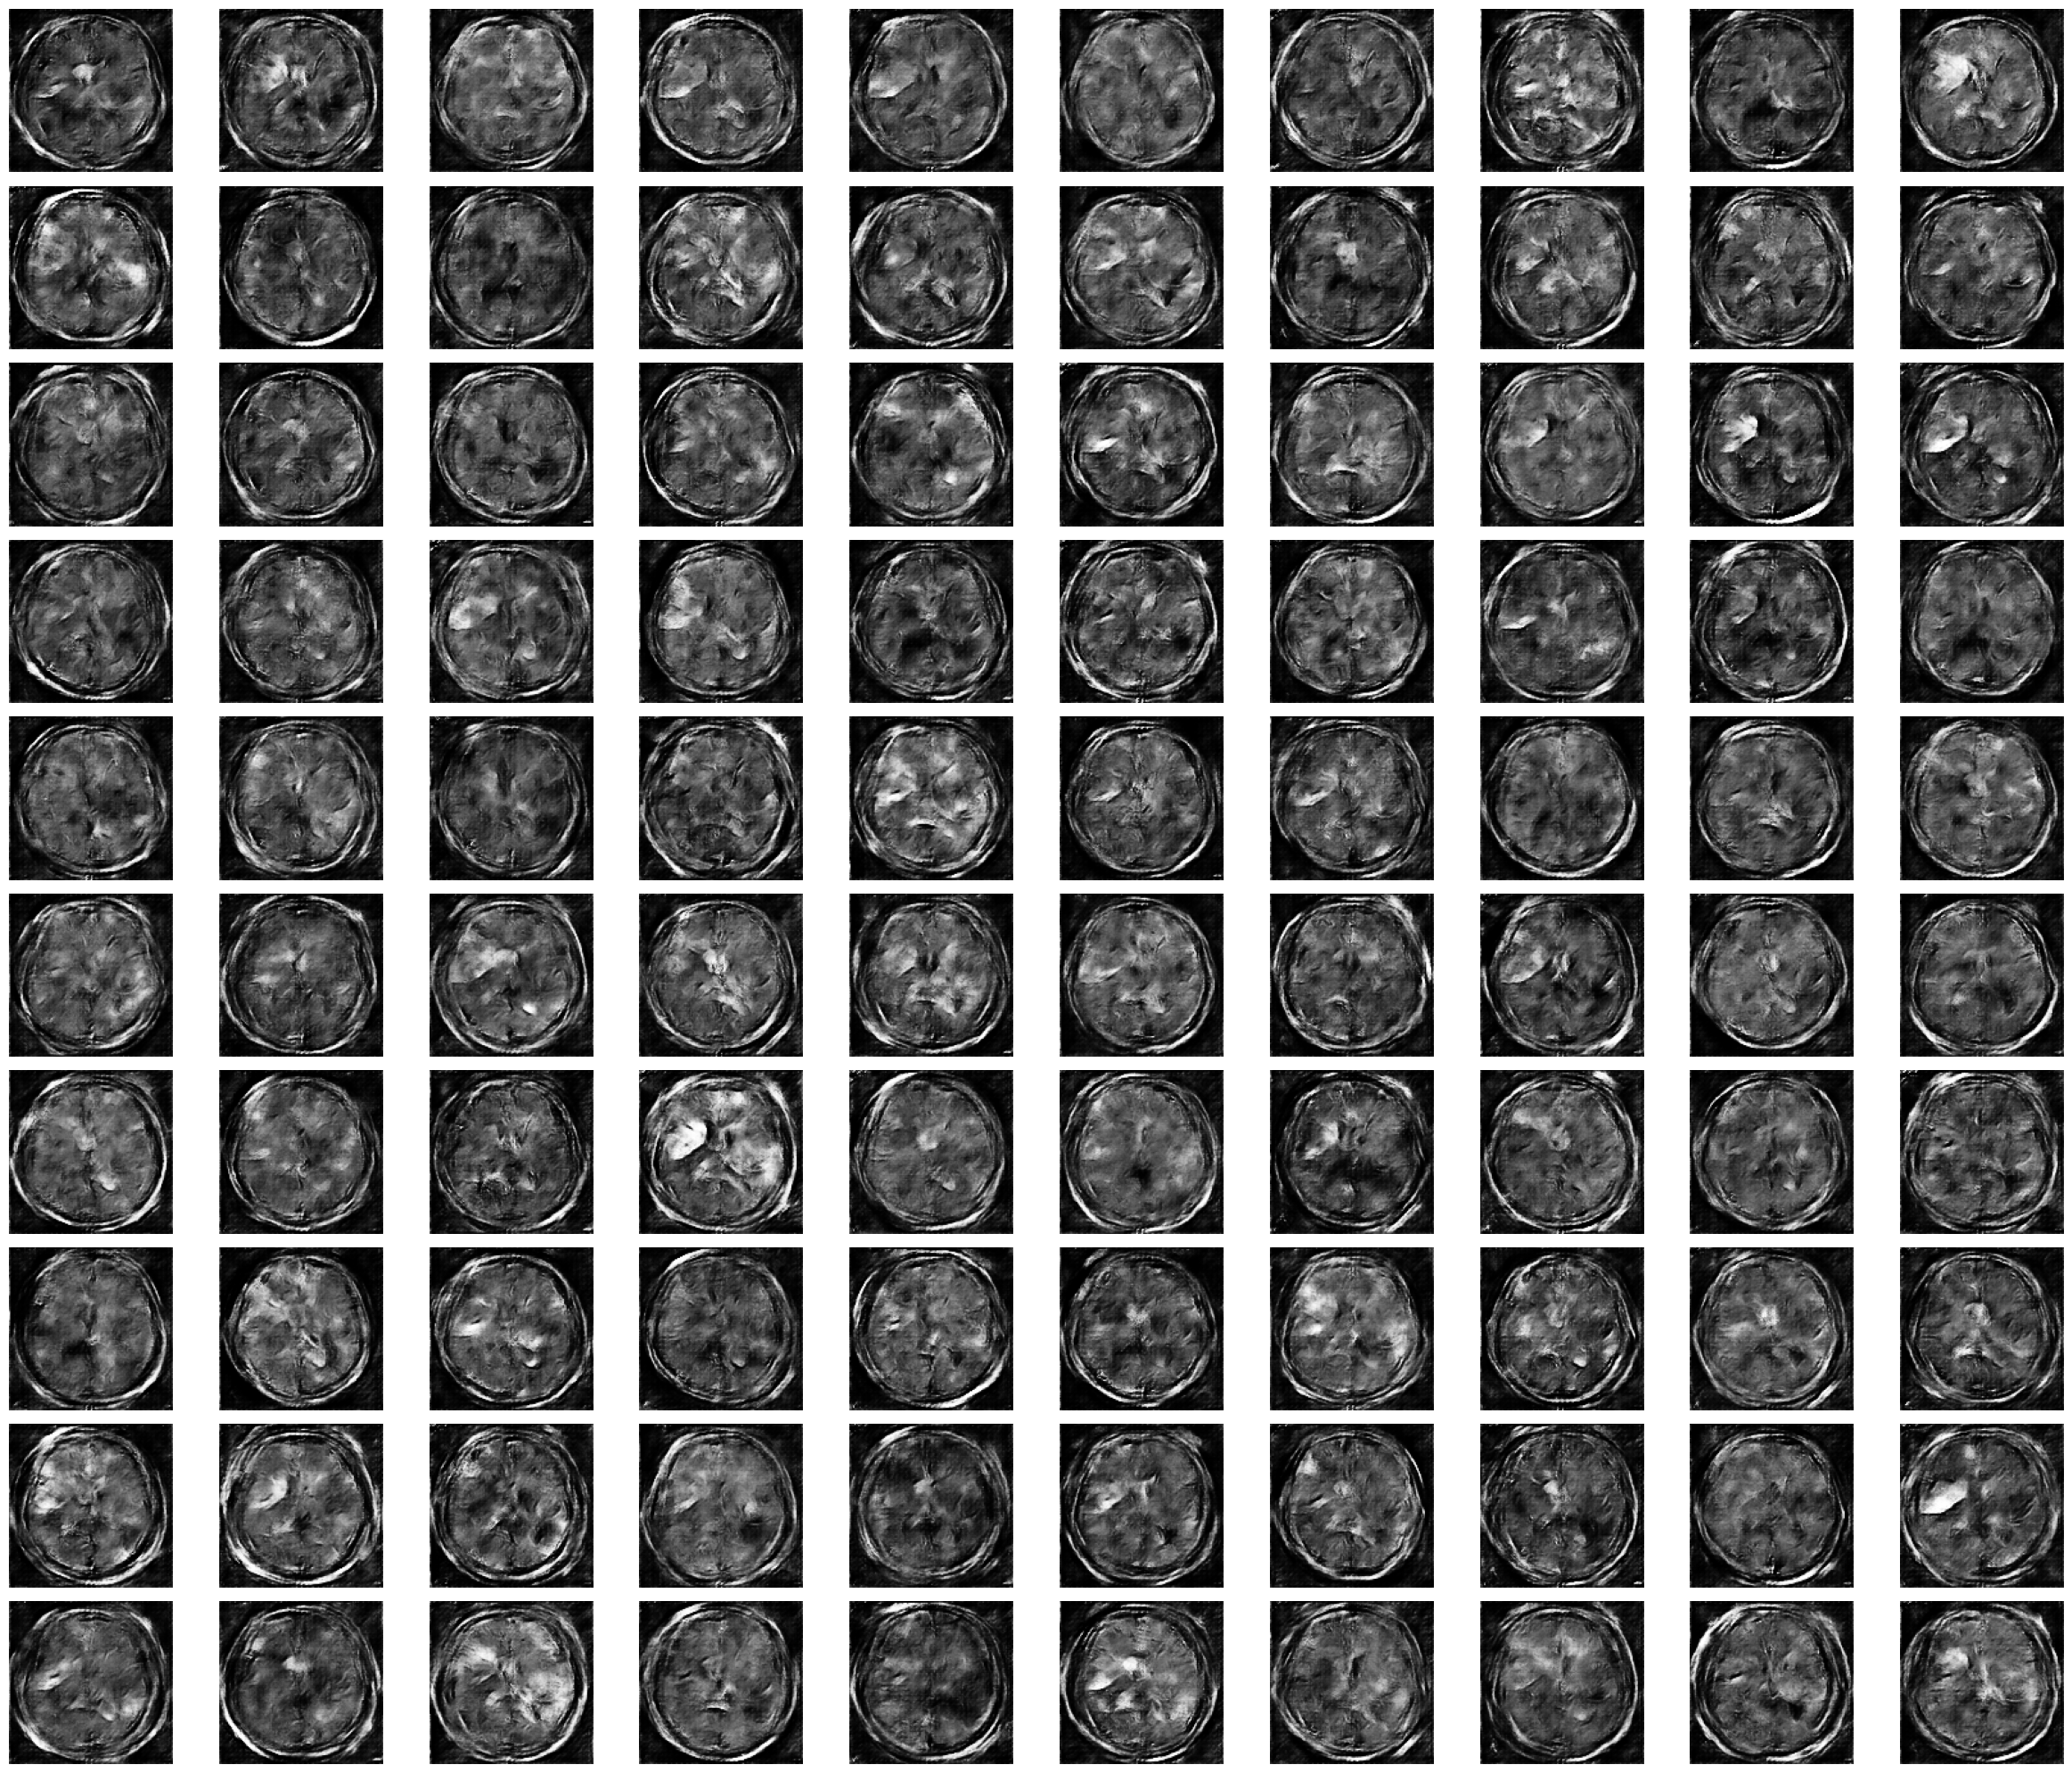

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

4/4 [==============================] - 4s 939ms/step


(100, 128, 128, 1)